In [22]:
try:
  %tensorflow_version 2.x
except Exception:
  pass

# Import the libraries

In [24]:
import numpy as np
import pandas as pd
import os

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Embedding, Dense, Dropout, LeakyReLU, Flatten, SimpleRNN, BatchNormalization
import time
import datetime

from tensorflow.keras.layers import Lambda

from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model

import matplotlib.pyplot as plt
import datetime as dt
import yfinance as yf
yf.pdr_override()
from pandas_datareader import data as pdr

In [26]:
def plot_dataframe(df):
  for column_name in df.columns:
    plt.figure()
    plt.title(column_name)
    plt.plot(df[column_name])

# Preprocessing

In [28]:
def add_Ma(df, window=5):
    for i in range(window, df.shape[0]):
        sum = 0.0
        for k in range(1, window+1):
            sum += df.iloc[i-k, 4]
        df.loc[df.index[i], 'Ma'] = np.round(sum/window, 6)
    return df[window:]

In [30]:
class Standarized_TimeseriesGenerator(tf.keras.preprocessing.sequence.TimeseriesGenerator):
  def __getitem__(self, index):
    samples, targets  = super(Standarized_TimeseriesGenerator, self).__getitem__(index)
    mean = samples.mean(axis=1)
    std = samples.std(axis=1)
    samples = (samples - mean[:,None,:])/std[:,None,:]
    targets = (targets - mean)/std
    return samples, targets

In [32]:
def get_gen_train_test(dataframe, n_sequence, n_batch):
    data = dataframe.drop(columns='Date').to_numpy()
    targets = data
    n_samples = data.shape[0]
    train_test_split=int(n_samples*0.9)

    data_gen_train = Standarized_TimeseriesGenerator(data, targets,
                                length=n_sequence, sampling_rate=1,
                                stride=1, batch_size=n_batch,
                                start_index = 0,
                                end_index = train_test_split,
                                shuffle = True)
    data_gen_test = Standarized_TimeseriesGenerator(data, targets,
                                length=n_sequence, sampling_rate=1,
                                stride=1, batch_size=n_batch,
                                start_index = train_test_split,
                                end_index = n_samples-1)

    return data_gen_train, data_gen_test

# Baseline

In [34]:
def mean_squared_error(X, lenght = 5):
    squared_error = 0
    for i in range(0, X.shape[0] - lenght):
        x = X[i:i+lenght]
        mean = x.mean()
        std = x.std()
        x = (x - mean)/std
        y = (X[i+lenght] - mean)/std
        squared_error += np.square(x[-1]-y)
    return squared_error/X.shape[0]

In [36]:
# For generated data
def mean_squared_error(dataset):
    mse=0
    for X_batch, y_batch in dataset:
        mse += np.mean(np.square(X_batch[:, -1, 3:4]-y_batch[:, 3:4]))
    mse /= len(dataset)
    return mse

# Utilities

In [38]:
def mse(y_true, y_pred):
    return tf.reduce_mean(tf.square(y_true[:,3]-y_pred[:,3]))
def mae(y_true, y_pred):
    return tf.reduce_mean(tf.keras.backend.abs((y_true[:,3]-y_pred[:,3])))
    # ***The absolute is over the whole thing as y_true can be negative
def mape(y_true, y_pred):
    return tf.reduce_mean(tf.keras.backend.abs((y_true[:,3]-y_pred[:,3])/y_true[:,3]))
    # ***The absolute is over the whole thing as y_true can be negative
def rmse(y_true, y_pred):
    return tf.sqrt(tf.reduce_mean(tf.square(y_true[:,3]-y_pred[:,3])))
def ar(y_true, y_pred):
    mask = tf.cast(y_pred[1:,3] > y_true[:-1,3],tf.float32)
    return tf.reduce_mean((y_true[1:,3]-y_true[:-1,3])*mask)

# GAN

## Perdidas

In [40]:
def discriminator_loss(real_output, fake_output):
    real_loss = tf.keras.losses.binary_crossentropy(tf.ones_like(real_output), real_output)
    fake_loss = tf.keras.losses.binary_crossentropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(x, y, fake_output):
    a1=0.01
    g_loss = tf.keras.losses.binary_crossentropy(tf.ones_like(fake_output), fake_output)
    g_mse = tf.keras.losses.MSE(x, y)
    return a1*g_mse + (1-a1)*g_loss, g_mse

## Generator

In [42]:
def make_generator_model(n_sequence, n_features):
    inputs = Input(shape=(n_sequence, n_features,))
    rnn_1 = SimpleRNN(units=10, return_sequences=True, activation=None, kernel_initializer='random_normal')(inputs)
    batch_norm1 = BatchNormalization()(rnn_1)
    rnn_1_LRelu = LeakyReLU(alpha=0.3)(batch_norm1) 
    rnn_1_droput = Dropout(0.3)(rnn_1_LRelu)
    rnn_2 = SimpleRNN(units=10, return_sequences=False, activation=None, kernel_initializer='random_normal')(rnn_1_droput)
    batch_norm2 = BatchNormalization()(rnn_2)
    rnn_2_LRelu = LeakyReLU(alpha=0.3)(batch_norm2) 
    rnn_2_droput = Dropout(0.3)(rnn_2_LRelu)
    output_dense = Dense(n_features, activation=None)(rnn_2_droput)
    output = LeakyReLU(alpha=0.3)(output_dense) 

    model = Model(inputs=inputs, outputs=output)
    model.compile(loss=None, metrics=[mse, mae, mape, rmse, ar])
    model.summary()

    return model

## Discriminator

In [44]:
def make_discriminator_model(n_features):
    model = Sequential()
    model.add(Flatten())
    model.add(Dense(units=72, input_shape=((n_sequence+1) * n_features,), activation=None, kernel_initializer='random_normal'))
    model.add(tf.keras.layers.LeakyReLU(alpha=0.3))
    model.add(tf.keras.layers.GaussianNoise(stddev=0.2))
    model.add(Dropout(0.3))
    model.add(Dense(units=100, activation=None, kernel_initializer='random_normal'))
    model.add(tf.keras.layers.LeakyReLU(alpha=0.3))
    model.add(Dropout(0.3))
    model.add(Dense(units=10, activation=None, kernel_initializer='random_normal'))
    model.add(tf.keras.layers.LeakyReLU(alpha=0.3))
    model.add(Dropout(0.3))
    model.add(Dense(1 ,activation='sigmoid'))
    model.compile(loss=discriminator_loss)
    return model

# Training

In [46]:
def train_step_def(sequences, sequences_end):
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_prediction = generator(sequences, training=True)

        sequences_true = tf.concat((sequences, sequences_end[:, None, :]), axis=1)
        sequences_fake = tf.concat((sequences, generated_prediction[:, None, :]), axis=1)

        real_output = discriminator(sequences_true, training=True)
        fake_output = discriminator(sequences_fake, training=True)

        gen_loss, gen_mse_loss = generator_loss(generated_prediction, 
                                                sequences_end, 
                                                fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return tf.reduce_mean(gen_loss), tf.reduce_mean(disc_loss), tf.reduce_mean(gen_mse_loss)

def test_step_def(sequences, sequences_end):
    generated_prediction = generator(sequences, training=False)

    sequences_true = tf.concat((sequences, sequences_end[:,None,:]), axis=1)
    sequences_fake = tf.concat((sequences, generated_prediction[:,None,:]), axis=1)

    real_output = discriminator(sequences_true, training=False)
    fake_output = discriminator(sequences_fake, training=False)

    gen_loss, gen_mse_loss = generator_loss(generated_prediction, sequences_end, fake_output)
    disc_loss = discriminator_loss(real_output, fake_output)
    return tf.reduce_mean(gen_loss), tf.reduce_mean(disc_loss), tf.reduce_mean(gen_mse_loss)

In [48]:
def train(dataset, dataset_val, epochs):
    history = np.empty(shape = (8, epochs))
    history_val = np.empty(shape = (8, epochs))
    len_dataset = len(dataset)
    len_dataset_val = len(dataset_val)
    for epoch in range(epochs):
        start = time.time()

        cur_dis_loss = 0
        cur_gen_loss = 0
        cur_gen_mse_loss = 0
        for sequence_batch, sequence_end_batch in dataset:
            aux_cur_losses = train_step(tf.cast(sequence_batch, tf.float32), 
                                      tf.cast(sequence_end_batch, tf.float32))
            cur_gen_loss += aux_cur_losses[0]/len_dataset
            cur_dis_loss += aux_cur_losses[1]/len_dataset
            cur_gen_mse_loss += aux_cur_losses[2]/len_dataset
        cur_gen_metrics = generator.evaluate(dataset,verbose=False)[1:]

        history[:, epoch] = cur_gen_loss, cur_dis_loss, cur_gen_mse_loss, *cur_gen_metrics

        cur_gen_metrics_val = generator.evaluate(dataset_val,verbose=False)[1: ]

        cur_gen_loss_val = 0
        cur_dis_loss_val = 0
        cur_gen_mse_loss_val = 0
        for sequence_batch, sequence_end_batch in dataset_val:
            aux_cur_losses_val = test_step(tf.cast(sequence_batch, tf.float32), 
                                         tf.cast(sequence_end_batch, tf.float32))
            cur_gen_loss_val += aux_cur_losses_val[0]/len_dataset_val
            cur_dis_loss_val += aux_cur_losses_val[1]/len_dataset_val
            cur_gen_mse_loss_val += aux_cur_losses_val[2]/len_dataset_val
    


        history_val[:, epoch] = cur_gen_loss_val, cur_dis_loss_val, cur_gen_mse_loss_val, *cur_gen_metrics_val

        print ('Time for epoch {} is {} sec Generator Loss: {},  Discriminator_loss: {}'
               .format(epoch + 1, time.time()-start, cur_gen_loss, cur_dis_loss))

        # Save the model every 15 epochs
        if (epoch + 1) % 15 == 0:
            checkpoint.save(file_prefix = checkpoint_prefix)

    return history, history_val

## Visualization

In [50]:
def plot_history(history, history_val):
    metrics = ["gen_loss","dis_loss","gen_mse_loss", 'mse','mae','mape','rmse','ar']
    for i, metric_name in enumerate(metrics):  
        plt.figure()
        plt.title(metric_name)
        plt.plot(history[i], label='train')
        plt.plot(history_val[i], label='test')
        plt.legend()
    plt.show()

In [52]:
def plot_frame(sequence, target, model):
    y_pred = model.predict(sequence)[...,3]
    y_true = target[...,3]

    plt.figure()
    plt.title("closing price")
    plt.plot(y_true, label="true")
    plt.plot(y_pred, label="prediction")
    plt.legend()
    plt.show()

In [54]:
def get_best_results(history):
    min_index = np.argmin(history[3, :])
    return history[:, min_index]

## Variables

In [56]:
window = 5
n_sequence = window
n_features = 7
n_batch = 50

## Data loading

In [58]:
stock_code = "TSLA"
start = dt.datetime(2000, 1, 1)
end = dt.datetime(2020, 12, 31)
raw_data = pdr.get_data_yahoo(stock_code, start, end,threads=False, proxy="http://127.0.0.1:7890")
df = raw_data.dropna();
df = df.reset_index(level=0)
df = add_Ma(df, window)
df

[*********************100%***********************]  1 of 1 completed


Date        Open        High         Low       Close   Adj Close  \
5    2010-07-07    1.093333    1.108667    0.998667    1.053333    1.053333   
6    2010-07-08    1.076000    1.168000    1.038000    1.164000    1.164000   
7    2010-07-09    1.172000    1.193333    1.103333    1.160000    1.160000   
8    2010-07-12    1.196667    1.204667    1.133333    1.136667    1.136667   
9    2010-07-13    1.159333    1.242667    1.126667    1.209333    1.209333   
...         ...         ...         ...         ...         ...         ...   
2641 2020-12-23  210.733337  217.166672  207.523331  215.326660  215.326660   
2642 2020-12-24  214.330002  222.029999  213.666672  220.589996  220.589996   
2643 2020-12-28  224.836670  227.133331  220.266663  221.229996  221.229996   
2644 2020-12-29  220.333328  223.300003  218.333328  221.996674  221.996674   
2645 2020-12-30  224.000000  232.199997  222.786667  231.593338  231.593338   

         Volume          Ma  
5     103825500    1.399867  
6     115671000    1.292000  
7      60759000    1.207067  
8      33037500    1.146267  
9      40201500    1.117600  
...         ...         ...  
2641   99519000  217.591333  
2642   68596800  219.138666  
2643   96835800  219.529999  
2644   68732400  217.442664  
2645  128538000  218.517999  

[2641 rows x 8 columns]

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 5, 7)]            0         
                                                                 
 simple_rnn (SimpleRNN)      (None, 5, 10)             180       
                                                                 
 batch_normalization (BatchN  (None, 5, 10)            40        
 ormalization)                                                   
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 5, 10)             0         
                                                                 
 dropout (Dropout)           (None, 5, 10)             0         
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 10)                210       
                                                             

Time for epoch 53 is 0.44394898414611816 sec Generator Loss: 1.3329898118972778,  Discriminator_loss: 0.9803903102874756
Time for epoch 54 is 0.41464972496032715 sec Generator Loss: 1.3254178762435913,  Discriminator_loss: 0.9877532124519348
Time for epoch 55 is 0.41265869140625 sec Generator Loss: 1.3037092685699463,  Discriminator_loss: 1.0232288837432861
Time for epoch 56 is 0.4075584411621094 sec Generator Loss: 1.295745849609375,  Discriminator_loss: 1.0239452123641968
Time for epoch 57 is 0.4101231098175049 sec Generator Loss: 1.3145971298217773,  Discriminator_loss: 0.9894772171974182
Time for epoch 58 is 0.42206287384033203 sec Generator Loss: 1.307950496673584,  Discriminator_loss: 0.9970537424087524
Time for epoch 59 is 0.4211857318878174 sec Generator Loss: 1.3017334938049316,  Discriminator_loss: 0.9977994561195374
Time for epoch 60 is 0.4201803207397461 sec Generator Loss: 1.3348946571350098,  Discriminator_loss: 0.9964148998260498
Time for epoch 61 is 0.41391539573669434 

Time for epoch 122 is 0.37242770195007324 sec Generator Loss: 1.0559927225112915,  Discriminator_loss: 1.177227258682251
Time for epoch 123 is 0.3753201961517334 sec Generator Loss: 1.0672104358673096,  Discriminator_loss: 1.1534782648086548
Time for epoch 124 is 0.37345290184020996 sec Generator Loss: 1.0706372261047363,  Discriminator_loss: 1.1500366926193237
Time for epoch 125 is 0.37652587890625 sec Generator Loss: 1.061447024345398,  Discriminator_loss: 1.167075514793396
Time for epoch 126 is 0.3700549602508545 sec Generator Loss: 1.0736877918243408,  Discriminator_loss: 1.1625980138778687
Time for epoch 127 is 0.367053747177124 sec Generator Loss: 1.072102665901184,  Discriminator_loss: 1.160108208656311
Time for epoch 128 is 0.37680840492248535 sec Generator Loss: 1.0576238632202148,  Discriminator_loss: 1.1571149826049805
Time for epoch 129 is 0.3716247081756592 sec Generator Loss: 1.0600976943969727,  Discriminator_loss: 1.1582444906234741
Time for epoch 130 is 0.3736875057220

Time for epoch 190 is 0.41455578804016113 sec Generator Loss: 1.0242493152618408,  Discriminator_loss: 1.1940959692001343
Time for epoch 191 is 0.44713735580444336 sec Generator Loss: 1.0474779605865479,  Discriminator_loss: 1.177290439605713
Time for epoch 192 is 0.443589448928833 sec Generator Loss: 1.0223745107650757,  Discriminator_loss: 1.198432445526123
Time for epoch 193 is 0.43706417083740234 sec Generator Loss: 1.0387684106826782,  Discriminator_loss: 1.1925570964813232
Time for epoch 194 is 0.4154398441314697 sec Generator Loss: 1.038050889968872,  Discriminator_loss: 1.1792765855789185
Time for epoch 195 is 0.4243509769439697 sec Generator Loss: 1.0470672845840454,  Discriminator_loss: 1.1615562438964844
Time for epoch 196 is 0.41478610038757324 sec Generator Loss: 1.0341243743896484,  Discriminator_loss: 1.2006510496139526
Time for epoch 197 is 0.42007923126220703 sec Generator Loss: 1.0548593997955322,  Discriminator_loss: 1.1906870603561401
Time for epoch 198 is 0.4121658

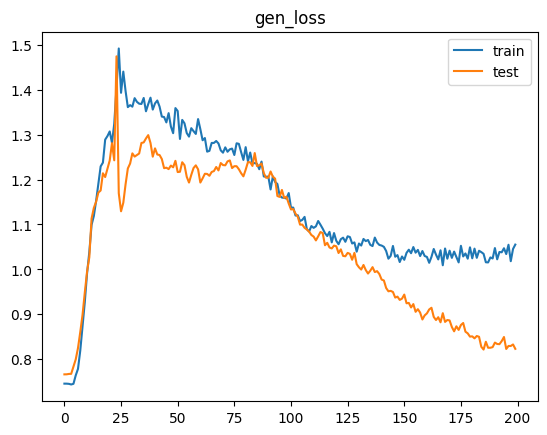

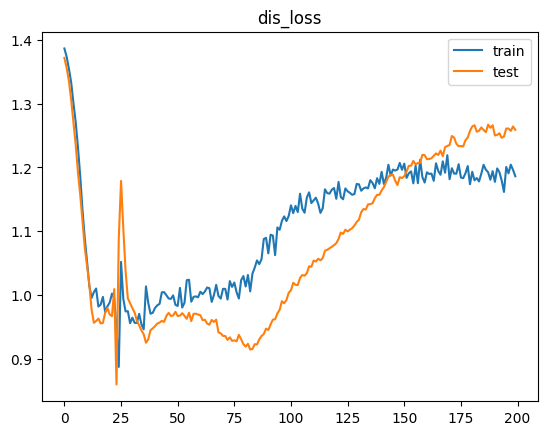

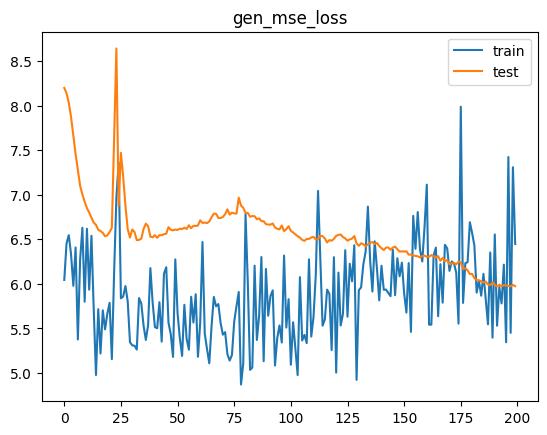

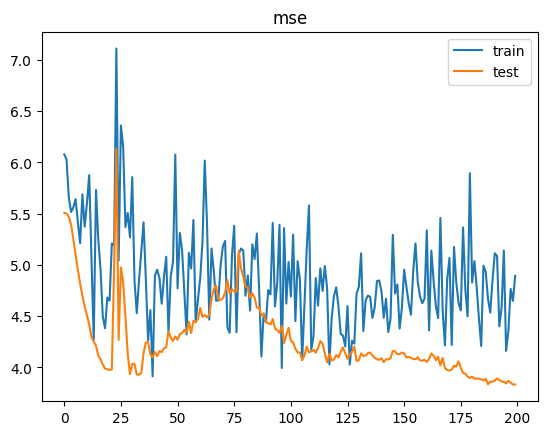

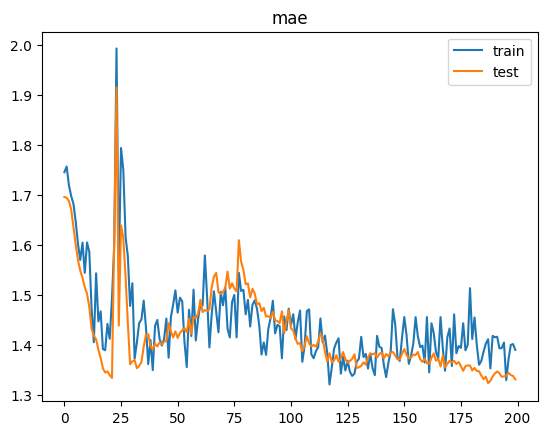

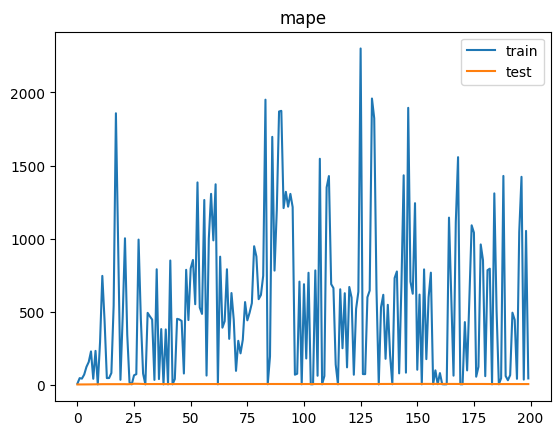

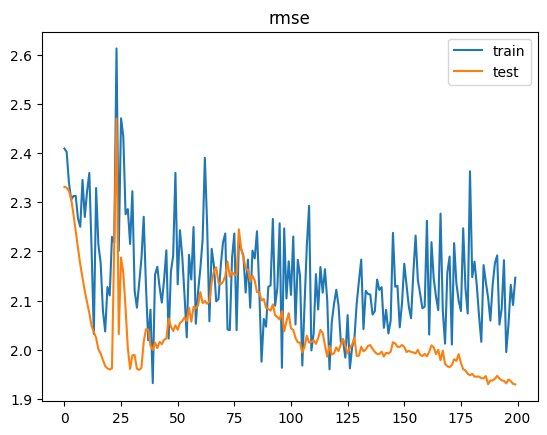

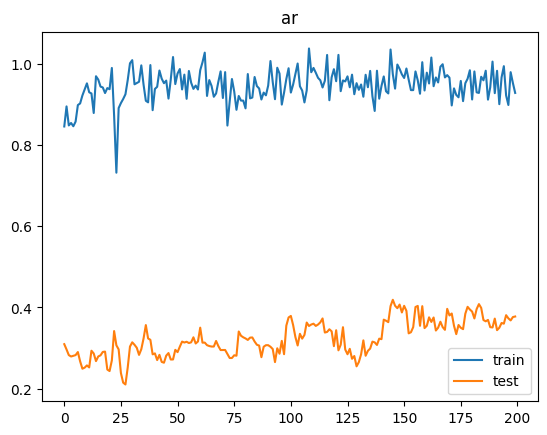

2/2 [==============================] - 0s 3ms/step


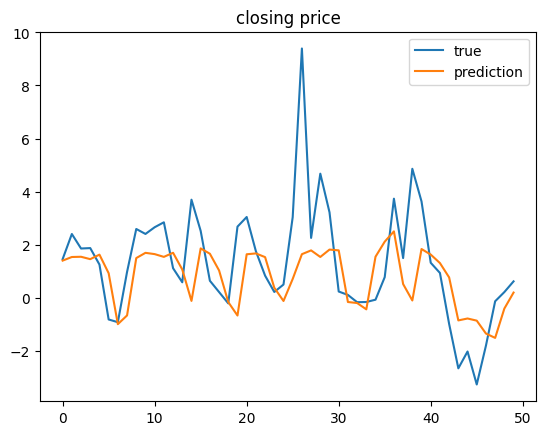

[MSE Baseline] train: 4.466990936756448  test: 3.868181586758766
Delta time with epochs = 200: 0:01:32.507920
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 5, 7)]            0         
                                                                 
 simple_rnn_2 (SimpleRNN)    (None, 5, 10)             180       
                                                                 
 batch_normalization_2 (Batc  (None, 5, 10)            40        
 hNormalization)                                                 
                                                                 
 leaky_re_lu_6 (LeakyReLU)   (None, 5, 10)             0         
                                                                 
 dropout_5 (Dropout)         (None, 5, 10)             0         
                                                                 
 simple_rnn_3 (

Time for epoch 52 is 0.41810131072998047 sec Generator Loss: 1.1005052328109741,  Discriminator_loss: 1.1310937404632568
Time for epoch 53 is 0.4468042850494385 sec Generator Loss: 1.1046793460845947,  Discriminator_loss: 1.1240618228912354
Time for epoch 54 is 0.4094126224517822 sec Generator Loss: 1.0915857553482056,  Discriminator_loss: 1.1343226432800293
Time for epoch 55 is 0.4142789840698242 sec Generator Loss: 1.084821105003357,  Discriminator_loss: 1.1353756189346313
Time for epoch 56 is 0.4091160297393799 sec Generator Loss: 1.0812861919403076,  Discriminator_loss: 1.1293100118637085
Time for epoch 57 is 0.41388463973999023 sec Generator Loss: 1.0748178958892822,  Discriminator_loss: 1.14460289478302
Time for epoch 58 is 0.4200761318206787 sec Generator Loss: 1.0721524953842163,  Discriminator_loss: 1.1440026760101318
Time for epoch 59 is 0.4226357936859131 sec Generator Loss: 1.0377706289291382,  Discriminator_loss: 1.163051724433899
Time for epoch 60 is 0.41153502464294434 s

Time for epoch 121 is 0.399033784866333 sec Generator Loss: 0.9595252275466919,  Discriminator_loss: 1.2284295558929443
Time for epoch 122 is 0.4121425151824951 sec Generator Loss: 0.9792609810829163,  Discriminator_loss: 1.2243709564208984
Time for epoch 123 is 0.41752076148986816 sec Generator Loss: 0.96048903465271,  Discriminator_loss: 1.2525914907455444
Time for epoch 124 is 0.40750670433044434 sec Generator Loss: 0.969134509563446,  Discriminator_loss: 1.2200915813446045
Time for epoch 125 is 0.4111330509185791 sec Generator Loss: 0.9435175657272339,  Discriminator_loss: 1.2431968450546265
Time for epoch 126 is 0.4098083972930908 sec Generator Loss: 0.9502297043800354,  Discriminator_loss: 1.2261021137237549
Time for epoch 127 is 0.42084288597106934 sec Generator Loss: 0.9588982462882996,  Discriminator_loss: 1.23372220993042
Time for epoch 128 is 0.4184579849243164 sec Generator Loss: 0.9636171460151672,  Discriminator_loss: 1.2351081371307373
Time for epoch 129 is 0.41124582290

Time for epoch 189 is 0.43261146545410156 sec Generator Loss: 0.9253735542297363,  Discriminator_loss: 1.2642797231674194
Time for epoch 190 is 0.4173007011413574 sec Generator Loss: 0.9173282384872437,  Discriminator_loss: 1.2571568489074707
Time for epoch 191 is 0.41167736053466797 sec Generator Loss: 0.9219198822975159,  Discriminator_loss: 1.2450611591339111
Time for epoch 192 is 0.40970683097839355 sec Generator Loss: 0.9297836422920227,  Discriminator_loss: 1.251757025718689
Time for epoch 193 is 0.41146278381347656 sec Generator Loss: 0.9220740795135498,  Discriminator_loss: 1.2737590074539185
Time for epoch 194 is 0.42241406440734863 sec Generator Loss: 0.914691686630249,  Discriminator_loss: 1.2854589223861694
Time for epoch 195 is 0.4035193920135498 sec Generator Loss: 0.9267609715461731,  Discriminator_loss: 1.2474225759506226
Time for epoch 196 is 0.41107845306396484 sec Generator Loss: 0.9266352653503418,  Discriminator_loss: 1.260166883468628
Time for epoch 197 is 0.40377

Time for epoch 257 is 0.4458646774291992 sec Generator Loss: 0.9340061545372009,  Discriminator_loss: 1.2535806894302368
Time for epoch 258 is 0.4380326271057129 sec Generator Loss: 0.9338250756263733,  Discriminator_loss: 1.2533313035964966
Time for epoch 259 is 0.4027848243713379 sec Generator Loss: 0.9301549792289734,  Discriminator_loss: 1.2443773746490479
Time for epoch 260 is 0.41358065605163574 sec Generator Loss: 0.9329279065132141,  Discriminator_loss: 1.2622170448303223
Time for epoch 261 is 0.4037339687347412 sec Generator Loss: 0.9315942525863647,  Discriminator_loss: 1.2538193464279175
Time for epoch 262 is 0.40331196784973145 sec Generator Loss: 0.931873083114624,  Discriminator_loss: 1.2643941640853882
Time for epoch 263 is 0.41318202018737793 sec Generator Loss: 0.9282573461532593,  Discriminator_loss: 1.2677686214447021
Time for epoch 264 is 0.4120640754699707 sec Generator Loss: 0.9382445216178894,  Discriminator_loss: 1.2253010272979736
Time for epoch 265 is 0.429842

Time for epoch 325 is 0.40755724906921387 sec Generator Loss: 0.9167192578315735,  Discriminator_loss: 1.268510103225708
Time for epoch 326 is 0.4114394187927246 sec Generator Loss: 0.933000922203064,  Discriminator_loss: 1.2387791872024536
Time for epoch 327 is 0.40436720848083496 sec Generator Loss: 0.8998969197273254,  Discriminator_loss: 1.2776315212249756
Time for epoch 328 is 0.4163858890533447 sec Generator Loss: 0.9185904264450073,  Discriminator_loss: 1.259032964706421
Time for epoch 329 is 0.4080162048339844 sec Generator Loss: 0.9140955805778503,  Discriminator_loss: 1.254036545753479
Time for epoch 330 is 0.44466543197631836 sec Generator Loss: 0.9166415929794312,  Discriminator_loss: 1.2684330940246582
Time for epoch 331 is 0.41043639183044434 sec Generator Loss: 0.9070592522621155,  Discriminator_loss: 1.269476056098938
Time for epoch 332 is 0.4181389808654785 sec Generator Loss: 0.919428288936615,  Discriminator_loss: 1.26263427734375
Time for epoch 333 is 0.420634508132

Time for epoch 393 is 0.421891450881958 sec Generator Loss: 0.915783166885376,  Discriminator_loss: 1.2624733448028564
Time for epoch 394 is 0.41418910026550293 sec Generator Loss: 0.9165955781936646,  Discriminator_loss: 1.26805579662323
Time for epoch 395 is 0.407088041305542 sec Generator Loss: 0.918653130531311,  Discriminator_loss: 1.2592816352844238
Time for epoch 396 is 0.40558958053588867 sec Generator Loss: 0.9390559792518616,  Discriminator_loss: 1.2439035177230835
Time for epoch 397 is 0.4123842716217041 sec Generator Loss: 0.9371930360794067,  Discriminator_loss: 1.2552303075790405
Time for epoch 398 is 0.40662288665771484 sec Generator Loss: 0.9238556623458862,  Discriminator_loss: 1.2508013248443604
Time for epoch 399 is 0.42017269134521484 sec Generator Loss: 0.9119980931282043,  Discriminator_loss: 1.2694602012634277
Time for epoch 400 is 0.42658209800720215 sec Generator Loss: 0.9199114441871643,  Discriminator_loss: 1.2483928203582764
Time for epoch 401 is 0.406337499

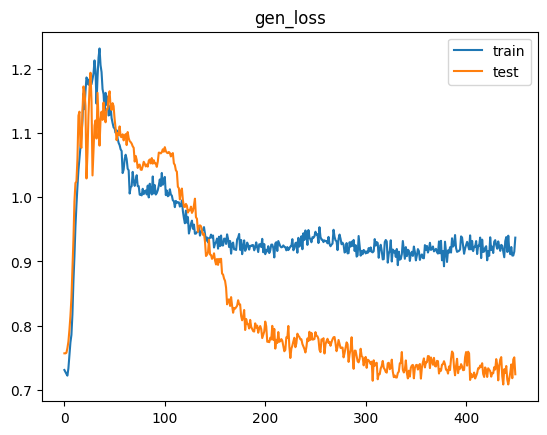

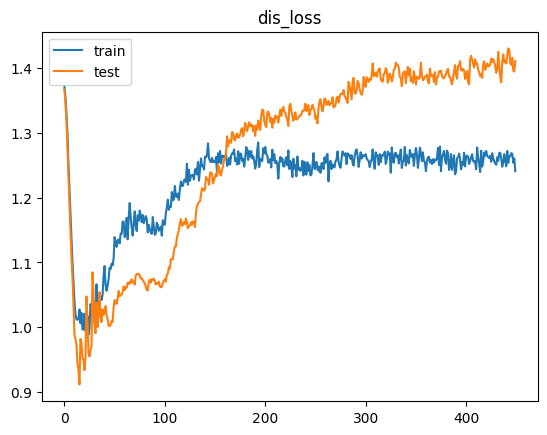

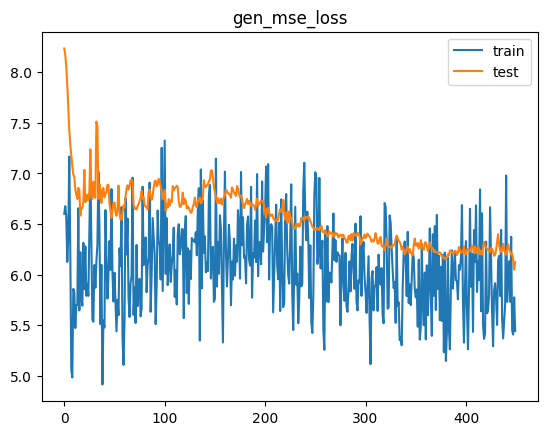

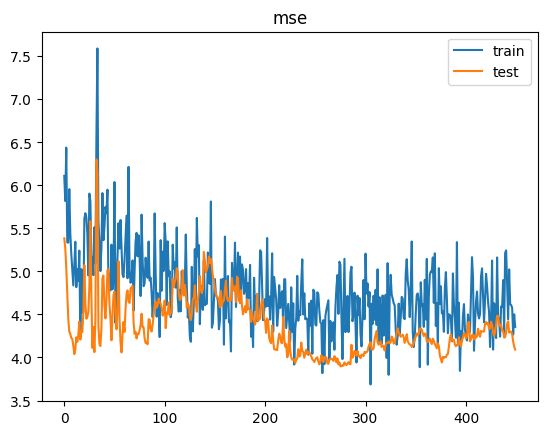

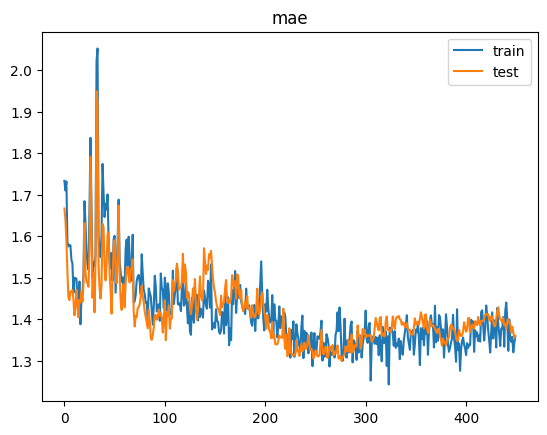

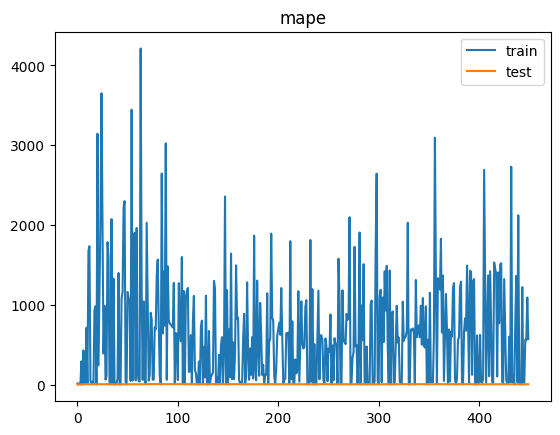

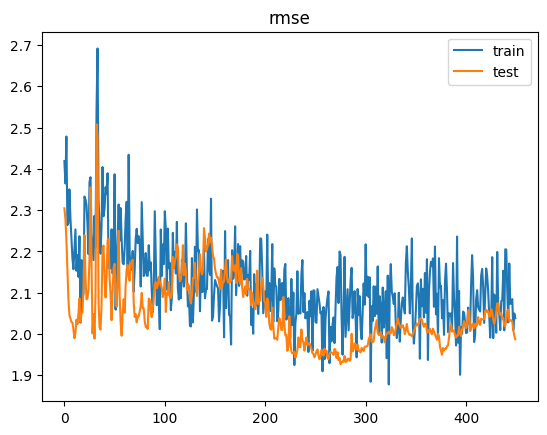

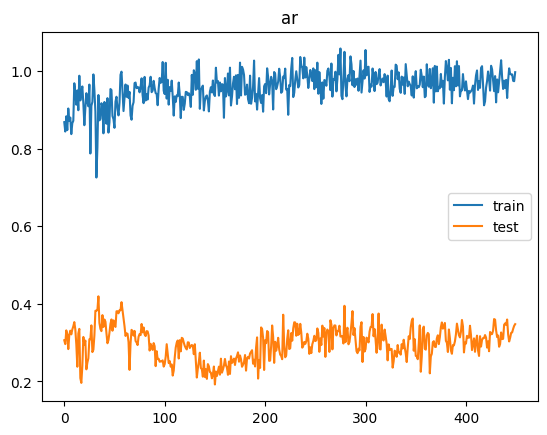

2/2 [==============================] - 0s 2ms/step


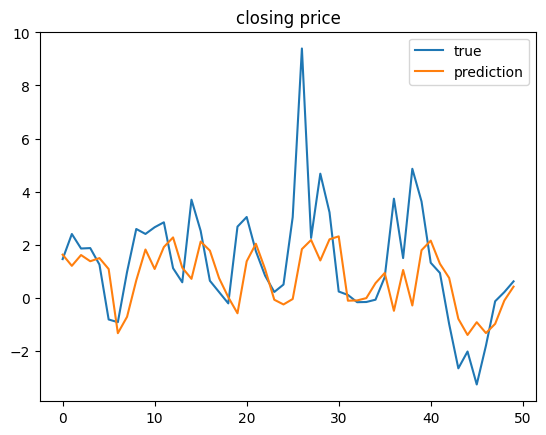

[MSE Baseline] train: 4.019369920483327  test: 3.868181586758766
Delta time with epochs = 450: 0:03:17.385576
Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 5, 7)]            0         
                                                                 
 simple_rnn_4 (SimpleRNN)    (None, 5, 10)             180       
                                                                 
 batch_normalization_4 (Batc  (None, 5, 10)            40        
 hNormalization)                                                 
                                                                 
 leaky_re_lu_12 (LeakyReLU)  (None, 5, 10)             0         
                                                                 
 dropout_10 (Dropout)        (None, 5, 10)             0         
                                                                 
 simple_rnn_5 (

Time for epoch 52 is 0.4258875846862793 sec Generator Loss: 1.2661341428756714,  Discriminator_loss: 1.0545175075531006
Time for epoch 53 is 0.43128395080566406 sec Generator Loss: 1.2731622457504272,  Discriminator_loss: 1.0562846660614014
Time for epoch 54 is 0.4283449649810791 sec Generator Loss: 1.2774513959884644,  Discriminator_loss: 1.0492769479751587
Time for epoch 55 is 0.4554026126861572 sec Generator Loss: 1.239203691482544,  Discriminator_loss: 1.0626325607299805
Time for epoch 56 is 0.4463663101196289 sec Generator Loss: 1.2531912326812744,  Discriminator_loss: 1.0592296123504639
Time for epoch 57 is 0.43070220947265625 sec Generator Loss: 1.2472689151763916,  Discriminator_loss: 1.0572786331176758
Time for epoch 58 is 0.4270617961883545 sec Generator Loss: 1.2369327545166016,  Discriminator_loss: 1.0575776100158691
Time for epoch 59 is 0.4156758785247803 sec Generator Loss: 1.2301076650619507,  Discriminator_loss: 1.078845739364624
Time for epoch 60 is 0.43201541900634766

Time for epoch 121 is 0.45697951316833496 sec Generator Loss: 1.0006242990493774,  Discriminator_loss: 1.201135277748108
Time for epoch 122 is 0.4034137725830078 sec Generator Loss: 1.0119633674621582,  Discriminator_loss: 1.209445834159851
Time for epoch 123 is 0.4127788543701172 sec Generator Loss: 0.9918583035469055,  Discriminator_loss: 1.2132048606872559
Time for epoch 124 is 0.4121685028076172 sec Generator Loss: 1.004390835762024,  Discriminator_loss: 1.210968017578125
Time for epoch 125 is 0.43935561180114746 sec Generator Loss: 1.0087084770202637,  Discriminator_loss: 1.202242136001587
Time for epoch 126 is 0.40761494636535645 sec Generator Loss: 0.9963634014129639,  Discriminator_loss: 1.2095540761947632
Time for epoch 127 is 0.4033832550048828 sec Generator Loss: 0.9764518141746521,  Discriminator_loss: 1.2307401895523071
Time for epoch 128 is 0.41319775581359863 sec Generator Loss: 0.9907483458518982,  Discriminator_loss: 1.2072718143463135
Time for epoch 129 is 0.402936220

Time for epoch 189 is 0.42232799530029297 sec Generator Loss: 0.9714604616165161,  Discriminator_loss: 1.2408300638198853
Time for epoch 190 is 0.4329409599304199 sec Generator Loss: 0.9613093137741089,  Discriminator_loss: 1.228736162185669
Time for epoch 191 is 0.424741268157959 sec Generator Loss: 0.9760079979896545,  Discriminator_loss: 1.2246696949005127
Time for epoch 192 is 0.4232027530670166 sec Generator Loss: 0.9724189043045044,  Discriminator_loss: 1.2318817377090454
Time for epoch 193 is 0.43828797340393066 sec Generator Loss: 0.9653654098510742,  Discriminator_loss: 1.2550456523895264
Time for epoch 194 is 0.44997620582580566 sec Generator Loss: 0.969190776348114,  Discriminator_loss: 1.2247610092163086
Time for epoch 195 is 0.4247143268585205 sec Generator Loss: 0.9764164090156555,  Discriminator_loss: 1.228674292564392
Time for epoch 196 is 0.42461538314819336 sec Generator Loss: 0.9663156270980835,  Discriminator_loss: 1.2424087524414062
Time for epoch 197 is 0.41768240

Time for epoch 257 is 0.3798186779022217 sec Generator Loss: 0.9300603866577148,  Discriminator_loss: 1.2568562030792236
Time for epoch 258 is 0.39026594161987305 sec Generator Loss: 0.9434168338775635,  Discriminator_loss: 1.252025842666626
Time for epoch 259 is 0.36703014373779297 sec Generator Loss: 0.9546321034431458,  Discriminator_loss: 1.2468981742858887
Time for epoch 260 is 0.38857460021972656 sec Generator Loss: 0.9513749480247498,  Discriminator_loss: 1.2580269575119019
Time for epoch 261 is 0.3796663284301758 sec Generator Loss: 0.9377157688140869,  Discriminator_loss: 1.2577145099639893
Time for epoch 262 is 0.3726322650909424 sec Generator Loss: 0.9581202268600464,  Discriminator_loss: 1.2439923286437988
Time for epoch 263 is 0.36933064460754395 sec Generator Loss: 0.9609245657920837,  Discriminator_loss: 1.2412209510803223
Time for epoch 264 is 0.3741779327392578 sec Generator Loss: 0.9570865631103516,  Discriminator_loss: 1.2536309957504272
Time for epoch 265 is 0.37293

Time for epoch 325 is 0.37855052947998047 sec Generator Loss: 0.9368022680282593,  Discriminator_loss: 1.2612744569778442
Time for epoch 326 is 0.3709714412689209 sec Generator Loss: 0.9511840343475342,  Discriminator_loss: 1.2517645359039307
Time for epoch 327 is 0.36969828605651855 sec Generator Loss: 0.963691771030426,  Discriminator_loss: 1.236489176750183
Time for epoch 328 is 0.36838722229003906 sec Generator Loss: 0.9513829946517944,  Discriminator_loss: 1.2474217414855957
Time for epoch 329 is 0.3955402374267578 sec Generator Loss: 0.9577670097351074,  Discriminator_loss: 1.2356016635894775
Time for epoch 330 is 0.38221240043640137 sec Generator Loss: 0.9402781128883362,  Discriminator_loss: 1.2497974634170532
Time for epoch 331 is 0.3719630241394043 sec Generator Loss: 0.951988935470581,  Discriminator_loss: 1.2430204153060913
Time for epoch 332 is 0.3742821216583252 sec Generator Loss: 0.9593066573143005,  Discriminator_loss: 1.2470459938049316
Time for epoch 333 is 0.3869991

Time for epoch 393 is 0.41635894775390625 sec Generator Loss: 0.9503429532051086,  Discriminator_loss: 1.245821237564087
Time for epoch 394 is 0.408369779586792 sec Generator Loss: 0.942218542098999,  Discriminator_loss: 1.257244348526001
Time for epoch 395 is 0.4317018985748291 sec Generator Loss: 0.9330149292945862,  Discriminator_loss: 1.2520333528518677
Time for epoch 396 is 0.41124773025512695 sec Generator Loss: 0.9239996075630188,  Discriminator_loss: 1.2580854892730713
Time for epoch 397 is 0.4002196788787842 sec Generator Loss: 0.9352426528930664,  Discriminator_loss: 1.2589800357818604
Time for epoch 398 is 0.4100003242492676 sec Generator Loss: 0.9423235058784485,  Discriminator_loss: 1.2563406229019165
Time for epoch 399 is 0.40591907501220703 sec Generator Loss: 0.9385858774185181,  Discriminator_loss: 1.2515630722045898
Time for epoch 400 is 0.41300415992736816 sec Generator Loss: 0.9534705877304077,  Discriminator_loss: 1.2519673109054565
Time for epoch 401 is 0.41966009

Time for epoch 461 is 0.4303858280181885 sec Generator Loss: 0.9244147539138794,  Discriminator_loss: 1.2695016860961914
Time for epoch 462 is 0.4095954895019531 sec Generator Loss: 0.9027469754219055,  Discriminator_loss: 1.2831707000732422
Time for epoch 463 is 0.41274213790893555 sec Generator Loss: 0.9168298244476318,  Discriminator_loss: 1.2701505422592163
Time for epoch 464 is 0.4065995216369629 sec Generator Loss: 0.9339525699615479,  Discriminator_loss: 1.25613534450531
Time for epoch 465 is 0.41062092781066895 sec Generator Loss: 0.9361926913261414,  Discriminator_loss: 1.2585422992706299
Time for epoch 466 is 0.4205808639526367 sec Generator Loss: 0.9174809455871582,  Discriminator_loss: 1.2721625566482544
Time for epoch 467 is 0.42214345932006836 sec Generator Loss: 0.9270413517951965,  Discriminator_loss: 1.2551236152648926
Time for epoch 468 is 0.4181981086730957 sec Generator Loss: 0.9120125770568848,  Discriminator_loss: 1.2639178037643433
Time for epoch 469 is 0.4077596

Time for epoch 529 is 0.41293954849243164 sec Generator Loss: 0.9324303269386292,  Discriminator_loss: 1.2730720043182373
Time for epoch 530 is 0.40598058700561523 sec Generator Loss: 0.9274880290031433,  Discriminator_loss: 1.2597761154174805
Time for epoch 531 is 0.40371203422546387 sec Generator Loss: 0.9147639870643616,  Discriminator_loss: 1.2620651721954346
Time for epoch 532 is 0.4113948345184326 sec Generator Loss: 0.9272561073303223,  Discriminator_loss: 1.2572754621505737
Time for epoch 533 is 0.40894556045532227 sec Generator Loss: 0.9249146580696106,  Discriminator_loss: 1.2677615880966187
Time for epoch 534 is 0.43045783042907715 sec Generator Loss: 0.9102165699005127,  Discriminator_loss: 1.2730134725570679
Time for epoch 535 is 0.41616368293762207 sec Generator Loss: 0.9343805909156799,  Discriminator_loss: 1.2685914039611816
Time for epoch 536 is 0.4064655303955078 sec Generator Loss: 0.9398398995399475,  Discriminator_loss: 1.2470989227294922
Time for epoch 537 is 0.43

Time for epoch 597 is 0.4067103862762451 sec Generator Loss: 0.9239951372146606,  Discriminator_loss: 1.2681676149368286
Time for epoch 598 is 0.41499972343444824 sec Generator Loss: 0.9311465620994568,  Discriminator_loss: 1.2436025142669678
Time for epoch 599 is 0.4113490581512451 sec Generator Loss: 0.9162777662277222,  Discriminator_loss: 1.2729957103729248
Time for epoch 600 is 0.40941858291625977 sec Generator Loss: 0.9345486760139465,  Discriminator_loss: 1.2598426342010498
Time for epoch 601 is 0.40419626235961914 sec Generator Loss: 0.9312947988510132,  Discriminator_loss: 1.2700921297073364
Time for epoch 602 is 0.4107213020324707 sec Generator Loss: 0.9255228638648987,  Discriminator_loss: 1.267466425895691
Time for epoch 603 is 0.42369866371154785 sec Generator Loss: 0.9288012385368347,  Discriminator_loss: 1.2651519775390625
Time for epoch 604 is 0.4129667282104492 sec Generator Loss: 0.918958842754364,  Discriminator_loss: 1.270307183265686
Time for epoch 605 is 0.4148051

Time for epoch 665 is 0.4065699577331543 sec Generator Loss: 0.9260749816894531,  Discriminator_loss: 1.2691843509674072
Time for epoch 666 is 0.42481565475463867 sec Generator Loss: 0.9148699045181274,  Discriminator_loss: 1.2641706466674805
Time for epoch 667 is 0.415485143661499 sec Generator Loss: 0.9141523838043213,  Discriminator_loss: 1.2584079504013062
Time for epoch 668 is 0.412308931350708 sec Generator Loss: 0.9214717149734497,  Discriminator_loss: 1.2668168544769287
Time for epoch 669 is 0.43088531494140625 sec Generator Loss: 0.9233251214027405,  Discriminator_loss: 1.2558425664901733
Time for epoch 670 is 0.40671491622924805 sec Generator Loss: 0.917926013469696,  Discriminator_loss: 1.2718900442123413
Time for epoch 671 is 0.4130687713623047 sec Generator Loss: 0.9316248893737793,  Discriminator_loss: 1.259874701499939
Time for epoch 672 is 0.4109630584716797 sec Generator Loss: 0.913000762462616,  Discriminator_loss: 1.2690545320510864
Time for epoch 673 is 0.4164381027

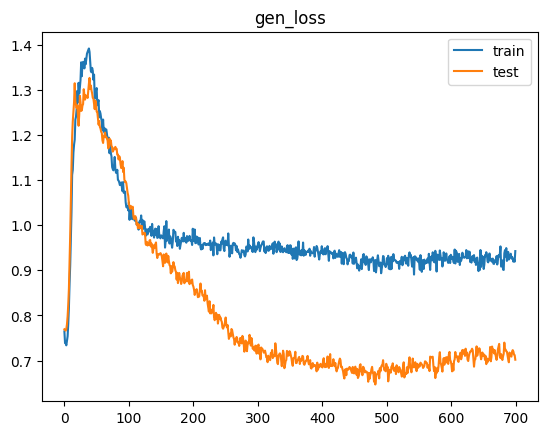

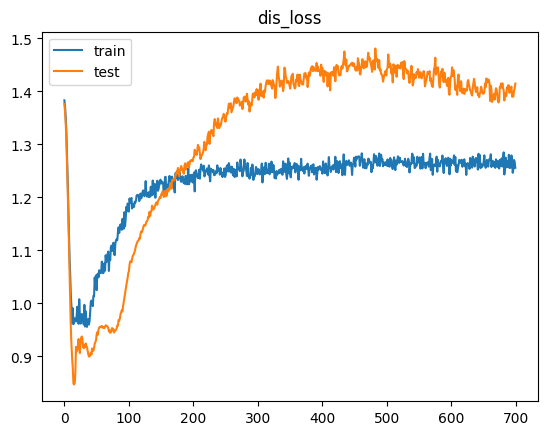

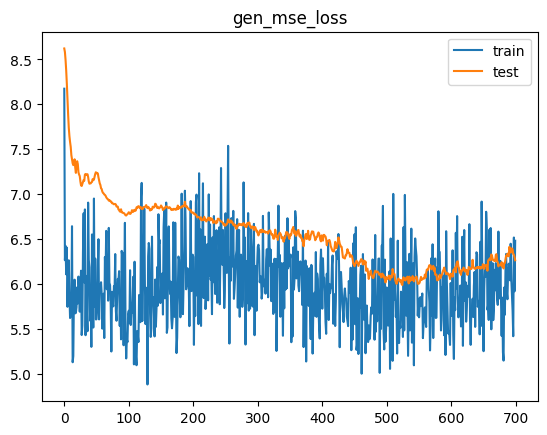

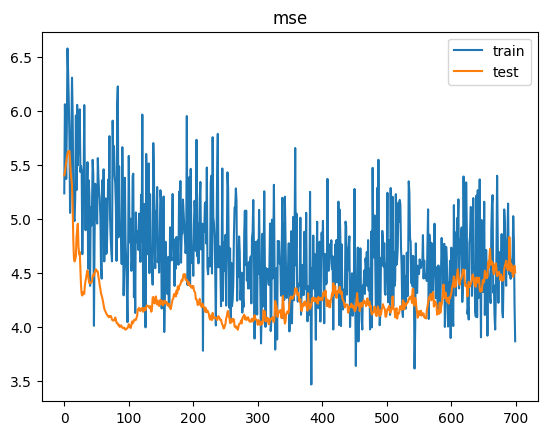

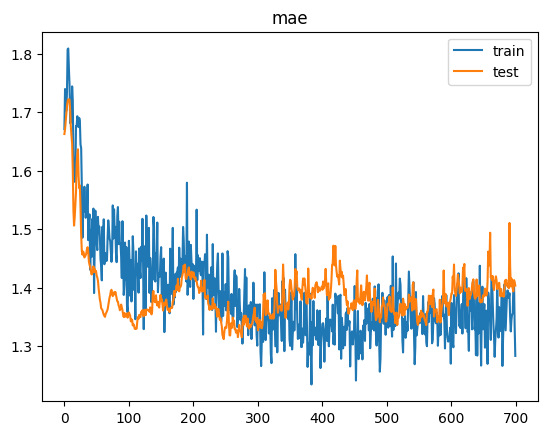

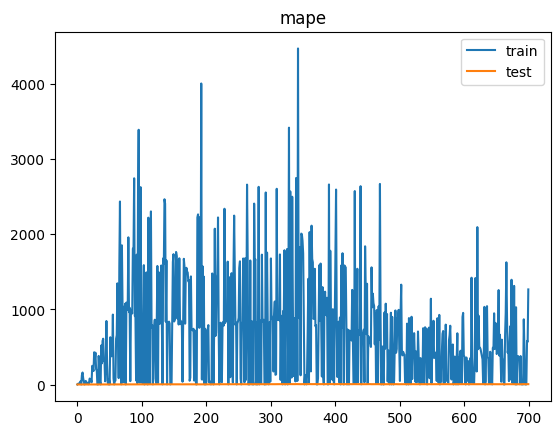

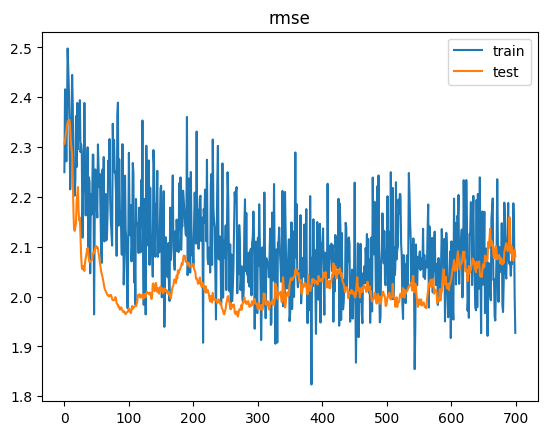

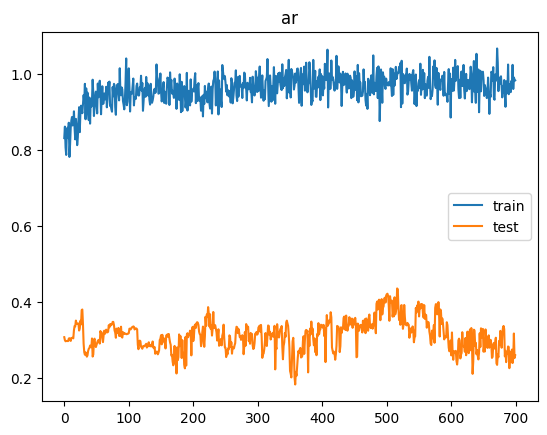

2/2 [==============================] - 0s 3ms/step


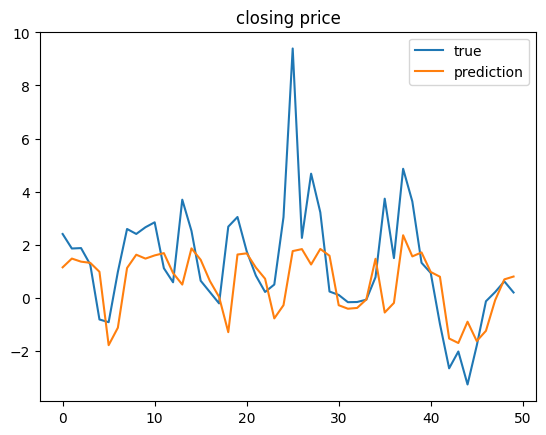

[MSE Baseline] train: 4.61965799567164  test: 3.7469059248471765
Delta time with epochs = 700: 0:04:59.500636
Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 5, 7)]            0         
                                                                 
 simple_rnn_6 (SimpleRNN)    (None, 5, 10)             180       
                                                                 
 batch_normalization_6 (Batc  (None, 5, 10)            40        
 hNormalization)                                                 
                                                                 
 leaky_re_lu_18 (LeakyReLU)  (None, 5, 10)             0         
                                                                 
 dropout_15 (Dropout)        (None, 5, 10)             0         
                                                                 
 simple_rnn_7 (

Time for epoch 52 is 0.4403200149536133 sec Generator Loss: 1.1841111183166504,  Discriminator_loss: 1.065412163734436
Time for epoch 53 is 0.424548864364624 sec Generator Loss: 1.1631890535354614,  Discriminator_loss: 1.1087266206741333
Time for epoch 54 is 0.42529821395874023 sec Generator Loss: 1.159921407699585,  Discriminator_loss: 1.0965135097503662
Time for epoch 55 is 0.4483048915863037 sec Generator Loss: 1.1539111137390137,  Discriminator_loss: 1.0972436666488647
Time for epoch 56 is 0.4319889545440674 sec Generator Loss: 1.1804736852645874,  Discriminator_loss: 1.0786527395248413
Time for epoch 57 is 0.4339313507080078 sec Generator Loss: 1.1909691095352173,  Discriminator_loss: 1.0799827575683594
Time for epoch 58 is 0.4292120933532715 sec Generator Loss: 1.1847560405731201,  Discriminator_loss: 1.0798996686935425
Time for epoch 59 is 0.43409109115600586 sec Generator Loss: 1.1666655540466309,  Discriminator_loss: 1.1013195514678955
Time for epoch 60 is 0.42704296112060547 

Time for epoch 121 is 0.4419841766357422 sec Generator Loss: 0.9784485697746277,  Discriminator_loss: 1.2300763130187988
Time for epoch 122 is 0.4272763729095459 sec Generator Loss: 0.970676064491272,  Discriminator_loss: 1.23344886302948
Time for epoch 123 is 0.41823697090148926 sec Generator Loss: 0.9728496074676514,  Discriminator_loss: 1.238562822341919
Time for epoch 124 is 0.4134654998779297 sec Generator Loss: 0.9793731570243835,  Discriminator_loss: 1.2343569993972778
Time for epoch 125 is 0.41787028312683105 sec Generator Loss: 1.000701904296875,  Discriminator_loss: 1.2068769931793213
Time for epoch 126 is 0.4214937686920166 sec Generator Loss: 0.9654511213302612,  Discriminator_loss: 1.2275866270065308
Time for epoch 127 is 0.45406556129455566 sec Generator Loss: 0.9967506527900696,  Discriminator_loss: 1.2134068012237549
Time for epoch 128 is 0.46292829513549805 sec Generator Loss: 0.9812030792236328,  Discriminator_loss: 1.228232979774475
Time for epoch 129 is 0.4526305198

Time for epoch 189 is 0.4347848892211914 sec Generator Loss: 0.9342695474624634,  Discriminator_loss: 1.2375105619430542
Time for epoch 190 is 0.4365859031677246 sec Generator Loss: 0.9242668151855469,  Discriminator_loss: 1.2621238231658936
Time for epoch 191 is 0.42900633811950684 sec Generator Loss: 0.9189236760139465,  Discriminator_loss: 1.2579684257507324
Time for epoch 192 is 0.45684075355529785 sec Generator Loss: 0.9252075552940369,  Discriminator_loss: 1.2654309272766113
Time for epoch 193 is 0.42746853828430176 sec Generator Loss: 0.9262274503707886,  Discriminator_loss: 1.248341679573059
Time for epoch 194 is 0.4379394054412842 sec Generator Loss: 0.9223824143409729,  Discriminator_loss: 1.2444149255752563
Time for epoch 195 is 0.4317739009857178 sec Generator Loss: 0.9325059652328491,  Discriminator_loss: 1.2635940313339233
Time for epoch 196 is 0.44553279876708984 sec Generator Loss: 0.9172836542129517,  Discriminator_loss: 1.257912278175354
Time for epoch 197 is 0.446512

Time for epoch 257 is 0.5104846954345703 sec Generator Loss: 0.9253407120704651,  Discriminator_loss: 1.2517321109771729
Time for epoch 258 is 0.4596254825592041 sec Generator Loss: 0.9319764971733093,  Discriminator_loss: 1.2530591487884521
Time for epoch 259 is 0.47760963439941406 sec Generator Loss: 0.9166122078895569,  Discriminator_loss: 1.2767188549041748
Time for epoch 260 is 0.4671010971069336 sec Generator Loss: 0.9179848432540894,  Discriminator_loss: 1.2623326778411865
Time for epoch 261 is 0.47886037826538086 sec Generator Loss: 0.926640510559082,  Discriminator_loss: 1.2526328563690186
Time for epoch 262 is 0.4600410461425781 sec Generator Loss: 0.9257988929748535,  Discriminator_loss: 1.264733076095581
Time for epoch 263 is 0.46413516998291016 sec Generator Loss: 0.9114602208137512,  Discriminator_loss: 1.2787290811538696
Time for epoch 264 is 0.5100524425506592 sec Generator Loss: 0.918729841709137,  Discriminator_loss: 1.2636243104934692
Time for epoch 265 is 0.47189331

Time for epoch 325 is 0.4136979579925537 sec Generator Loss: 0.9115452766418457,  Discriminator_loss: 1.2541168928146362
Time for epoch 326 is 0.4186258316040039 sec Generator Loss: 0.9201862215995789,  Discriminator_loss: 1.271606683731079
Time for epoch 327 is 0.4347717761993408 sec Generator Loss: 0.9130610227584839,  Discriminator_loss: 1.2646745443344116
Time for epoch 328 is 0.4592475891113281 sec Generator Loss: 0.9276614785194397,  Discriminator_loss: 1.2557258605957031
Time for epoch 329 is 0.4198920726776123 sec Generator Loss: 0.9303274154663086,  Discriminator_loss: 1.2535655498504639
Time for epoch 330 is 0.41971921920776367 sec Generator Loss: 0.9116455316543579,  Discriminator_loss: 1.2683225870132446
Time for epoch 331 is 0.4062314033508301 sec Generator Loss: 0.945891261100769,  Discriminator_loss: 1.2516127824783325
Time for epoch 332 is 0.436617374420166 sec Generator Loss: 0.9243636131286621,  Discriminator_loss: 1.2691396474838257
Time for epoch 333 is 0.4213929176

Time for epoch 393 is 0.4392552375793457 sec Generator Loss: 0.9129441976547241,  Discriminator_loss: 1.2641538381576538
Time for epoch 394 is 0.3934190273284912 sec Generator Loss: 0.9031965732574463,  Discriminator_loss: 1.2759318351745605
Time for epoch 395 is 0.3941969871520996 sec Generator Loss: 0.9240823984146118,  Discriminator_loss: 1.2654739618301392
Time for epoch 396 is 0.39312124252319336 sec Generator Loss: 0.9059374332427979,  Discriminator_loss: 1.2609766721725464
Time for epoch 397 is 0.39623141288757324 sec Generator Loss: 0.8909898996353149,  Discriminator_loss: 1.277208924293518
Time for epoch 398 is 0.3991115093231201 sec Generator Loss: 0.9204642176628113,  Discriminator_loss: 1.2612022161483765
Time for epoch 399 is 0.40848875045776367 sec Generator Loss: 0.909039318561554,  Discriminator_loss: 1.2623752355575562
Time for epoch 400 is 0.429180383682251 sec Generator Loss: 0.911660373210907,  Discriminator_loss: 1.254340410232544
Time for epoch 401 is 0.4016129970

Time for epoch 461 is 0.41477370262145996 sec Generator Loss: 0.9079564809799194,  Discriminator_loss: 1.2710742950439453
Time for epoch 462 is 0.4434938430786133 sec Generator Loss: 0.9032914042472839,  Discriminator_loss: 1.2705883979797363
Time for epoch 463 is 0.4165065288543701 sec Generator Loss: 0.9155129790306091,  Discriminator_loss: 1.2701109647750854
Time for epoch 464 is 0.4145975112915039 sec Generator Loss: 0.9114151000976562,  Discriminator_loss: 1.2557309865951538
Time for epoch 465 is 0.4441068172454834 sec Generator Loss: 0.8975274562835693,  Discriminator_loss: 1.2736469507217407
Time for epoch 466 is 0.420788049697876 sec Generator Loss: 0.903821587562561,  Discriminator_loss: 1.262465000152588
Time for epoch 467 is 0.4246056079864502 sec Generator Loss: 0.9248790144920349,  Discriminator_loss: 1.2464898824691772
Time for epoch 468 is 0.41837358474731445 sec Generator Loss: 0.9262351393699646,  Discriminator_loss: 1.2613554000854492
Time for epoch 469 is 0.436125278

Time for epoch 529 is 0.40822458267211914 sec Generator Loss: 0.9094651341438293,  Discriminator_loss: 1.2728078365325928
Time for epoch 530 is 0.41239356994628906 sec Generator Loss: 0.9009810090065002,  Discriminator_loss: 1.268091082572937
Time for epoch 531 is 0.40378689765930176 sec Generator Loss: 0.9055125713348389,  Discriminator_loss: 1.2678980827331543
Time for epoch 532 is 0.43305397033691406 sec Generator Loss: 0.9116770029067993,  Discriminator_loss: 1.2726367712020874
Time for epoch 533 is 0.4044215679168701 sec Generator Loss: 0.9162192344665527,  Discriminator_loss: 1.2605180740356445
Time for epoch 534 is 0.4062657356262207 sec Generator Loss: 0.9111132621765137,  Discriminator_loss: 1.2595258951187134
Time for epoch 535 is 0.4208834171295166 sec Generator Loss: 0.9027872681617737,  Discriminator_loss: 1.2708741426467896
Time for epoch 536 is 0.40157246589660645 sec Generator Loss: 0.9180246591567993,  Discriminator_loss: 1.258570671081543
Time for epoch 537 is 0.39507

Time for epoch 597 is 0.4060859680175781 sec Generator Loss: 0.9168250560760498,  Discriminator_loss: 1.2721186876296997
Time for epoch 598 is 0.4389662742614746 sec Generator Loss: 0.924910306930542,  Discriminator_loss: 1.270329236984253
Time for epoch 599 is 0.41437864303588867 sec Generator Loss: 0.9165691137313843,  Discriminator_loss: 1.2783517837524414
Time for epoch 600 is 0.4159708023071289 sec Generator Loss: 0.9112261533737183,  Discriminator_loss: 1.2743794918060303
Time for epoch 601 is 0.4102590084075928 sec Generator Loss: 0.909949004650116,  Discriminator_loss: 1.27091383934021
Time for epoch 602 is 0.4294571876525879 sec Generator Loss: 0.9156829118728638,  Discriminator_loss: 1.265650749206543
Time for epoch 603 is 0.4389774799346924 sec Generator Loss: 0.9022090435028076,  Discriminator_loss: 1.279894232749939
Time for epoch 604 is 0.41103100776672363 sec Generator Loss: 0.9101924300193787,  Discriminator_loss: 1.2673685550689697
Time for epoch 605 is 0.4211237430572

Time for epoch 665 is 0.38630199432373047 sec Generator Loss: 0.9228084683418274,  Discriminator_loss: 1.2618786096572876
Time for epoch 666 is 0.4651474952697754 sec Generator Loss: 0.9096454381942749,  Discriminator_loss: 1.271192193031311
Time for epoch 667 is 0.4389181137084961 sec Generator Loss: 0.9191274642944336,  Discriminator_loss: 1.2816483974456787
Time for epoch 668 is 0.4129455089569092 sec Generator Loss: 0.9159377813339233,  Discriminator_loss: 1.264823079109192
Time for epoch 669 is 0.3931717872619629 sec Generator Loss: 0.9040892124176025,  Discriminator_loss: 1.2788304090499878
Time for epoch 670 is 0.3928985595703125 sec Generator Loss: 0.9065300822257996,  Discriminator_loss: 1.2802824974060059
Time for epoch 671 is 0.39276552200317383 sec Generator Loss: 0.8956546783447266,  Discriminator_loss: 1.2734085321426392
Time for epoch 672 is 0.41120409965515137 sec Generator Loss: 0.9087478518486023,  Discriminator_loss: 1.2619810104370117
Time for epoch 673 is 0.4532797

Time for epoch 733 is 0.5238096714019775 sec Generator Loss: 0.9261653423309326,  Discriminator_loss: 1.2691669464111328
Time for epoch 734 is 0.42151498794555664 sec Generator Loss: 0.8974705338478088,  Discriminator_loss: 1.2673976421356201
Time for epoch 735 is 0.4564781188964844 sec Generator Loss: 0.8886709809303284,  Discriminator_loss: 1.2863816022872925
Time for epoch 736 is 0.5118794441223145 sec Generator Loss: 0.9119988083839417,  Discriminator_loss: 1.277157187461853
Time for epoch 737 is 0.5021004676818848 sec Generator Loss: 0.8843500018119812,  Discriminator_loss: 1.286380410194397
Time for epoch 738 is 0.5182478427886963 sec Generator Loss: 0.8914033770561218,  Discriminator_loss: 1.2766493558883667
Time for epoch 739 is 0.5843501091003418 sec Generator Loss: 0.9119338989257812,  Discriminator_loss: 1.2760889530181885
Time for epoch 740 is 0.5533406734466553 sec Generator Loss: 0.9303654432296753,  Discriminator_loss: 1.2538686990737915
Time for epoch 741 is 0.588867425

Time for epoch 801 is 0.48148179054260254 sec Generator Loss: 0.9007618427276611,  Discriminator_loss: 1.2784035205841064
Time for epoch 802 is 0.510545015335083 sec Generator Loss: 0.9238128066062927,  Discriminator_loss: 1.2749402523040771
Time for epoch 803 is 0.46892213821411133 sec Generator Loss: 0.9176060557365417,  Discriminator_loss: 1.2699875831604004
Time for epoch 804 is 0.4920628070831299 sec Generator Loss: 0.9098552465438843,  Discriminator_loss: 1.2788386344909668
Time for epoch 805 is 0.48352932929992676 sec Generator Loss: 0.909896194934845,  Discriminator_loss: 1.2750135660171509
Time for epoch 806 is 0.47876620292663574 sec Generator Loss: 0.8991587162017822,  Discriminator_loss: 1.2819520235061646
Time for epoch 807 is 0.5234179496765137 sec Generator Loss: 0.8988693952560425,  Discriminator_loss: 1.2877658605575562
Time for epoch 808 is 0.519923210144043 sec Generator Loss: 0.9068341255187988,  Discriminator_loss: 1.2782557010650635
Time for epoch 809 is 0.4759495

Time for epoch 869 is 0.5042810440063477 sec Generator Loss: 0.9146917462348938,  Discriminator_loss: 1.2793419361114502
Time for epoch 870 is 0.5412507057189941 sec Generator Loss: 0.8995164632797241,  Discriminator_loss: 1.2940993309020996
Time for epoch 871 is 0.5851194858551025 sec Generator Loss: 0.9094210863113403,  Discriminator_loss: 1.2750815153121948
Time for epoch 872 is 0.6027770042419434 sec Generator Loss: 0.9084905385971069,  Discriminator_loss: 1.2726234197616577
Time for epoch 873 is 0.6228840351104736 sec Generator Loss: 0.9008350372314453,  Discriminator_loss: 1.2928146123886108
Time for epoch 874 is 0.5376968383789062 sec Generator Loss: 0.9164605736732483,  Discriminator_loss: 1.2796237468719482
Time for epoch 875 is 0.4591965675354004 sec Generator Loss: 0.895850419998169,  Discriminator_loss: 1.2922230958938599
Time for epoch 876 is 0.47995877265930176 sec Generator Loss: 0.8895717859268188,  Discriminator_loss: 1.296067476272583
Time for epoch 877 is 0.436499595

Time for epoch 937 is 0.4211134910583496 sec Generator Loss: 0.8927807807922363,  Discriminator_loss: 1.2955176830291748
Time for epoch 938 is 0.43737149238586426 sec Generator Loss: 0.9049343466758728,  Discriminator_loss: 1.2827078104019165
Time for epoch 939 is 0.4367363452911377 sec Generator Loss: 0.8841569423675537,  Discriminator_loss: 1.2975629568099976
Time for epoch 940 is 0.4714775085449219 sec Generator Loss: 0.8850911855697632,  Discriminator_loss: 1.3006012439727783
Time for epoch 941 is 0.4359726905822754 sec Generator Loss: 0.9017297029495239,  Discriminator_loss: 1.2844278812408447
Time for epoch 942 is 0.4259755611419678 sec Generator Loss: 0.9039196968078613,  Discriminator_loss: 1.293206810951233
Time for epoch 943 is 0.424346923828125 sec Generator Loss: 0.9063388705253601,  Discriminator_loss: 1.2990593910217285
Time for epoch 944 is 0.4310610294342041 sec Generator Loss: 0.8919305801391602,  Discriminator_loss: 1.286733627319336
Time for epoch 945 is 0.4335522651

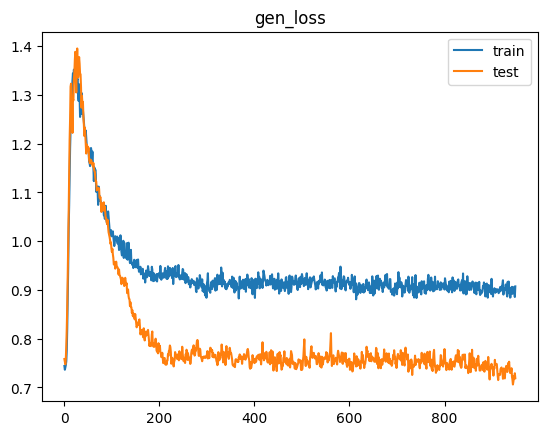

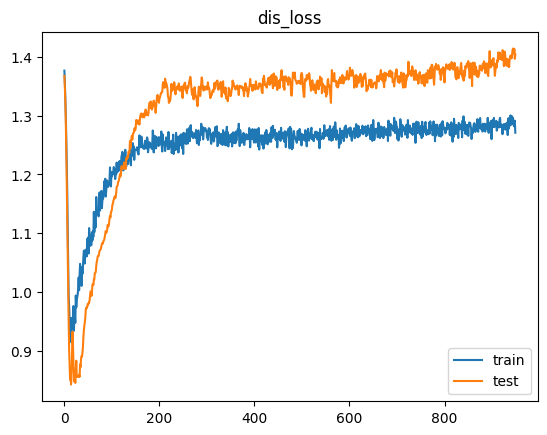

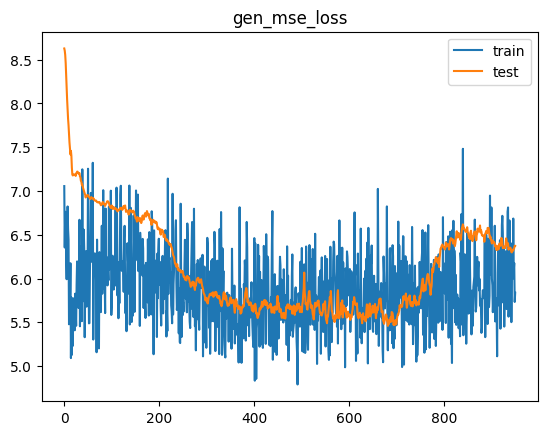

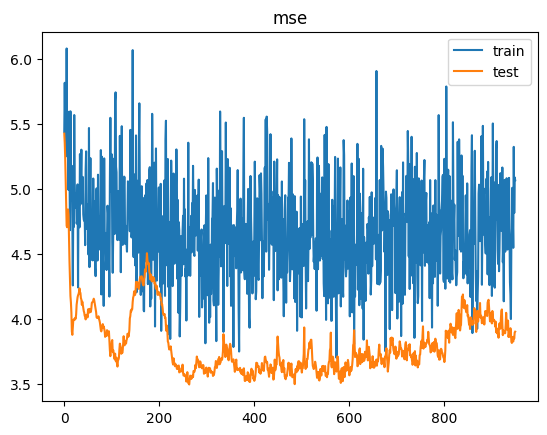

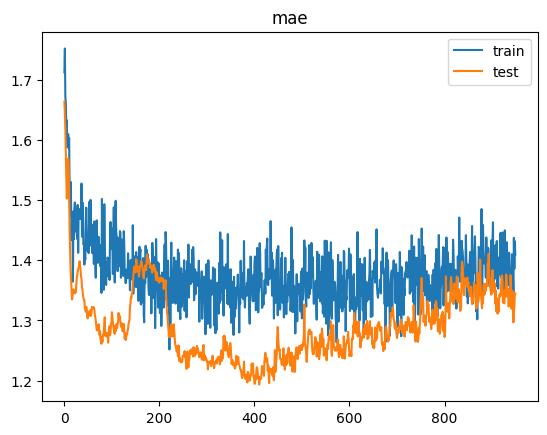

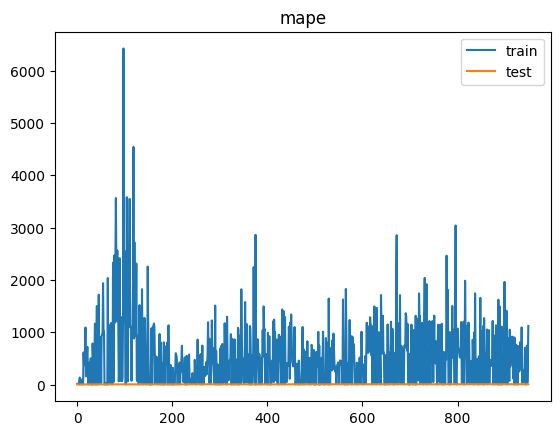

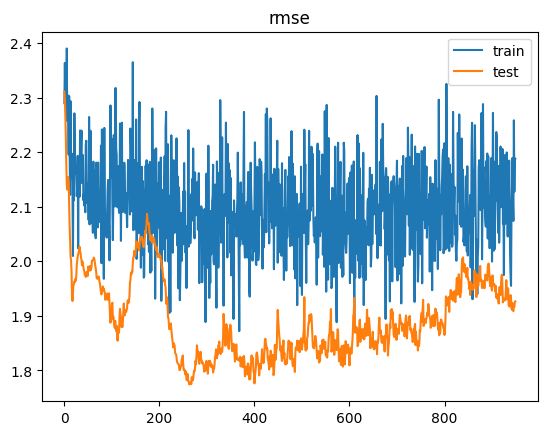

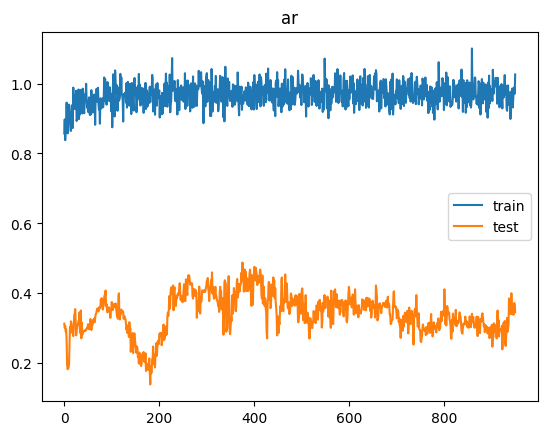

2/2 [==============================] - 0s 3ms/step


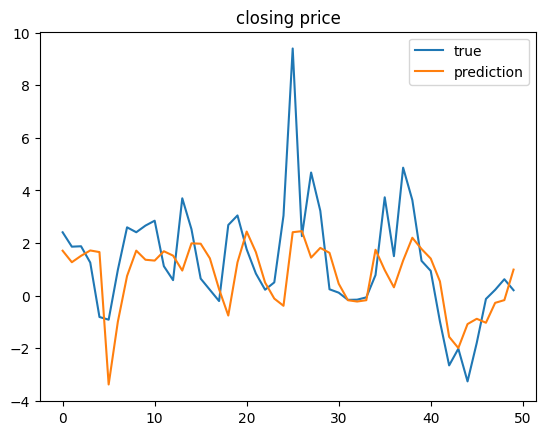

[MSE Baseline] train: 4.5774844559731065  test: 3.7469059248471765
Delta time with epochs = 950: 0:07:15.875632
Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 5, 7)]            0         
                                                                 
 simple_rnn_8 (SimpleRNN)    (None, 5, 10)             180       
                                                                 
 batch_normalization_8 (Batc  (None, 5, 10)            40        
 hNormalization)                                                 
                                                                 
 leaky_re_lu_24 (LeakyReLU)  (None, 5, 10)             0         
                                                                 
 dropout_20 (Dropout)        (None, 5, 10)             0         
                                                                 
 simple_rnn_9

Time for epoch 52 is 0.4210209846496582 sec Generator Loss: 1.4525445699691772,  Discriminator_loss: 0.9206411838531494
Time for epoch 53 is 0.421722412109375 sec Generator Loss: 1.4387938976287842,  Discriminator_loss: 0.9304678440093994
Time for epoch 54 is 0.4220082759857178 sec Generator Loss: 1.4505934715270996,  Discriminator_loss: 0.9301265478134155
Time for epoch 55 is 0.447512149810791 sec Generator Loss: 1.4168864488601685,  Discriminator_loss: 0.9611983299255371
Time for epoch 56 is 0.40661120414733887 sec Generator Loss: 1.4422389268875122,  Discriminator_loss: 0.9690967798233032
Time for epoch 57 is 0.45131731033325195 sec Generator Loss: 1.40695321559906,  Discriminator_loss: 0.9794120788574219
Time for epoch 58 is 0.46105289459228516 sec Generator Loss: 1.4136263132095337,  Discriminator_loss: 0.9829673767089844
Time for epoch 59 is 0.424591064453125 sec Generator Loss: 1.4089363813400269,  Discriminator_loss: 0.9606524705886841
Time for epoch 60 is 0.5217001438140869 se

In [ ]:
for epochs in [200, 450, 700, 950]:
    start_time = datetime.datetime.now()
    df = add_Ma(df)
    data_gen_train, data_gen_test = get_gen_train_test(df, n_sequence, n_batch)

    generator = make_generator_model(n_sequence, n_features)
    discriminator=make_discriminator_model(n_features)

    learning_rate=1e-4
    generator_optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.5)
    discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.5)

    @tf.function
    def train_step(sequences, sequences_end):
      return train_step_def(sequences, sequences_end)

    @tf.function
    def test_step(sequences, sequences_end):
      return test_step_def(sequences, sequences_end)

    checkpoint_dir = './training_checkpoints'+stock_code
    checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
    checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                     discriminator_optimizer=discriminator_optimizer,
                                     generator=generator,
                                     discriminator=discriminator)

    history, history_val = train(data_gen_train, data_gen_test, epochs)

    plot_history(history, history_val)
    plot_frame(*data_gen_test[0], generator)

    print("[MSE Baseline] train:",mean_squared_error(data_gen_train)," test:", mean_squared_error(data_gen_test))
    now = datetime.datetime.now()
    delta = now - start_time
    print("Delta time with epochs = {0}:".format(epochs), delta)
    generator.save("rnn_ffnn_epochs_{0}.h5".format(epochs))

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 5, 7)]            0         
                                                                 
 simple_rnn (SimpleRNN)      (None, 5, 10)             180       
                                                                 
 batch_normalization (BatchN  (None, 5, 10)            40        
 ormalization)                                                   
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 5, 10)             0         
                                                                 
 dropout (Dropout)           (None, 5, 10)             0         
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 10)                210       
                                                             

Time for epoch 53 is 0.3748743534088135 sec Generator Loss: 1.404013991355896,  Discriminator_loss: 0.9569727182388306
Time for epoch 54 is 0.38942980766296387 sec Generator Loss: 1.3627310991287231,  Discriminator_loss: 0.9768753051757812
Time for epoch 55 is 0.3708221912384033 sec Generator Loss: 1.3752038478851318,  Discriminator_loss: 0.9587587118148804
Time for epoch 56 is 0.3731811046600342 sec Generator Loss: 1.3364956378936768,  Discriminator_loss: 0.9918667078018188
Time for epoch 57 is 0.37314558029174805 sec Generator Loss: 1.3271762132644653,  Discriminator_loss: 1.003617286682129
Time for epoch 58 is 0.371077299118042 sec Generator Loss: 1.378955364227295,  Discriminator_loss: 0.9801607728004456
Time for epoch 59 is 0.3725602626800537 sec Generator Loss: 1.379422664642334,  Discriminator_loss: 0.9643089175224304
Time for epoch 60 is 0.3700544834136963 sec Generator Loss: 1.376241683959961,  Discriminator_loss: 0.9824484586715698
Time for epoch 61 is 0.3732612133026123 sec 

Time for epoch 122 is 0.3629941940307617 sec Generator Loss: 1.1248406171798706,  Discriminator_loss: 1.1356414556503296
Time for epoch 123 is 0.4063115119934082 sec Generator Loss: 1.1219769716262817,  Discriminator_loss: 1.1531733274459839
Time for epoch 124 is 0.3634817600250244 sec Generator Loss: 1.1196871995925903,  Discriminator_loss: 1.1624165773391724
Time for epoch 125 is 0.40764760971069336 sec Generator Loss: 1.0994579792022705,  Discriminator_loss: 1.1548460721969604
Time for epoch 126 is 0.39583635330200195 sec Generator Loss: 1.0943294763565063,  Discriminator_loss: 1.168831706047058
Time for epoch 127 is 0.4112379550933838 sec Generator Loss: 1.0951268672943115,  Discriminator_loss: 1.1704009771347046
Time for epoch 128 is 0.36568331718444824 sec Generator Loss: 1.0896273851394653,  Discriminator_loss: 1.1479401588439941
Time for epoch 129 is 0.36978983879089355 sec Generator Loss: 1.0907044410705566,  Discriminator_loss: 1.168177843093872
Time for epoch 130 is 0.386931

Time for epoch 190 is 0.37119388580322266 sec Generator Loss: 1.024185299873352,  Discriminator_loss: 1.230744481086731
Time for epoch 191 is 0.3840470314025879 sec Generator Loss: 0.9866983294487,  Discriminator_loss: 1.2509751319885254
Time for epoch 192 is 0.3855581283569336 sec Generator Loss: 0.9779825806617737,  Discriminator_loss: 1.248628854751587
Time for epoch 193 is 0.37355852127075195 sec Generator Loss: 0.9813982248306274,  Discriminator_loss: 1.240824818611145
Time for epoch 194 is 0.36301493644714355 sec Generator Loss: 0.9796220064163208,  Discriminator_loss: 1.2316861152648926
Time for epoch 195 is 0.36495280265808105 sec Generator Loss: 0.9703987836837769,  Discriminator_loss: 1.2641810178756714
Time for epoch 196 is 0.4388151168823242 sec Generator Loss: 0.9881802201271057,  Discriminator_loss: 1.247085452079773
Time for epoch 197 is 0.3714921474456787 sec Generator Loss: 0.9729634523391724,  Discriminator_loss: 1.2369266748428345
Time for epoch 198 is 0.364157915115

Time for epoch 258 is 0.4029526710510254 sec Generator Loss: 0.9549784064292908,  Discriminator_loss: 1.2432881593704224
Time for epoch 259 is 0.3964571952819824 sec Generator Loss: 0.9610556960105896,  Discriminator_loss: 1.2552701234817505
Time for epoch 260 is 0.367603063583374 sec Generator Loss: 0.9450122714042664,  Discriminator_loss: 1.259156584739685
Time for epoch 261 is 0.3628687858581543 sec Generator Loss: 0.9314722418785095,  Discriminator_loss: 1.2794439792633057
Time for epoch 262 is 0.37282752990722656 sec Generator Loss: 0.9399975538253784,  Discriminator_loss: 1.255301594734192
Time for epoch 263 is 0.3672804832458496 sec Generator Loss: 0.9283730387687683,  Discriminator_loss: 1.274783730506897
Time for epoch 264 is 0.38352322578430176 sec Generator Loss: 0.934813380241394,  Discriminator_loss: 1.2738916873931885
Time for epoch 265 is 0.36243462562561035 sec Generator Loss: 0.932750940322876,  Discriminator_loss: 1.2614381313323975
Time for epoch 266 is 0.36135196685

Time for epoch 326 is 0.4120187759399414 sec Generator Loss: 0.9162376523017883,  Discriminator_loss: 1.2662564516067505
Time for epoch 327 is 0.3896477222442627 sec Generator Loss: 0.9125069975852966,  Discriminator_loss: 1.2707477807998657
Time for epoch 328 is 0.3740088939666748 sec Generator Loss: 0.9348511695861816,  Discriminator_loss: 1.2530893087387085
Time for epoch 329 is 0.37603759765625 sec Generator Loss: 0.9274556636810303,  Discriminator_loss: 1.2680925130844116
Time for epoch 330 is 0.37312912940979004 sec Generator Loss: 0.9256429076194763,  Discriminator_loss: 1.2531087398529053
Time for epoch 331 is 0.3771939277648926 sec Generator Loss: 0.933665931224823,  Discriminator_loss: 1.2697676420211792
Time for epoch 332 is 0.5960562229156494 sec Generator Loss: 0.920792818069458,  Discriminator_loss: 1.2724640369415283
Time for epoch 333 is 0.40444326400756836 sec Generator Loss: 0.9111687541007996,  Discriminator_loss: 1.2806302309036255
Time for epoch 334 is 0.3678510189

Time for epoch 394 is 0.426926851272583 sec Generator Loss: 0.9240478277206421,  Discriminator_loss: 1.2650469541549683
Time for epoch 395 is 0.3903026580810547 sec Generator Loss: 0.9161099195480347,  Discriminator_loss: 1.2690255641937256
Time for epoch 396 is 0.3969697952270508 sec Generator Loss: 0.9048826694488525,  Discriminator_loss: 1.272481083869934
Time for epoch 397 is 0.3895285129547119 sec Generator Loss: 0.9276962876319885,  Discriminator_loss: 1.2590205669403076
Time for epoch 398 is 0.3960378170013428 sec Generator Loss: 0.9176920652389526,  Discriminator_loss: 1.271052598953247
Time for epoch 399 is 0.3829925060272217 sec Generator Loss: 0.9204809069633484,  Discriminator_loss: 1.264925479888916
Time for epoch 400 is 0.38562440872192383 sec Generator Loss: 0.8979973196983337,  Discriminator_loss: 1.267459511756897
Time for epoch 401 is 0.3846299648284912 sec Generator Loss: 0.9166901707649231,  Discriminator_loss: 1.270359754562378
Time for epoch 402 is 0.3794190883636

Time for epoch 462 is 0.4699418544769287 sec Generator Loss: 0.912956953048706,  Discriminator_loss: 1.2783809900283813
Time for epoch 463 is 0.47460436820983887 sec Generator Loss: 0.9077027440071106,  Discriminator_loss: 1.2703430652618408
Time for epoch 464 is 0.4664428234100342 sec Generator Loss: 0.8883894085884094,  Discriminator_loss: 1.2793163061141968
Time for epoch 465 is 0.47747063636779785 sec Generator Loss: 0.9246012568473816,  Discriminator_loss: 1.257267713546753
Time for epoch 466 is 0.42731308937072754 sec Generator Loss: 0.9279150366783142,  Discriminator_loss: 1.2565970420837402
Time for epoch 467 is 0.435901403427124 sec Generator Loss: 0.9285454154014587,  Discriminator_loss: 1.2511441707611084
Time for epoch 468 is 0.44556570053100586 sec Generator Loss: 0.910093367099762,  Discriminator_loss: 1.26612389087677
Time for epoch 469 is 0.42543840408325195 sec Generator Loss: 0.9219908118247986,  Discriminator_loss: 1.2637114524841309
Time for epoch 470 is 0.443032026

Time for epoch 530 is 0.4427206516265869 sec Generator Loss: 0.9180201888084412,  Discriminator_loss: 1.2820788621902466
Time for epoch 531 is 0.4295032024383545 sec Generator Loss: 0.9245365858078003,  Discriminator_loss: 1.2539540529251099
Time for epoch 532 is 0.43130064010620117 sec Generator Loss: 0.9355095624923706,  Discriminator_loss: 1.2539732456207275
Time for epoch 533 is 0.4326338768005371 sec Generator Loss: 0.9323828220367432,  Discriminator_loss: 1.244676113128662
Time for epoch 534 is 0.42789316177368164 sec Generator Loss: 0.9465212821960449,  Discriminator_loss: 1.24522066116333
Time for epoch 535 is 0.4341299533843994 sec Generator Loss: 0.9191135168075562,  Discriminator_loss: 1.2713134288787842
Time for epoch 536 is 0.425264835357666 sec Generator Loss: 0.9458924531936646,  Discriminator_loss: 1.2475858926773071
Time for epoch 537 is 0.4525308609008789 sec Generator Loss: 0.9267162680625916,  Discriminator_loss: 1.2601323127746582
Time for epoch 538 is 0.4304635524

Time for epoch 598 is 0.4758567810058594 sec Generator Loss: 0.914935827255249,  Discriminator_loss: 1.2564336061477661
Time for epoch 599 is 0.455486536026001 sec Generator Loss: 0.9276828765869141,  Discriminator_loss: 1.2613250017166138
Time for epoch 600 is 0.4812891483306885 sec Generator Loss: 0.9282748699188232,  Discriminator_loss: 1.2588015794754028
Time for epoch 601 is 0.46748852729797363 sec Generator Loss: 0.9198969006538391,  Discriminator_loss: 1.255647897720337
Time for epoch 602 is 0.49570798873901367 sec Generator Loss: 0.946944534778595,  Discriminator_loss: 1.2258589267730713
Time for epoch 603 is 0.48401546478271484 sec Generator Loss: 0.9404025673866272,  Discriminator_loss: 1.250535011291504
Time for epoch 604 is 0.4586210250854492 sec Generator Loss: 0.9462706446647644,  Discriminator_loss: 1.236319899559021
Time for epoch 605 is 0.445065975189209 sec Generator Loss: 0.9428921937942505,  Discriminator_loss: 1.2514886856079102
Time for epoch 606 is 0.430497407913

Time for epoch 666 is 0.43976831436157227 sec Generator Loss: 0.9510953426361084,  Discriminator_loss: 1.2419315576553345
Time for epoch 667 is 0.44029927253723145 sec Generator Loss: 0.950619101524353,  Discriminator_loss: 1.243356466293335
Time for epoch 668 is 0.4308207035064697 sec Generator Loss: 0.9469550251960754,  Discriminator_loss: 1.2481855154037476
Time for epoch 669 is 0.43816399574279785 sec Generator Loss: 0.9437039494514465,  Discriminator_loss: 1.2632787227630615
Time for epoch 670 is 0.43022990226745605 sec Generator Loss: 0.9438318014144897,  Discriminator_loss: 1.2659187316894531
Time for epoch 671 is 0.4331827163696289 sec Generator Loss: 0.9461846947669983,  Discriminator_loss: 1.2391703128814697
Time for epoch 672 is 0.4403386116027832 sec Generator Loss: 0.9271829724311829,  Discriminator_loss: 1.262258768081665
Time for epoch 673 is 0.43024444580078125 sec Generator Loss: 0.9461464881896973,  Discriminator_loss: 1.2411695718765259
Time for epoch 674 is 0.440185

Time for epoch 734 is 0.4117856025695801 sec Generator Loss: 0.9393022656440735,  Discriminator_loss: 1.2548569440841675
Time for epoch 735 is 0.40428686141967773 sec Generator Loss: 0.9406947493553162,  Discriminator_loss: 1.2560714483261108
Time for epoch 736 is 0.45393943786621094 sec Generator Loss: 0.9351083636283875,  Discriminator_loss: 1.2524023056030273
Time for epoch 737 is 0.43630290031433105 sec Generator Loss: 0.9405117630958557,  Discriminator_loss: 1.249371886253357
Time for epoch 738 is 0.4329512119293213 sec Generator Loss: 0.9422866106033325,  Discriminator_loss: 1.26085364818573
Time for epoch 739 is 0.39298176765441895 sec Generator Loss: 0.9441522359848022,  Discriminator_loss: 1.2625356912612915
Time for epoch 740 is 0.3712430000305176 sec Generator Loss: 0.9495148062705994,  Discriminator_loss: 1.2603418827056885
Time for epoch 741 is 0.3804597854614258 sec Generator Loss: 0.9371683597564697,  Discriminator_loss: 1.2376887798309326
Time for epoch 742 is 0.3750317

Time for epoch 802 is 0.4252958297729492 sec Generator Loss: 0.9419550895690918,  Discriminator_loss: 1.2704591751098633
Time for epoch 803 is 0.42188429832458496 sec Generator Loss: 0.927343487739563,  Discriminator_loss: 1.2542102336883545
Time for epoch 804 is 0.40209078788757324 sec Generator Loss: 0.9526951313018799,  Discriminator_loss: 1.2452430725097656
Time for epoch 805 is 0.3945729732513428 sec Generator Loss: 0.957530677318573,  Discriminator_loss: 1.237928032875061
Time for epoch 806 is 0.4010050296783447 sec Generator Loss: 0.9444925785064697,  Discriminator_loss: 1.2608942985534668
Time for epoch 807 is 0.391542911529541 sec Generator Loss: 0.9556975364685059,  Discriminator_loss: 1.2395250797271729
Time for epoch 808 is 0.39627647399902344 sec Generator Loss: 0.9635410904884338,  Discriminator_loss: 1.2557305097579956
Time for epoch 809 is 0.44472408294677734 sec Generator Loss: 0.92715984582901,  Discriminator_loss: 1.2614666223526
Time for epoch 810 is 0.3942592144012

Time for epoch 870 is 0.3898742198944092 sec Generator Loss: 0.9462469816207886,  Discriminator_loss: 1.2427644729614258
Time for epoch 871 is 0.40329504013061523 sec Generator Loss: 0.9610079526901245,  Discriminator_loss: 1.246336817741394
Time for epoch 872 is 0.41438984870910645 sec Generator Loss: 0.9526702165603638,  Discriminator_loss: 1.2489681243896484
Time for epoch 873 is 0.4938175678253174 sec Generator Loss: 0.9424338340759277,  Discriminator_loss: 1.2540861368179321
Time for epoch 874 is 0.4553837776184082 sec Generator Loss: 0.9600853323936462,  Discriminator_loss: 1.2457668781280518
Time for epoch 875 is 0.5372488498687744 sec Generator Loss: 0.9341121315956116,  Discriminator_loss: 1.2547608613967896
Time for epoch 876 is 0.524268627166748 sec Generator Loss: 0.9289187788963318,  Discriminator_loss: 1.2645795345306396
Time for epoch 877 is 0.5346050262451172 sec Generator Loss: 0.9437023401260376,  Discriminator_loss: 1.2549501657485962
Time for epoch 878 is 0.49413752

Time for epoch 938 is 0.4458732604980469 sec Generator Loss: 0.9442724585533142,  Discriminator_loss: 1.2495197057724
Time for epoch 939 is 0.45854663848876953 sec Generator Loss: 0.954418420791626,  Discriminator_loss: 1.2531168460845947
Time for epoch 940 is 0.5001335144042969 sec Generator Loss: 0.9460839033126831,  Discriminator_loss: 1.255029559135437
Time for epoch 941 is 0.4525744915008545 sec Generator Loss: 0.953569769859314,  Discriminator_loss: 1.2313305139541626
Time for epoch 942 is 0.43903112411499023 sec Generator Loss: 0.9642775058746338,  Discriminator_loss: 1.2443310022354126
Time for epoch 943 is 0.4040224552154541 sec Generator Loss: 0.9618890881538391,  Discriminator_loss: 1.242369294166565
Time for epoch 944 is 0.44890880584716797 sec Generator Loss: 0.9706771373748779,  Discriminator_loss: 1.2435986995697021
Time for epoch 945 is 0.48914051055908203 sec Generator Loss: 0.9411398768424988,  Discriminator_loss: 1.2552998065948486
Time for epoch 946 is 0.41856503486

Time for epoch 1006 is 0.40693235397338867 sec Generator Loss: 0.944732129573822,  Discriminator_loss: 1.2569419145584106
Time for epoch 1007 is 0.40763401985168457 sec Generator Loss: 0.947041392326355,  Discriminator_loss: 1.2581887245178223
Time for epoch 1008 is 0.4686853885650635 sec Generator Loss: 0.9440382122993469,  Discriminator_loss: 1.2438080310821533
Time for epoch 1009 is 0.4270360469818115 sec Generator Loss: 0.9320590496063232,  Discriminator_loss: 1.2610706090927124
Time for epoch 1010 is 0.44289183616638184 sec Generator Loss: 0.9622353911399841,  Discriminator_loss: 1.2434499263763428
Time for epoch 1011 is 0.40809202194213867 sec Generator Loss: 0.9528477191925049,  Discriminator_loss: 1.2486231327056885
Time for epoch 1012 is 0.42006540298461914 sec Generator Loss: 0.9359428882598877,  Discriminator_loss: 1.260327935218811
Time for epoch 1013 is 0.4887723922729492 sec Generator Loss: 0.9590156078338623,  Discriminator_loss: 1.2403172254562378
Time for epoch 1014 is

Time for epoch 1074 is 0.4635810852050781 sec Generator Loss: 0.9504711031913757,  Discriminator_loss: 1.2625148296356201
Time for epoch 1075 is 0.4296762943267822 sec Generator Loss: 0.9582074880599976,  Discriminator_loss: 1.243635892868042
Time for epoch 1076 is 0.4416084289550781 sec Generator Loss: 0.9709259867668152,  Discriminator_loss: 1.240332841873169
Time for epoch 1077 is 0.4262669086456299 sec Generator Loss: 0.9588465690612793,  Discriminator_loss: 1.2479687929153442
Time for epoch 1078 is 0.4496128559112549 sec Generator Loss: 0.9524752497673035,  Discriminator_loss: 1.252901554107666
Time for epoch 1079 is 0.4604775905609131 sec Generator Loss: 0.9537826776504517,  Discriminator_loss: 1.2453312873840332
Time for epoch 1080 is 0.44835805892944336 sec Generator Loss: 0.9400486350059509,  Discriminator_loss: 1.266292691230774
Time for epoch 1081 is 0.42978882789611816 sec Generator Loss: 0.9512476921081543,  Discriminator_loss: 1.2473262548446655
Time for epoch 1082 is 0.4

Time for epoch 1142 is 0.3776569366455078 sec Generator Loss: 0.9619153141975403,  Discriminator_loss: 1.2462356090545654
Time for epoch 1143 is 0.3968377113342285 sec Generator Loss: 0.9788944721221924,  Discriminator_loss: 1.2394754886627197
Time for epoch 1144 is 0.42513370513916016 sec Generator Loss: 0.9471737146377563,  Discriminator_loss: 1.2704445123672485
Time for epoch 1145 is 0.3879268169403076 sec Generator Loss: 0.9446566104888916,  Discriminator_loss: 1.2577078342437744
Time for epoch 1146 is 0.42391300201416016 sec Generator Loss: 0.9312000870704651,  Discriminator_loss: 1.2636278867721558
Time for epoch 1147 is 0.38158249855041504 sec Generator Loss: 0.9545941352844238,  Discriminator_loss: 1.256070852279663
Time for epoch 1148 is 0.4011540412902832 sec Generator Loss: 0.9408215880393982,  Discriminator_loss: 1.2554742097854614
Time for epoch 1149 is 0.3878202438354492 sec Generator Loss: 0.9605297446250916,  Discriminator_loss: 1.2450436353683472
Time for epoch 1150 is

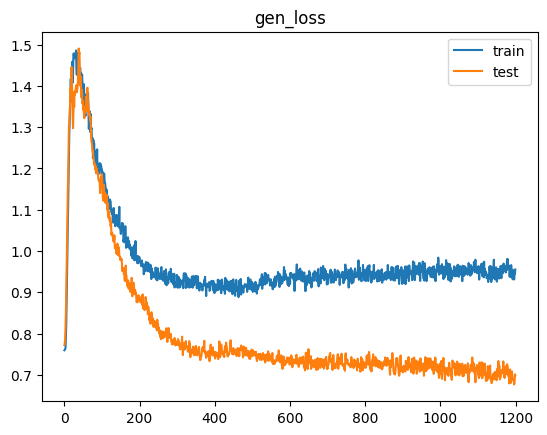

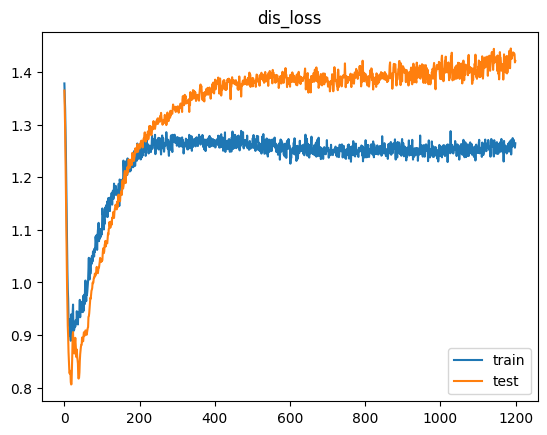

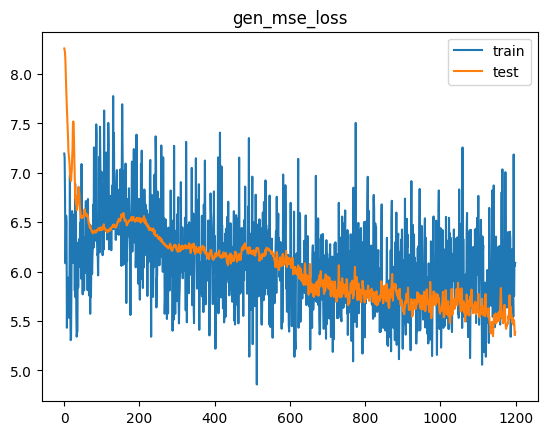

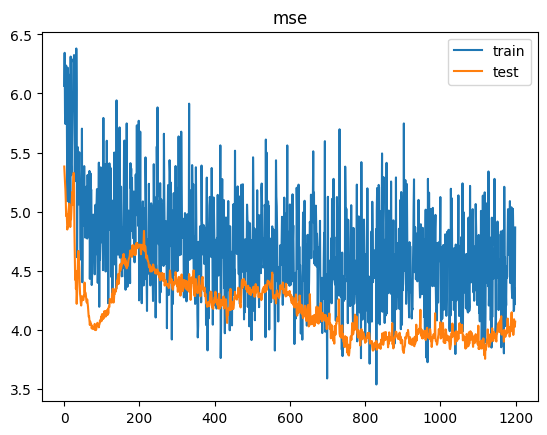

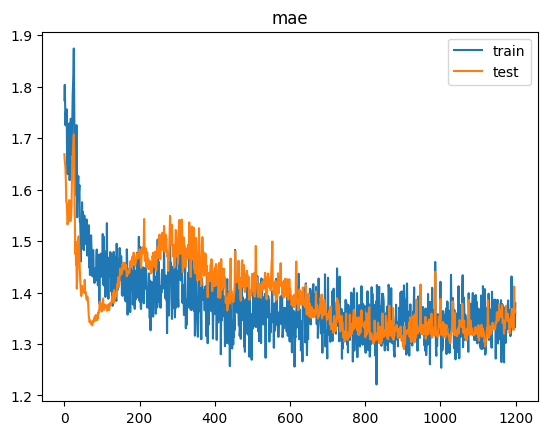

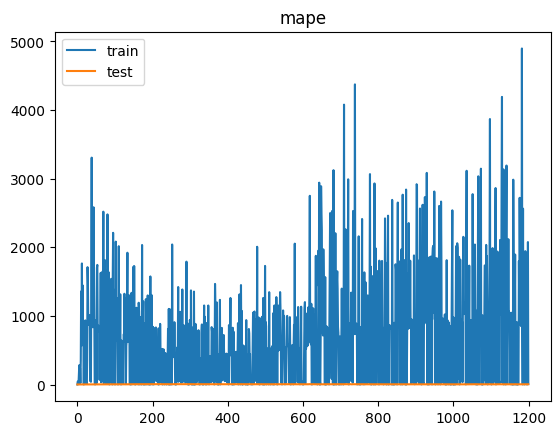

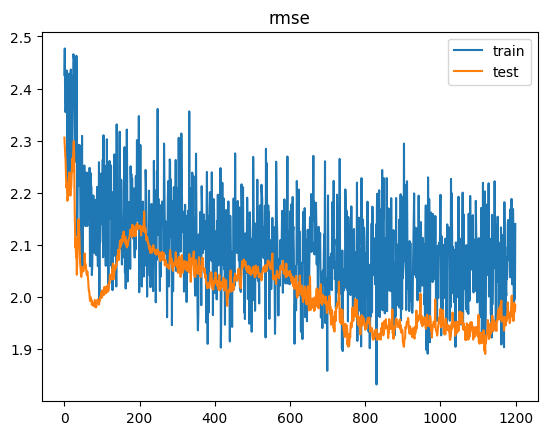

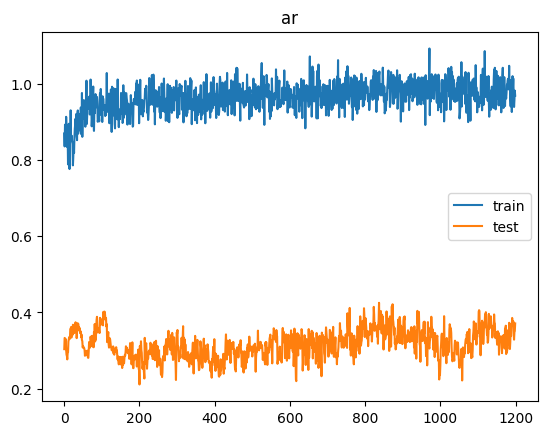

2/2 [==============================] - 0s 2ms/step


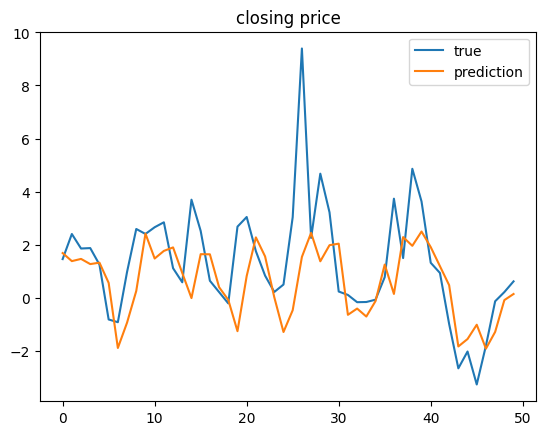

[MSE Baseline] train: 4.80246854186539  test: 3.868181586758766
Delta time with epochs = 1200: 0:08:37.590366
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 5, 7)]            0         
                                                                 
 simple_rnn_2 (SimpleRNN)    (None, 5, 10)             180       
                                                                 
 batch_normalization_2 (Batc  (None, 5, 10)            40        
 hNormalization)                                                 
                                                                 
 leaky_re_lu_6 (LeakyReLU)   (None, 5, 10)             0         
                                                                 
 dropout_5 (Dropout)         (None, 5, 10)             0         
                                                                 
 simple_rnn_3 (

Time for epoch 52 is 0.39765095710754395 sec Generator Loss: 1.2491360902786255,  Discriminator_loss: 1.0069671869277954
Time for epoch 53 is 0.39824390411376953 sec Generator Loss: 1.2379425764083862,  Discriminator_loss: 1.0130809545516968
Time for epoch 54 is 0.3909265995025635 sec Generator Loss: 1.2209278345108032,  Discriminator_loss: 1.0298502445220947
Time for epoch 55 is 0.4008471965789795 sec Generator Loss: 1.2151437997817993,  Discriminator_loss: 1.0430117845535278
Time for epoch 56 is 0.3859860897064209 sec Generator Loss: 1.2267355918884277,  Discriminator_loss: 1.0349297523498535
Time for epoch 57 is 0.39634275436401367 sec Generator Loss: 1.2321430444717407,  Discriminator_loss: 1.0445911884307861
Time for epoch 58 is 0.39588475227355957 sec Generator Loss: 1.1955833435058594,  Discriminator_loss: 1.0557359457015991
Time for epoch 59 is 0.39760684967041016 sec Generator Loss: 1.1698020696640015,  Discriminator_loss: 1.0965496301651
Time for epoch 60 is 0.408266782760620

Time for epoch 121 is 0.3863222599029541 sec Generator Loss: 0.9783931970596313,  Discriminator_loss: 1.2196546792984009
Time for epoch 122 is 0.3935847282409668 sec Generator Loss: 0.9693759679794312,  Discriminator_loss: 1.2292346954345703
Time for epoch 123 is 0.39547061920166016 sec Generator Loss: 0.9602839350700378,  Discriminator_loss: 1.2358405590057373
Time for epoch 124 is 0.3859703540802002 sec Generator Loss: 0.9666681885719299,  Discriminator_loss: 1.244678020477295
Time for epoch 125 is 0.4077262878417969 sec Generator Loss: 0.9786268472671509,  Discriminator_loss: 1.2198187112808228
Time for epoch 126 is 0.3823697566986084 sec Generator Loss: 0.9931200742721558,  Discriminator_loss: 1.2034813165664673
Time for epoch 127 is 0.3922138214111328 sec Generator Loss: 0.9660893082618713,  Discriminator_loss: 1.212478518486023
Time for epoch 128 is 0.3965260982513428 sec Generator Loss: 0.972946286201477,  Discriminator_loss: 1.2360002994537354
Time for epoch 129 is 0.3831696510

Time for epoch 189 is 0.39148497581481934 sec Generator Loss: 0.9759365320205688,  Discriminator_loss: 1.232932686805725
Time for epoch 190 is 0.3907642364501953 sec Generator Loss: 0.9684788584709167,  Discriminator_loss: 1.2251665592193604
Time for epoch 191 is 0.39462709426879883 sec Generator Loss: 0.9681459665298462,  Discriminator_loss: 1.2272958755493164
Time for epoch 192 is 0.3851616382598877 sec Generator Loss: 0.9763686656951904,  Discriminator_loss: 1.2292537689208984
Time for epoch 193 is 0.39134836196899414 sec Generator Loss: 0.9522605538368225,  Discriminator_loss: 1.2346069812774658
Time for epoch 194 is 0.3932816982269287 sec Generator Loss: 0.9803597927093506,  Discriminator_loss: 1.231286883354187
Time for epoch 195 is 0.3912348747253418 sec Generator Loss: 0.9684642553329468,  Discriminator_loss: 1.2258973121643066
Time for epoch 196 is 0.39255785942077637 sec Generator Loss: 0.9604499340057373,  Discriminator_loss: 1.233371615409851
Time for epoch 197 is 0.3950474

Time for epoch 257 is 0.39940476417541504 sec Generator Loss: 0.9222927093505859,  Discriminator_loss: 1.2639756202697754
Time for epoch 258 is 0.420086145401001 sec Generator Loss: 0.9527567028999329,  Discriminator_loss: 1.2401094436645508
Time for epoch 259 is 0.4003746509552002 sec Generator Loss: 0.9266530871391296,  Discriminator_loss: 1.2604576349258423
Time for epoch 260 is 0.40271949768066406 sec Generator Loss: 0.9235433340072632,  Discriminator_loss: 1.265584111213684
Time for epoch 261 is 0.38931798934936523 sec Generator Loss: 0.9349511861801147,  Discriminator_loss: 1.2579338550567627
Time for epoch 262 is 0.3921504020690918 sec Generator Loss: 0.9144969582557678,  Discriminator_loss: 1.266602635383606
Time for epoch 263 is 0.39554786682128906 sec Generator Loss: 0.9401038885116577,  Discriminator_loss: 1.2315082550048828
Time for epoch 264 is 0.3968667984008789 sec Generator Loss: 0.9383016228675842,  Discriminator_loss: 1.2517930269241333
Time for epoch 265 is 0.4034428

Time for epoch 325 is 0.4487624168395996 sec Generator Loss: 0.9212932586669922,  Discriminator_loss: 1.265434980392456
Time for epoch 326 is 0.4428093433380127 sec Generator Loss: 0.9384464025497437,  Discriminator_loss: 1.2347010374069214
Time for epoch 327 is 0.43093204498291016 sec Generator Loss: 0.9227004647254944,  Discriminator_loss: 1.2527825832366943
Time for epoch 328 is 0.4590599536895752 sec Generator Loss: 0.9106393456459045,  Discriminator_loss: 1.2524504661560059
Time for epoch 329 is 0.4282073974609375 sec Generator Loss: 0.9160783886909485,  Discriminator_loss: 1.2783620357513428
Time for epoch 330 is 0.41274142265319824 sec Generator Loss: 0.9281203150749207,  Discriminator_loss: 1.2542163133621216
Time for epoch 331 is 0.4081425666809082 sec Generator Loss: 0.9212063550949097,  Discriminator_loss: 1.2665116786956787
Time for epoch 332 is 0.40042662620544434 sec Generator Loss: 0.9159567356109619,  Discriminator_loss: 1.2601710557937622
Time for epoch 333 is 0.417974

Time for epoch 393 is 0.4014296531677246 sec Generator Loss: 0.9171197414398193,  Discriminator_loss: 1.249646544456482
Time for epoch 394 is 0.4079740047454834 sec Generator Loss: 0.9293519258499146,  Discriminator_loss: 1.263558030128479
Time for epoch 395 is 0.4006538391113281 sec Generator Loss: 0.9268454313278198,  Discriminator_loss: 1.2480976581573486
Time for epoch 396 is 0.3962705135345459 sec Generator Loss: 0.9080670475959778,  Discriminator_loss: 1.2730445861816406
Time for epoch 397 is 0.405719518661499 sec Generator Loss: 0.9188708066940308,  Discriminator_loss: 1.2709640264511108
Time for epoch 398 is 0.3920912742614746 sec Generator Loss: 0.9219796061515808,  Discriminator_loss: 1.2603826522827148
Time for epoch 399 is 0.40319275856018066 sec Generator Loss: 0.9159990549087524,  Discriminator_loss: 1.2649506330490112
Time for epoch 400 is 0.403033971786499 sec Generator Loss: 0.925940752029419,  Discriminator_loss: 1.2553471326828003
Time for epoch 401 is 0.409248590469

Time for epoch 461 is 0.42957139015197754 sec Generator Loss: 0.9244415163993835,  Discriminator_loss: 1.2474006414413452
Time for epoch 462 is 0.48806285858154297 sec Generator Loss: 0.9158915281295776,  Discriminator_loss: 1.2557120323181152
Time for epoch 463 is 0.590850830078125 sec Generator Loss: 0.9179288148880005,  Discriminator_loss: 1.2490955591201782
Time for epoch 464 is 0.5593292713165283 sec Generator Loss: 0.9090259671211243,  Discriminator_loss: 1.2512545585632324
Time for epoch 465 is 0.468583345413208 sec Generator Loss: 0.9392382502555847,  Discriminator_loss: 1.2538737058639526
Time for epoch 466 is 0.44103169441223145 sec Generator Loss: 0.9110379219055176,  Discriminator_loss: 1.2612463235855103
Time for epoch 467 is 0.47043490409851074 sec Generator Loss: 0.9285598993301392,  Discriminator_loss: 1.2606773376464844
Time for epoch 468 is 0.44461870193481445 sec Generator Loss: 0.9200832843780518,  Discriminator_loss: 1.2760530710220337
Time for epoch 469 is 0.41669

Time for epoch 529 is 0.3960862159729004 sec Generator Loss: 0.9282101392745972,  Discriminator_loss: 1.2588542699813843
Time for epoch 530 is 0.3985569477081299 sec Generator Loss: 0.9270965456962585,  Discriminator_loss: 1.2584148645401
Time for epoch 531 is 0.39533519744873047 sec Generator Loss: 0.9282785058021545,  Discriminator_loss: 1.2531088590621948
Time for epoch 532 is 0.4002251625061035 sec Generator Loss: 0.9134591817855835,  Discriminator_loss: 1.2535884380340576
Time for epoch 533 is 0.4212682247161865 sec Generator Loss: 0.9403893351554871,  Discriminator_loss: 1.2452905178070068
Time for epoch 534 is 0.4007992744445801 sec Generator Loss: 0.9265569448471069,  Discriminator_loss: 1.2438520193099976
Time for epoch 535 is 0.39601683616638184 sec Generator Loss: 0.9227182865142822,  Discriminator_loss: 1.2543083429336548
Time for epoch 536 is 0.39577794075012207 sec Generator Loss: 0.9231383800506592,  Discriminator_loss: 1.2544721364974976
Time for epoch 537 is 0.39599132

Time for epoch 597 is 0.38898491859436035 sec Generator Loss: 0.9372867941856384,  Discriminator_loss: 1.2413750886917114
Time for epoch 598 is 0.40365147590637207 sec Generator Loss: 0.9276229739189148,  Discriminator_loss: 1.2496421337127686
Time for epoch 599 is 0.3920578956604004 sec Generator Loss: 0.9219415783882141,  Discriminator_loss: 1.2497519254684448
Time for epoch 600 is 0.4020853042602539 sec Generator Loss: 0.9368391633033752,  Discriminator_loss: 1.2537050247192383
Time for epoch 601 is 0.40816450119018555 sec Generator Loss: 0.9217841625213623,  Discriminator_loss: 1.2517386674880981
Time for epoch 602 is 0.41678619384765625 sec Generator Loss: 0.9346267580986023,  Discriminator_loss: 1.2492817640304565
Time for epoch 603 is 0.40274953842163086 sec Generator Loss: 0.9275785684585571,  Discriminator_loss: 1.2501955032348633
Time for epoch 604 is 0.39372944831848145 sec Generator Loss: 0.9357219338417053,  Discriminator_loss: 1.2458122968673706
Time for epoch 605 is 0.39

Time for epoch 665 is 0.4210059642791748 sec Generator Loss: 0.939004123210907,  Discriminator_loss: 1.2479557991027832
Time for epoch 666 is 0.4283020496368408 sec Generator Loss: 0.9338610172271729,  Discriminator_loss: 1.2525769472122192
Time for epoch 667 is 0.42151713371276855 sec Generator Loss: 0.9414130449295044,  Discriminator_loss: 1.2427700757980347
Time for epoch 668 is 0.4299635887145996 sec Generator Loss: 0.9350311160087585,  Discriminator_loss: 1.2435634136199951
Time for epoch 669 is 0.41701722145080566 sec Generator Loss: 0.9332371950149536,  Discriminator_loss: 1.2460412979125977
Time for epoch 670 is 0.4300832748413086 sec Generator Loss: 0.9493081569671631,  Discriminator_loss: 1.2415703535079956
Time for epoch 671 is 0.42439866065979004 sec Generator Loss: 0.9389582872390747,  Discriminator_loss: 1.2551721334457397
Time for epoch 672 is 0.42238807678222656 sec Generator Loss: 0.9443226456642151,  Discriminator_loss: 1.2467317581176758
Time for epoch 673 is 0.46861

Time for epoch 733 is 0.43764615058898926 sec Generator Loss: 0.9473028779029846,  Discriminator_loss: 1.2365199327468872
Time for epoch 734 is 0.45593738555908203 sec Generator Loss: 0.9479871988296509,  Discriminator_loss: 1.2456854581832886
Time for epoch 735 is 0.44082021713256836 sec Generator Loss: 0.9532734751701355,  Discriminator_loss: 1.2428423166275024
Time for epoch 736 is 0.5288412570953369 sec Generator Loss: 0.9471259713172913,  Discriminator_loss: 1.243693232536316
Time for epoch 737 is 0.4431490898132324 sec Generator Loss: 0.9507265090942383,  Discriminator_loss: 1.2519289255142212
Time for epoch 738 is 0.45006775856018066 sec Generator Loss: 0.9724507331848145,  Discriminator_loss: 1.2466614246368408
Time for epoch 739 is 0.4416539669036865 sec Generator Loss: 0.9566808938980103,  Discriminator_loss: 1.234974980354309
Time for epoch 740 is 0.4389033317565918 sec Generator Loss: 0.9214504361152649,  Discriminator_loss: 1.269389033317566
Time for epoch 741 is 0.4390668

Time for epoch 801 is 0.3978598117828369 sec Generator Loss: 0.9536644816398621,  Discriminator_loss: 1.2335201501846313
Time for epoch 802 is 0.40419507026672363 sec Generator Loss: 0.959148645401001,  Discriminator_loss: 1.2306092977523804
Time for epoch 803 is 0.39519500732421875 sec Generator Loss: 0.9560539722442627,  Discriminator_loss: 1.239556908607483
Time for epoch 804 is 0.38483643531799316 sec Generator Loss: 0.9538695216178894,  Discriminator_loss: 1.2354997396469116
Time for epoch 805 is 0.406965970993042 sec Generator Loss: 0.9526335000991821,  Discriminator_loss: 1.2308349609375
Time for epoch 806 is 0.39507365226745605 sec Generator Loss: 0.9567197561264038,  Discriminator_loss: 1.2386929988861084
Time for epoch 807 is 0.39974474906921387 sec Generator Loss: 0.951720118522644,  Discriminator_loss: 1.2415344715118408
Time for epoch 808 is 0.3944690227508545 sec Generator Loss: 0.9614678621292114,  Discriminator_loss: 1.2362828254699707
Time for epoch 809 is 0.3902654647

Time for epoch 869 is 0.43636012077331543 sec Generator Loss: 0.9628658890724182,  Discriminator_loss: 1.261277437210083
Time for epoch 870 is 0.43548130989074707 sec Generator Loss: 0.9505805373191833,  Discriminator_loss: 1.2463687658309937
Time for epoch 871 is 0.4544498920440674 sec Generator Loss: 0.9498212933540344,  Discriminator_loss: 1.2526309490203857
Time for epoch 872 is 0.4385550022125244 sec Generator Loss: 0.9518802762031555,  Discriminator_loss: 1.2430819272994995
Time for epoch 873 is 0.4283144474029541 sec Generator Loss: 0.9632605314254761,  Discriminator_loss: 1.2239713668823242
Time for epoch 874 is 0.44821929931640625 sec Generator Loss: 0.9485862851142883,  Discriminator_loss: 1.2638587951660156
Time for epoch 875 is 0.4331851005554199 sec Generator Loss: 0.9500701427459717,  Discriminator_loss: 1.2286148071289062
Time for epoch 876 is 0.43256115913391113 sec Generator Loss: 0.9508854150772095,  Discriminator_loss: 1.2357115745544434
Time for epoch 877 is 0.44204

Time for epoch 937 is 0.4406414031982422 sec Generator Loss: 0.9520998001098633,  Discriminator_loss: 1.246450424194336
Time for epoch 938 is 0.43952512741088867 sec Generator Loss: 0.9453017115592957,  Discriminator_loss: 1.2631703615188599
Time for epoch 939 is 0.43202829360961914 sec Generator Loss: 0.9682255387306213,  Discriminator_loss: 1.246084213256836
Time for epoch 940 is 0.4239809513092041 sec Generator Loss: 0.9644713997840881,  Discriminator_loss: 1.2330914735794067
Time for epoch 941 is 0.4147827625274658 sec Generator Loss: 0.9689514636993408,  Discriminator_loss: 1.248598575592041
Time for epoch 942 is 0.43784070014953613 sec Generator Loss: 0.9495874643325806,  Discriminator_loss: 1.245438814163208
Time for epoch 943 is 0.4393651485443115 sec Generator Loss: 0.9442197680473328,  Discriminator_loss: 1.2398544549942017
Time for epoch 944 is 0.4381537437438965 sec Generator Loss: 0.9614056348800659,  Discriminator_loss: 1.2519514560699463
Time for epoch 945 is 0.435663223

Time for epoch 1005 is 0.4056992530822754 sec Generator Loss: 0.9596896171569824,  Discriminator_loss: 1.2626549005508423
Time for epoch 1006 is 0.40024757385253906 sec Generator Loss: 0.9675616025924683,  Discriminator_loss: 1.2407886981964111
Time for epoch 1007 is 0.41036248207092285 sec Generator Loss: 0.952366054058075,  Discriminator_loss: 1.2437243461608887
Time for epoch 1008 is 0.4345996379852295 sec Generator Loss: 0.950497031211853,  Discriminator_loss: 1.2553197145462036
Time for epoch 1009 is 0.42211031913757324 sec Generator Loss: 0.9563184976577759,  Discriminator_loss: 1.2516924142837524
Time for epoch 1010 is 0.44251155853271484 sec Generator Loss: 0.955146074295044,  Discriminator_loss: 1.2412303686141968
Time for epoch 1011 is 0.4240269660949707 sec Generator Loss: 0.9590221643447876,  Discriminator_loss: 1.2370522022247314
Time for epoch 1012 is 0.43743109703063965 sec Generator Loss: 0.9428693056106567,  Discriminator_loss: 1.2470641136169434
Time for epoch 1013 is

Time for epoch 1073 is 0.39568138122558594 sec Generator Loss: 0.969231367111206,  Discriminator_loss: 1.2398685216903687
Time for epoch 1074 is 0.39759111404418945 sec Generator Loss: 0.9731771349906921,  Discriminator_loss: 1.2309362888336182
Time for epoch 1075 is 0.3966248035430908 sec Generator Loss: 0.9466936588287354,  Discriminator_loss: 1.252689003944397
Time for epoch 1076 is 0.3959991931915283 sec Generator Loss: 0.9626167416572571,  Discriminator_loss: 1.2427589893341064
Time for epoch 1077 is 0.39162421226501465 sec Generator Loss: 0.9408636689186096,  Discriminator_loss: 1.2566132545471191
Time for epoch 1078 is 0.40732622146606445 sec Generator Loss: 0.9536442160606384,  Discriminator_loss: 1.2428677082061768
Time for epoch 1079 is 0.3923075199127197 sec Generator Loss: 0.9658721685409546,  Discriminator_loss: 1.2376940250396729
Time for epoch 1080 is 0.4008150100708008 sec Generator Loss: 0.9707921743392944,  Discriminator_loss: 1.2419991493225098
Time for epoch 1081 is

Time for epoch 1141 is 0.46685290336608887 sec Generator Loss: 0.9555575251579285,  Discriminator_loss: 1.243064284324646
Time for epoch 1142 is 0.4406428337097168 sec Generator Loss: 0.9433686137199402,  Discriminator_loss: 1.2564904689788818
Time for epoch 1143 is 0.49921250343322754 sec Generator Loss: 0.9804868102073669,  Discriminator_loss: 1.2281482219696045
Time for epoch 1144 is 0.4513435363769531 sec Generator Loss: 0.9694936275482178,  Discriminator_loss: 1.2419096231460571
Time for epoch 1145 is 0.6901941299438477 sec Generator Loss: 0.9686806201934814,  Discriminator_loss: 1.2387436628341675
Time for epoch 1146 is 0.5447666645050049 sec Generator Loss: 0.9622346758842468,  Discriminator_loss: 1.2431570291519165
Time for epoch 1147 is 0.4791591167449951 sec Generator Loss: 0.965366542339325,  Discriminator_loss: 1.2419540882110596
Time for epoch 1148 is 0.5007059574127197 sec Generator Loss: 0.9679118394851685,  Discriminator_loss: 1.2421140670776367
Time for epoch 1149 is 0

Time for epoch 1209 is 0.44713759422302246 sec Generator Loss: 0.9860917329788208,  Discriminator_loss: 1.2206542491912842
Time for epoch 1210 is 0.45624566078186035 sec Generator Loss: 0.9775115251541138,  Discriminator_loss: 1.2455350160598755
Time for epoch 1211 is 0.4344635009765625 sec Generator Loss: 0.9573322534561157,  Discriminator_loss: 1.2414182424545288
Time for epoch 1212 is 0.446486234664917 sec Generator Loss: 0.9705631732940674,  Discriminator_loss: 1.2366702556610107
Time for epoch 1213 is 0.4583284854888916 sec Generator Loss: 0.9555225968360901,  Discriminator_loss: 1.2583844661712646
Time for epoch 1214 is 0.4456958770751953 sec Generator Loss: 0.9636584520339966,  Discriminator_loss: 1.235819697380066
Time for epoch 1215 is 0.44287633895874023 sec Generator Loss: 0.9734437465667725,  Discriminator_loss: 1.2413522005081177
Time for epoch 1216 is 0.4457533359527588 sec Generator Loss: 0.9784070253372192,  Discriminator_loss: 1.2316739559173584
Time for epoch 1217 is 

Time for epoch 1277 is 0.47757720947265625 sec Generator Loss: 0.9662981629371643,  Discriminator_loss: 1.2489006519317627
Time for epoch 1278 is 0.5173084735870361 sec Generator Loss: 0.9593746066093445,  Discriminator_loss: 1.2566174268722534
Time for epoch 1279 is 0.49767303466796875 sec Generator Loss: 0.963642418384552,  Discriminator_loss: 1.2319793701171875
Time for epoch 1280 is 0.49584245681762695 sec Generator Loss: 0.9585302472114563,  Discriminator_loss: 1.2380872964859009
Time for epoch 1281 is 0.5596213340759277 sec Generator Loss: 0.9445736408233643,  Discriminator_loss: 1.2538710832595825
Time for epoch 1282 is 0.4963362216949463 sec Generator Loss: 0.9670737385749817,  Discriminator_loss: 1.2251956462860107
Time for epoch 1283 is 0.5131280422210693 sec Generator Loss: 0.9655017852783203,  Discriminator_loss: 1.2441705465316772
Time for epoch 1284 is 0.47895121574401855 sec Generator Loss: 0.9825729727745056,  Discriminator_loss: 1.2225079536437988
Time for epoch 1285 i

Time for epoch 1345 is 0.43303847312927246 sec Generator Loss: 0.9581221342086792,  Discriminator_loss: 1.2491062879562378
Time for epoch 1346 is 0.43570518493652344 sec Generator Loss: 0.9599900245666504,  Discriminator_loss: 1.2480859756469727
Time for epoch 1347 is 0.4390747547149658 sec Generator Loss: 0.9618065357208252,  Discriminator_loss: 1.2468465566635132
Time for epoch 1348 is 0.4281160831451416 sec Generator Loss: 0.9637539982795715,  Discriminator_loss: 1.2419987916946411
Time for epoch 1349 is 0.4306185245513916 sec Generator Loss: 0.9473809003829956,  Discriminator_loss: 1.2549216747283936
Time for epoch 1350 is 0.445833683013916 sec Generator Loss: 0.9559229612350464,  Discriminator_loss: 1.2459313869476318
Time for epoch 1351 is 0.4297926425933838 sec Generator Loss: 0.9637537598609924,  Discriminator_loss: 1.2461233139038086
Time for epoch 1352 is 0.4304661750793457 sec Generator Loss: 0.9568437933921814,  Discriminator_loss: 1.2413233518600464
Time for epoch 1353 is 

Time for epoch 1413 is 0.4616537094116211 sec Generator Loss: 0.9585537910461426,  Discriminator_loss: 1.2291101217269897
Time for epoch 1414 is 0.42700743675231934 sec Generator Loss: 0.9752519726753235,  Discriminator_loss: 1.2424733638763428
Time for epoch 1415 is 0.43087244033813477 sec Generator Loss: 0.9460322260856628,  Discriminator_loss: 1.2397085428237915
Time for epoch 1416 is 0.45404815673828125 sec Generator Loss: 0.9737904071807861,  Discriminator_loss: 1.238559365272522
Time for epoch 1417 is 0.43848514556884766 sec Generator Loss: 0.969351053237915,  Discriminator_loss: 1.2442467212677002
Time for epoch 1418 is 0.4321553707122803 sec Generator Loss: 0.9630825519561768,  Discriminator_loss: 1.2434943914413452
Time for epoch 1419 is 0.4403986930847168 sec Generator Loss: 0.9591706991195679,  Discriminator_loss: 1.238490343093872
Time for epoch 1420 is 0.42800164222717285 sec Generator Loss: 0.9558670520782471,  Discriminator_loss: 1.2649154663085938
Time for epoch 1421 is

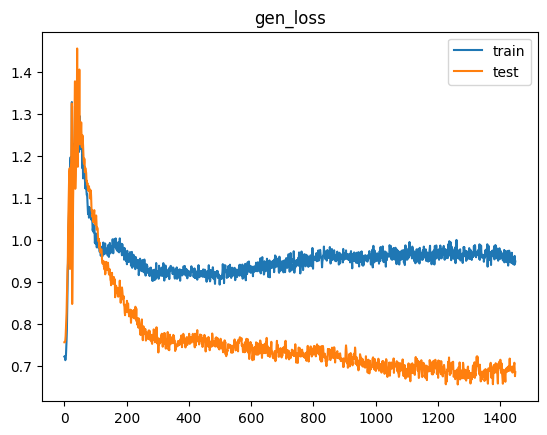

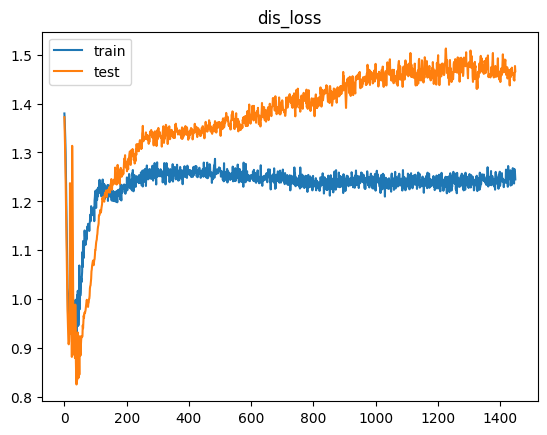

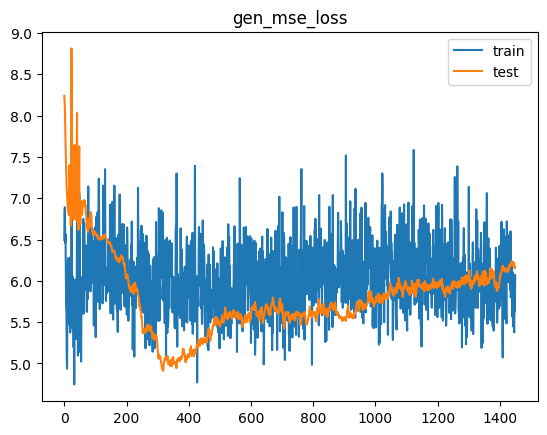

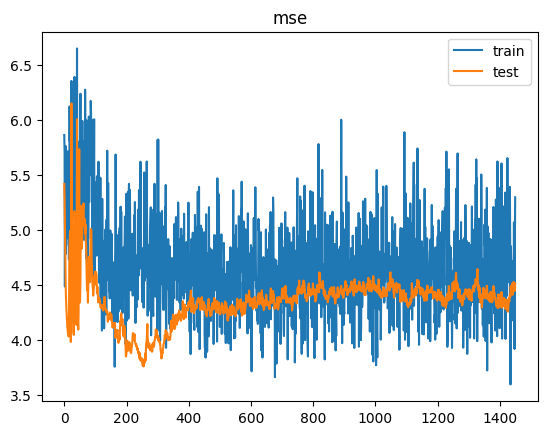

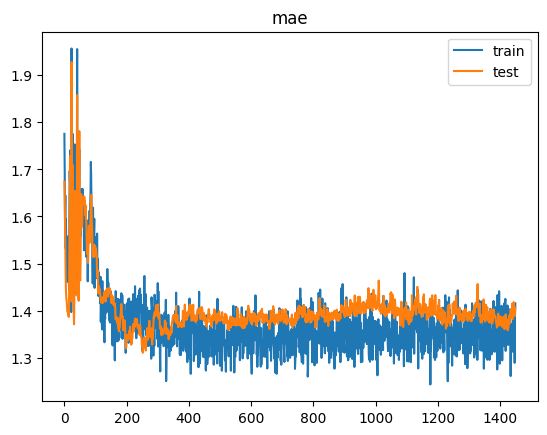

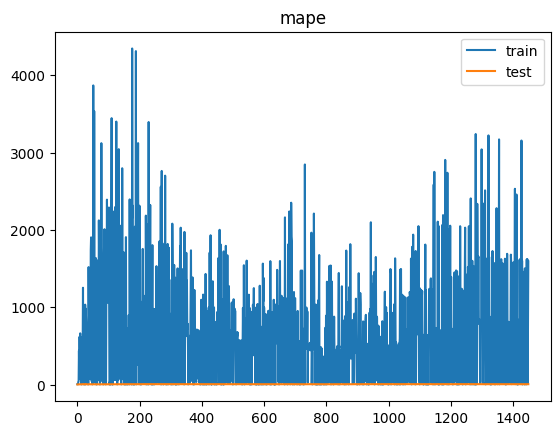

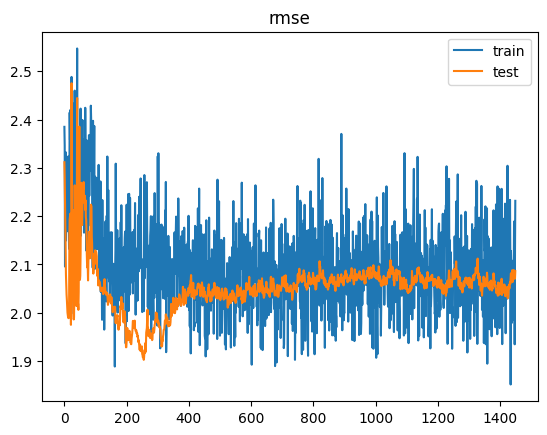

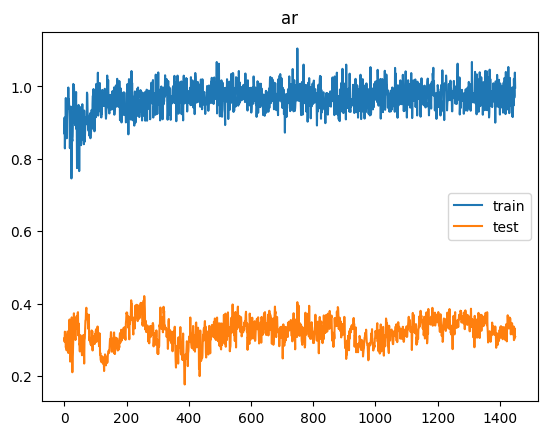

2/2 [==============================] - 0s 3ms/step


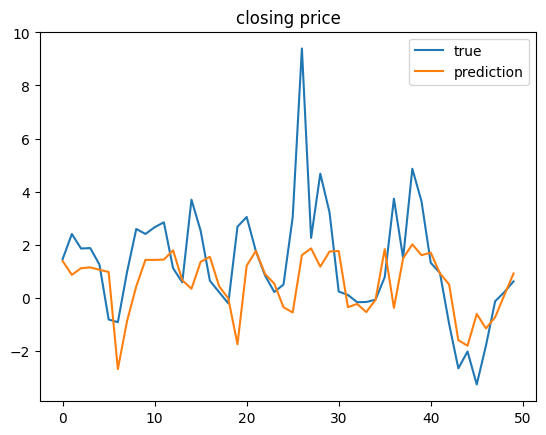

[MSE Baseline] train: 5.583172251310278  test: 3.868181586758766
Delta time with epochs = 1450: 0:10:32.281994


In [20]:
for epochs in [1200, 1450]:
    start_time = datetime.datetime.now()
    df = add_Ma(df)
    data_gen_train, data_gen_test = get_gen_train_test(df, n_sequence, n_batch)

    generator = make_generator_model(n_sequence, n_features)
    discriminator=make_discriminator_model(n_features)

    learning_rate=1e-4
    generator_optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.5)
    discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.5)

    @tf.function
    def train_step(sequences, sequences_end):
      return train_step_def(sequences, sequences_end)

    @tf.function
    def test_step(sequences, sequences_end):
      return test_step_def(sequences, sequences_end)

    checkpoint_dir = './training_checkpoints'+stock_code
    checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
    checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                     discriminator_optimizer=discriminator_optimizer,
                                     generator=generator,
                                     discriminator=discriminator)

    history, history_val = train(data_gen_train, data_gen_test, epochs)

    plot_history(history, history_val)
    plot_frame(*data_gen_test[0], generator)

    print("[MSE Baseline] train:",mean_squared_error(data_gen_train)," test:", mean_squared_error(data_gen_test))
    now = datetime.datetime.now()
    delta = now - start_time
    print("Delta time with epochs = {0}:".format(epochs), delta)
    generator.save("rnn_ffnn_epochs_{0}.h5".format(epochs))

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 5, 7)]            0         
                                                                 
 simple_rnn_4 (SimpleRNN)    (None, 5, 10)             180       
                                                                 
 batch_normalization_4 (Batc  (None, 5, 10)            40        
 hNormalization)                                                 
                                                                 
 leaky_re_lu_12 (LeakyReLU)  (None, 5, 10)             0         
                                                                 
 dropout_10 (Dropout)        (None, 5, 10)             0         
                                                                 
 simple_rnn_5 (SimpleRNN)    (None, 10)                210       
                                                           

Time for epoch 53 is 0.43689942359924316 sec Generator Loss: 1.3679157495498657,  Discriminator_loss: 0.9939890503883362
Time for epoch 54 is 0.43111491203308105 sec Generator Loss: 1.3487485647201538,  Discriminator_loss: 0.997772216796875
Time for epoch 55 is 0.42989325523376465 sec Generator Loss: 1.3618149757385254,  Discriminator_loss: 0.9753350615501404
Time for epoch 56 is 0.45098137855529785 sec Generator Loss: 1.3446029424667358,  Discriminator_loss: 1.0104643106460571
Time for epoch 57 is 0.4635043144226074 sec Generator Loss: 1.3692600727081299,  Discriminator_loss: 0.9742376804351807
Time for epoch 58 is 0.48705077171325684 sec Generator Loss: 1.3339298963546753,  Discriminator_loss: 0.9850090146064758
Time for epoch 59 is 0.5139749050140381 sec Generator Loss: 1.344394326210022,  Discriminator_loss: 0.9975001811981201
Time for epoch 60 is 0.42380547523498535 sec Generator Loss: 1.3299897909164429,  Discriminator_loss: 1.0170419216156006
Time for epoch 61 is 0.5372962951660

Time for epoch 122 is 0.3953225612640381 sec Generator Loss: 1.0022088289260864,  Discriminator_loss: 1.2096333503723145
Time for epoch 123 is 0.4241032600402832 sec Generator Loss: 1.0200774669647217,  Discriminator_loss: 1.2012778520584106
Time for epoch 124 is 0.3944227695465088 sec Generator Loss: 1.0104153156280518,  Discriminator_loss: 1.1959625482559204
Time for epoch 125 is 0.4119257926940918 sec Generator Loss: 0.9936121106147766,  Discriminator_loss: 1.1992217302322388
Time for epoch 126 is 0.4018731117248535 sec Generator Loss: 0.9985911250114441,  Discriminator_loss: 1.1986026763916016
Time for epoch 127 is 0.390871524810791 sec Generator Loss: 1.0144028663635254,  Discriminator_loss: 1.2012946605682373
Time for epoch 128 is 0.4071033000946045 sec Generator Loss: 1.0015050172805786,  Discriminator_loss: 1.2028390169143677
Time for epoch 129 is 0.3922114372253418 sec Generator Loss: 1.0063201189041138,  Discriminator_loss: 1.2037749290466309
Time for epoch 130 is 0.399280309

Time for epoch 190 is 0.407196044921875 sec Generator Loss: 0.989601731300354,  Discriminator_loss: 1.2105348110198975
Time for epoch 191 is 0.40609288215637207 sec Generator Loss: 0.9930815100669861,  Discriminator_loss: 1.2316612005233765
Time for epoch 192 is 0.3980250358581543 sec Generator Loss: 0.9986074566841125,  Discriminator_loss: 1.2128405570983887
Time for epoch 193 is 0.4019908905029297 sec Generator Loss: 0.9999593496322632,  Discriminator_loss: 1.2059904336929321
Time for epoch 194 is 0.4027230739593506 sec Generator Loss: 0.9990306496620178,  Discriminator_loss: 1.194522500038147
Time for epoch 195 is 0.4065995216369629 sec Generator Loss: 0.9831942915916443,  Discriminator_loss: 1.2219440937042236
Time for epoch 196 is 0.40143465995788574 sec Generator Loss: 1.0006591081619263,  Discriminator_loss: 1.2110174894332886
Time for epoch 197 is 0.40303921699523926 sec Generator Loss: 0.9776707291603088,  Discriminator_loss: 1.2310093641281128
Time for epoch 198 is 0.40522694

Time for epoch 258 is 0.45276355743408203 sec Generator Loss: 0.9985705614089966,  Discriminator_loss: 1.2217661142349243
Time for epoch 259 is 0.5326099395751953 sec Generator Loss: 0.9863507747650146,  Discriminator_loss: 1.2283103466033936
Time for epoch 260 is 0.445786714553833 sec Generator Loss: 0.9923033714294434,  Discriminator_loss: 1.2197868824005127
Time for epoch 261 is 0.4201822280883789 sec Generator Loss: 0.9845834970474243,  Discriminator_loss: 1.2178633213043213
Time for epoch 262 is 0.39690446853637695 sec Generator Loss: 0.9878812432289124,  Discriminator_loss: 1.2046663761138916
Time for epoch 263 is 0.4024965763092041 sec Generator Loss: 1.0178755521774292,  Discriminator_loss: 1.2011867761611938
Time for epoch 264 is 0.3944685459136963 sec Generator Loss: 0.9851494431495667,  Discriminator_loss: 1.2285118103027344
Time for epoch 265 is 0.400712251663208 sec Generator Loss: 0.9842355251312256,  Discriminator_loss: 1.2119587659835815
Time for epoch 266 is 0.41134071

Time for epoch 326 is 0.4434661865234375 sec Generator Loss: 1.023496389389038,  Discriminator_loss: 1.187379002571106
Time for epoch 327 is 0.4496891498565674 sec Generator Loss: 1.0074883699417114,  Discriminator_loss: 1.197783350944519
Time for epoch 328 is 0.4399590492248535 sec Generator Loss: 1.0085088014602661,  Discriminator_loss: 1.2260574102401733
Time for epoch 329 is 0.48656797409057617 sec Generator Loss: 1.021260142326355,  Discriminator_loss: 1.198225975036621
Time for epoch 330 is 0.4471416473388672 sec Generator Loss: 1.0185354948043823,  Discriminator_loss: 1.2064857482910156
Time for epoch 331 is 0.5391530990600586 sec Generator Loss: 1.0155994892120361,  Discriminator_loss: 1.1986279487609863
Time for epoch 332 is 0.42241382598876953 sec Generator Loss: 1.0026907920837402,  Discriminator_loss: 1.2255892753601074
Time for epoch 333 is 0.44638514518737793 sec Generator Loss: 0.9964029788970947,  Discriminator_loss: 1.211989402770996
Time for epoch 334 is 0.41316390037

Time for epoch 394 is 0.4762096405029297 sec Generator Loss: 0.9772577285766602,  Discriminator_loss: 1.2239329814910889
Time for epoch 395 is 0.39940977096557617 sec Generator Loss: 0.9742821455001831,  Discriminator_loss: 1.2340271472930908
Time for epoch 396 is 0.4054744243621826 sec Generator Loss: 0.9874216914176941,  Discriminator_loss: 1.2281525135040283
Time for epoch 397 is 0.40558433532714844 sec Generator Loss: 0.9776356816291809,  Discriminator_loss: 1.2352914810180664
Time for epoch 398 is 0.413405179977417 sec Generator Loss: 0.9797002673149109,  Discriminator_loss: 1.2249031066894531
Time for epoch 399 is 0.4046590328216553 sec Generator Loss: 0.9870795607566833,  Discriminator_loss: 1.2302899360656738
Time for epoch 400 is 0.437166690826416 sec Generator Loss: 0.9958956837654114,  Discriminator_loss: 1.2233387231826782
Time for epoch 401 is 0.41814184188842773 sec Generator Loss: 0.9817644953727722,  Discriminator_loss: 1.2282078266143799
Time for epoch 402 is 0.4159274

Time for epoch 462 is 0.44081592559814453 sec Generator Loss: 0.9749284982681274,  Discriminator_loss: 1.2353993654251099
Time for epoch 463 is 0.45870280265808105 sec Generator Loss: 0.9634334444999695,  Discriminator_loss: 1.2284718751907349
Time for epoch 464 is 0.4550900459289551 sec Generator Loss: 0.9590311050415039,  Discriminator_loss: 1.2404085397720337
Time for epoch 465 is 0.460252046585083 sec Generator Loss: 1.0057945251464844,  Discriminator_loss: 1.2196038961410522
Time for epoch 466 is 0.44341468811035156 sec Generator Loss: 0.9682116508483887,  Discriminator_loss: 1.245383620262146
Time for epoch 467 is 0.436112642288208 sec Generator Loss: 1.0066219568252563,  Discriminator_loss: 1.2125701904296875
Time for epoch 468 is 0.4446980953216553 sec Generator Loss: 0.9860403537750244,  Discriminator_loss: 1.220237374305725
Time for epoch 469 is 0.4320662021636963 sec Generator Loss: 0.9865771532058716,  Discriminator_loss: 1.2181360721588135
Time for epoch 470 is 0.453643560

Time for epoch 530 is 0.4385049343109131 sec Generator Loss: 0.9782096743583679,  Discriminator_loss: 1.2353765964508057
Time for epoch 531 is 0.4256856441497803 sec Generator Loss: 0.9951357245445251,  Discriminator_loss: 1.2150360345840454
Time for epoch 532 is 0.48041224479675293 sec Generator Loss: 0.9769027829170227,  Discriminator_loss: 1.220039963722229
Time for epoch 533 is 0.44547128677368164 sec Generator Loss: 0.9932469129562378,  Discriminator_loss: 1.2124567031860352
Time for epoch 534 is 0.42490506172180176 sec Generator Loss: 1.007880449295044,  Discriminator_loss: 1.2164169549942017
Time for epoch 535 is 0.42665863037109375 sec Generator Loss: 0.9784361720085144,  Discriminator_loss: 1.2383196353912354
Time for epoch 536 is 0.424652099609375 sec Generator Loss: 0.9831414222717285,  Discriminator_loss: 1.239953875541687
Time for epoch 537 is 0.4198009967803955 sec Generator Loss: 0.9915736317634583,  Discriminator_loss: 1.2361692190170288
Time for epoch 538 is 0.41896271

Time for epoch 598 is 0.48954129219055176 sec Generator Loss: 0.9746144413948059,  Discriminator_loss: 1.2243798971176147
Time for epoch 599 is 0.4292142391204834 sec Generator Loss: 0.9870792627334595,  Discriminator_loss: 1.2108898162841797
Time for epoch 600 is 0.4142458438873291 sec Generator Loss: 0.9855108857154846,  Discriminator_loss: 1.231112003326416
Time for epoch 601 is 0.42326807975769043 sec Generator Loss: 0.9615660905838013,  Discriminator_loss: 1.2483570575714111
Time for epoch 602 is 0.44502758979797363 sec Generator Loss: 0.994106650352478,  Discriminator_loss: 1.2135050296783447
Time for epoch 603 is 0.43413209915161133 sec Generator Loss: 0.9839740991592407,  Discriminator_loss: 1.234917163848877
Time for epoch 604 is 0.41393470764160156 sec Generator Loss: 0.9597747921943665,  Discriminator_loss: 1.2480366230010986
Time for epoch 605 is 0.40787529945373535 sec Generator Loss: 0.958254337310791,  Discriminator_loss: 1.239753246307373
Time for epoch 606 is 0.4180898

Time for epoch 666 is 0.4092693328857422 sec Generator Loss: 0.9872604608535767,  Discriminator_loss: 1.2221070528030396
Time for epoch 667 is 0.4034395217895508 sec Generator Loss: 0.975823163986206,  Discriminator_loss: 1.2296448945999146
Time for epoch 668 is 0.4086434841156006 sec Generator Loss: 0.9813389778137207,  Discriminator_loss: 1.2304776906967163
Time for epoch 669 is 0.4129018783569336 sec Generator Loss: 0.9578751921653748,  Discriminator_loss: 1.248239517211914
Time for epoch 670 is 0.40766143798828125 sec Generator Loss: 0.9773026704788208,  Discriminator_loss: 1.2421200275421143
Time for epoch 671 is 0.4008603096008301 sec Generator Loss: 0.971998929977417,  Discriminator_loss: 1.2323787212371826
Time for epoch 672 is 0.405231237411499 sec Generator Loss: 0.9752196073532104,  Discriminator_loss: 1.2307413816452026
Time for epoch 673 is 0.4063425064086914 sec Generator Loss: 0.969937264919281,  Discriminator_loss: 1.2451701164245605
Time for epoch 674 is 0.398321151733

Time for epoch 734 is 0.43597912788391113 sec Generator Loss: 0.9787519574165344,  Discriminator_loss: 1.2139610052108765
Time for epoch 735 is 0.4021565914154053 sec Generator Loss: 0.9976634383201599,  Discriminator_loss: 1.2173324823379517
Time for epoch 736 is 0.4159677028656006 sec Generator Loss: 0.991503119468689,  Discriminator_loss: 1.2147709131240845
Time for epoch 737 is 0.4048001766204834 sec Generator Loss: 0.9979687929153442,  Discriminator_loss: 1.2275470495224
Time for epoch 738 is 0.40955281257629395 sec Generator Loss: 0.9829577207565308,  Discriminator_loss: 1.2269272804260254
Time for epoch 739 is 0.4128110408782959 sec Generator Loss: 0.9884870648384094,  Discriminator_loss: 1.230837345123291
Time for epoch 740 is 0.4028177261352539 sec Generator Loss: 0.9913056492805481,  Discriminator_loss: 1.214799165725708
Time for epoch 741 is 0.4071474075317383 sec Generator Loss: 0.9933551549911499,  Discriminator_loss: 1.2198866605758667
Time for epoch 742 is 0.407322168350

Time for epoch 802 is 0.40943050384521484 sec Generator Loss: 1.0074557065963745,  Discriminator_loss: 1.2115187644958496
Time for epoch 803 is 0.41434574127197266 sec Generator Loss: 1.0069258213043213,  Discriminator_loss: 1.2232669591903687
Time for epoch 804 is 0.4324202537536621 sec Generator Loss: 0.9802807569503784,  Discriminator_loss: 1.2270777225494385
Time for epoch 805 is 0.40618228912353516 sec Generator Loss: 0.9977844953536987,  Discriminator_loss: 1.2239793539047241
Time for epoch 806 is 0.41562700271606445 sec Generator Loss: 0.9745533466339111,  Discriminator_loss: 1.2382341623306274
Time for epoch 807 is 0.3983314037322998 sec Generator Loss: 0.9955413937568665,  Discriminator_loss: 1.2266616821289062
Time for epoch 808 is 0.4025416374206543 sec Generator Loss: 0.9807353615760803,  Discriminator_loss: 1.2341344356536865
Time for epoch 809 is 0.4017980098724365 sec Generator Loss: 0.9813481569290161,  Discriminator_loss: 1.2315893173217773
Time for epoch 810 is 0.4045

Time for epoch 870 is 0.4010791778564453 sec Generator Loss: 0.9970563054084778,  Discriminator_loss: 1.2279877662658691
Time for epoch 871 is 0.42417263984680176 sec Generator Loss: 0.9710956811904907,  Discriminator_loss: 1.2590187788009644
Time for epoch 872 is 0.4297668933868408 sec Generator Loss: 0.9921411275863647,  Discriminator_loss: 1.2224748134613037
Time for epoch 873 is 0.43782711029052734 sec Generator Loss: 0.9925527572631836,  Discriminator_loss: 1.223882794380188
Time for epoch 874 is 0.4075613021850586 sec Generator Loss: 0.9935081601142883,  Discriminator_loss: 1.2350130081176758
Time for epoch 875 is 0.4119069576263428 sec Generator Loss: 1.003481388092041,  Discriminator_loss: 1.2041772603988647
Time for epoch 876 is 0.4177417755126953 sec Generator Loss: 0.9803577661514282,  Discriminator_loss: 1.232873558998108
Time for epoch 877 is 0.41255974769592285 sec Generator Loss: 1.0085270404815674,  Discriminator_loss: 1.2169058322906494
Time for epoch 878 is 0.49850058

Time for epoch 938 is 0.4064159393310547 sec Generator Loss: 0.9955760836601257,  Discriminator_loss: 1.2258697748184204
Time for epoch 939 is 0.4056429862976074 sec Generator Loss: 0.98417729139328,  Discriminator_loss: 1.2310065031051636
Time for epoch 940 is 0.4063143730163574 sec Generator Loss: 0.9860633015632629,  Discriminator_loss: 1.2260794639587402
Time for epoch 941 is 0.4025137424468994 sec Generator Loss: 1.008683443069458,  Discriminator_loss: 1.2021254301071167
Time for epoch 942 is 0.41045618057250977 sec Generator Loss: 1.0038409233093262,  Discriminator_loss: 1.212235927581787
Time for epoch 943 is 0.4148545265197754 sec Generator Loss: 0.9783872961997986,  Discriminator_loss: 1.2421952486038208
Time for epoch 944 is 0.40941786766052246 sec Generator Loss: 0.989901602268219,  Discriminator_loss: 1.2411704063415527
Time for epoch 945 is 0.42029404640197754 sec Generator Loss: 0.9737545847892761,  Discriminator_loss: 1.2372626066207886
Time for epoch 946 is 0.4054923057

Time for epoch 1006 is 0.4067704677581787 sec Generator Loss: 1.006972312927246,  Discriminator_loss: 1.2147883176803589
Time for epoch 1007 is 0.41851305961608887 sec Generator Loss: 0.9987137317657471,  Discriminator_loss: 1.2121185064315796
Time for epoch 1008 is 0.41883134841918945 sec Generator Loss: 0.9912062883377075,  Discriminator_loss: 1.2350531816482544
Time for epoch 1009 is 0.4183673858642578 sec Generator Loss: 1.009781837463379,  Discriminator_loss: 1.2155455350875854
Time for epoch 1010 is 0.4147818088531494 sec Generator Loss: 1.007226586341858,  Discriminator_loss: 1.2214387655258179
Time for epoch 1011 is 0.41066575050354004 sec Generator Loss: 1.0063437223434448,  Discriminator_loss: 1.2111254930496216
Time for epoch 1012 is 0.41041994094848633 sec Generator Loss: 1.006687045097351,  Discriminator_loss: 1.2313385009765625
Time for epoch 1013 is 0.42067527770996094 sec Generator Loss: 1.0261074304580688,  Discriminator_loss: 1.2141932249069214
Time for epoch 1014 is 

Time for epoch 1074 is 0.4104766845703125 sec Generator Loss: 1.0264407396316528,  Discriminator_loss: 1.2149263620376587
Time for epoch 1075 is 0.4122440814971924 sec Generator Loss: 1.0032418966293335,  Discriminator_loss: 1.212315559387207
Time for epoch 1076 is 0.41539692878723145 sec Generator Loss: 1.006937026977539,  Discriminator_loss: 1.2292925119400024
Time for epoch 1077 is 0.4057600498199463 sec Generator Loss: 0.9944514632225037,  Discriminator_loss: 1.2200287580490112
Time for epoch 1078 is 0.4167757034301758 sec Generator Loss: 1.002555012702942,  Discriminator_loss: 1.213217854499817
Time for epoch 1079 is 0.4120521545410156 sec Generator Loss: 0.9719119668006897,  Discriminator_loss: 1.2348788976669312
Time for epoch 1080 is 0.41761040687561035 sec Generator Loss: 1.022464632987976,  Discriminator_loss: 1.2129428386688232
Time for epoch 1081 is 0.415804386138916 sec Generator Loss: 1.0015915632247925,  Discriminator_loss: 1.2217559814453125
Time for epoch 1082 is 0.400

Time for epoch 1142 is 0.43406200408935547 sec Generator Loss: 0.9995677471160889,  Discriminator_loss: 1.2207204103469849
Time for epoch 1143 is 0.47298383712768555 sec Generator Loss: 0.9849829077720642,  Discriminator_loss: 1.2384744882583618
Time for epoch 1144 is 0.4599432945251465 sec Generator Loss: 0.9928561449050903,  Discriminator_loss: 1.2375630140304565
Time for epoch 1145 is 0.46579456329345703 sec Generator Loss: 0.9868824481964111,  Discriminator_loss: 1.2165875434875488
Time for epoch 1146 is 0.4575467109680176 sec Generator Loss: 0.9934285879135132,  Discriminator_loss: 1.2255122661590576
Time for epoch 1147 is 0.47077107429504395 sec Generator Loss: 0.9907787442207336,  Discriminator_loss: 1.2226885557174683
Time for epoch 1148 is 0.4468374252319336 sec Generator Loss: 0.9953235387802124,  Discriminator_loss: 1.2203655242919922
Time for epoch 1149 is 0.44614601135253906 sec Generator Loss: 1.0087625980377197,  Discriminator_loss: 1.2230262756347656
Time for epoch 1150

Time for epoch 1210 is 0.4894249439239502 sec Generator Loss: 1.01882803440094,  Discriminator_loss: 1.2246177196502686
Time for epoch 1211 is 0.4757537841796875 sec Generator Loss: 1.0108562707901,  Discriminator_loss: 1.233614444732666
Time for epoch 1212 is 0.49580955505371094 sec Generator Loss: 0.9999820590019226,  Discriminator_loss: 1.2389034032821655
Time for epoch 1213 is 0.4627110958099365 sec Generator Loss: 1.006880283355713,  Discriminator_loss: 1.2186609506607056
Time for epoch 1214 is 0.44794487953186035 sec Generator Loss: 1.0141723155975342,  Discriminator_loss: 1.2170369625091553
Time for epoch 1215 is 0.47048449516296387 sec Generator Loss: 1.00153648853302,  Discriminator_loss: 1.2103081941604614
Time for epoch 1216 is 0.45885705947875977 sec Generator Loss: 1.0139881372451782,  Discriminator_loss: 1.211984634399414
Time for epoch 1217 is 0.4523158073425293 sec Generator Loss: 0.9959849119186401,  Discriminator_loss: 1.2183274030685425
Time for epoch 1218 is 0.48192

Time for epoch 1278 is 0.6193444728851318 sec Generator Loss: 0.986602783203125,  Discriminator_loss: 1.2321667671203613
Time for epoch 1279 is 0.6681869029998779 sec Generator Loss: 1.0136288404464722,  Discriminator_loss: 1.229278802871704
Time for epoch 1280 is 0.5670998096466064 sec Generator Loss: 1.019834280014038,  Discriminator_loss: 1.2083847522735596
Time for epoch 1281 is 0.4728395938873291 sec Generator Loss: 0.9805079102516174,  Discriminator_loss: 1.2431306838989258
Time for epoch 1282 is 0.4964632987976074 sec Generator Loss: 1.018938660621643,  Discriminator_loss: 1.2138700485229492
Time for epoch 1283 is 0.48955607414245605 sec Generator Loss: 0.9848770499229431,  Discriminator_loss: 1.2295280694961548
Time for epoch 1284 is 0.47982215881347656 sec Generator Loss: 1.0071616172790527,  Discriminator_loss: 1.2276002168655396
Time for epoch 1285 is 0.49611735343933105 sec Generator Loss: 1.0131088495254517,  Discriminator_loss: 1.2225303649902344
Time for epoch 1286 is 0.

Time for epoch 1346 is 0.4908885955810547 sec Generator Loss: 1.0035041570663452,  Discriminator_loss: 1.2284855842590332
Time for epoch 1347 is 0.4699821472167969 sec Generator Loss: 1.0329121351242065,  Discriminator_loss: 1.2084801197052002
Time for epoch 1348 is 0.48816514015197754 sec Generator Loss: 1.0186125040054321,  Discriminator_loss: 1.2119052410125732
Time for epoch 1349 is 0.4667959213256836 sec Generator Loss: 1.003537893295288,  Discriminator_loss: 1.2162420749664307
Time for epoch 1350 is 0.4792144298553467 sec Generator Loss: 1.0190976858139038,  Discriminator_loss: 1.2160426378250122
Time for epoch 1351 is 0.4184539318084717 sec Generator Loss: 1.0110118389129639,  Discriminator_loss: 1.2105125188827515
Time for epoch 1352 is 0.4553515911102295 sec Generator Loss: 1.0212974548339844,  Discriminator_loss: 1.209844946861267
Time for epoch 1353 is 0.43859028816223145 sec Generator Loss: 1.0155872106552124,  Discriminator_loss: 1.206631064414978
Time for epoch 1354 is 0.

Time for epoch 1414 is 0.47643232345581055 sec Generator Loss: 1.025449514389038,  Discriminator_loss: 1.2041012048721313
Time for epoch 1415 is 0.51198410987854 sec Generator Loss: 1.0151554346084595,  Discriminator_loss: 1.2312414646148682
Time for epoch 1416 is 0.5243251323699951 sec Generator Loss: 1.0286413431167603,  Discriminator_loss: 1.1983100175857544
Time for epoch 1417 is 0.5179064273834229 sec Generator Loss: 1.0151718854904175,  Discriminator_loss: 1.209952712059021
Time for epoch 1418 is 0.5320477485656738 sec Generator Loss: 1.039687991142273,  Discriminator_loss: 1.208210825920105
Time for epoch 1419 is 0.5599987506866455 sec Generator Loss: 1.0105774402618408,  Discriminator_loss: 1.2228295803070068
Time for epoch 1420 is 0.6026170253753662 sec Generator Loss: 1.0308969020843506,  Discriminator_loss: 1.2083141803741455
Time for epoch 1421 is 0.5991685390472412 sec Generator Loss: 1.0234605073928833,  Discriminator_loss: 1.2086678743362427
Time for epoch 1422 is 0.5989

Time for epoch 1482 is 0.5144939422607422 sec Generator Loss: 1.0131981372833252,  Discriminator_loss: 1.2173458337783813
Time for epoch 1483 is 0.5193502902984619 sec Generator Loss: 1.0579723119735718,  Discriminator_loss: 1.1961114406585693
Time for epoch 1484 is 0.5822782516479492 sec Generator Loss: 1.0374364852905273,  Discriminator_loss: 1.1989574432373047
Time for epoch 1485 is 0.5183572769165039 sec Generator Loss: 1.0518672466278076,  Discriminator_loss: 1.197450876235962
Time for epoch 1486 is 0.5645809173583984 sec Generator Loss: 1.0290117263793945,  Discriminator_loss: 1.205988883972168
Time for epoch 1487 is 0.534193754196167 sec Generator Loss: 1.0157264471054077,  Discriminator_loss: 1.2182410955429077
Time for epoch 1488 is 0.752328634262085 sec Generator Loss: 1.0266952514648438,  Discriminator_loss: 1.2152587175369263
Time for epoch 1489 is 0.7004244327545166 sec Generator Loss: 1.0045663118362427,  Discriminator_loss: 1.211130976676941
Time for epoch 1490 is 0.5274

Time for epoch 1550 is 0.5325322151184082 sec Generator Loss: 1.0398579835891724,  Discriminator_loss: 1.2026082277297974
Time for epoch 1551 is 0.4596524238586426 sec Generator Loss: 1.0186944007873535,  Discriminator_loss: 1.2315925359725952
Time for epoch 1552 is 0.4797508716583252 sec Generator Loss: 1.0354772806167603,  Discriminator_loss: 1.2071077823638916
Time for epoch 1553 is 0.47003650665283203 sec Generator Loss: 1.0397300720214844,  Discriminator_loss: 1.1881226301193237
Time for epoch 1554 is 0.5046777725219727 sec Generator Loss: 1.0511364936828613,  Discriminator_loss: 1.2137012481689453
Time for epoch 1555 is 0.4705357551574707 sec Generator Loss: 1.0222499370574951,  Discriminator_loss: 1.2119618654251099
Time for epoch 1556 is 0.43285155296325684 sec Generator Loss: 1.0347634553909302,  Discriminator_loss: 1.2076398134231567
Time for epoch 1557 is 0.4229753017425537 sec Generator Loss: 1.0384564399719238,  Discriminator_loss: 1.197625994682312
Time for epoch 1558 is 

Time for epoch 1618 is 0.5233423709869385 sec Generator Loss: 1.0469958782196045,  Discriminator_loss: 1.210127353668213
Time for epoch 1619 is 0.49085021018981934 sec Generator Loss: 1.0285736322402954,  Discriminator_loss: 1.1943117380142212
Time for epoch 1620 is 0.5077011585235596 sec Generator Loss: 1.0342556238174438,  Discriminator_loss: 1.198987364768982
Time for epoch 1621 is 0.6150493621826172 sec Generator Loss: 1.0392017364501953,  Discriminator_loss: 1.2002373933792114
Time for epoch 1622 is 0.5594544410705566 sec Generator Loss: 1.0510390996932983,  Discriminator_loss: 1.1927160024642944
Time for epoch 1623 is 0.4719715118408203 sec Generator Loss: 1.058412790298462,  Discriminator_loss: 1.195403814315796
Time for epoch 1624 is 0.4602339267730713 sec Generator Loss: 1.0485025644302368,  Discriminator_loss: 1.1950286626815796
Time for epoch 1625 is 0.49467968940734863 sec Generator Loss: 1.019364833831787,  Discriminator_loss: 1.227104902267456
Time for epoch 1626 is 0.501

Time for epoch 1686 is 0.5372283458709717 sec Generator Loss: 1.0319195985794067,  Discriminator_loss: 1.198817253112793
Time for epoch 1687 is 0.532921552658081 sec Generator Loss: 1.020597219467163,  Discriminator_loss: 1.2345026731491089
Time for epoch 1688 is 0.5175457000732422 sec Generator Loss: 1.003486156463623,  Discriminator_loss: 1.2259209156036377
Time for epoch 1689 is 0.5553946495056152 sec Generator Loss: 1.028107762336731,  Discriminator_loss: 1.210127592086792
Time for epoch 1690 is 0.5279953479766846 sec Generator Loss: 0.9978192448616028,  Discriminator_loss: 1.2234731912612915
Time for epoch 1691 is 0.5296206474304199 sec Generator Loss: 1.0250449180603027,  Discriminator_loss: 1.2009992599487305
Time for epoch 1692 is 0.5673470497131348 sec Generator Loss: 1.0296090841293335,  Discriminator_loss: 1.215781569480896
Time for epoch 1693 is 0.541717529296875 sec Generator Loss: 1.0255719423294067,  Discriminator_loss: 1.1985722780227661
Time for epoch 1694 is 0.5435864

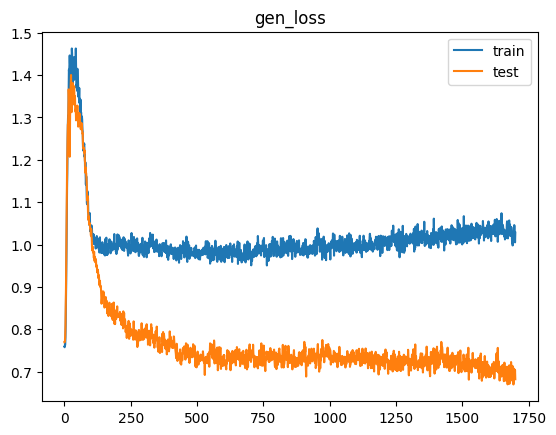

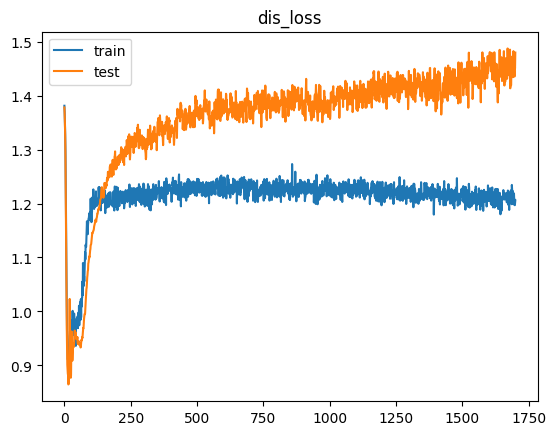

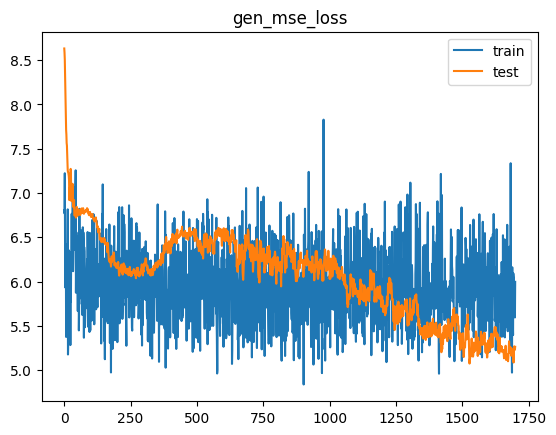

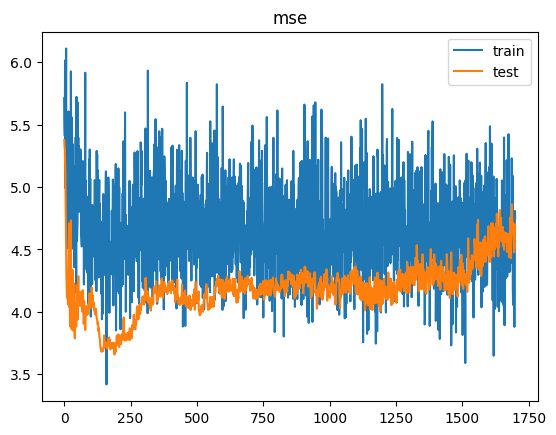

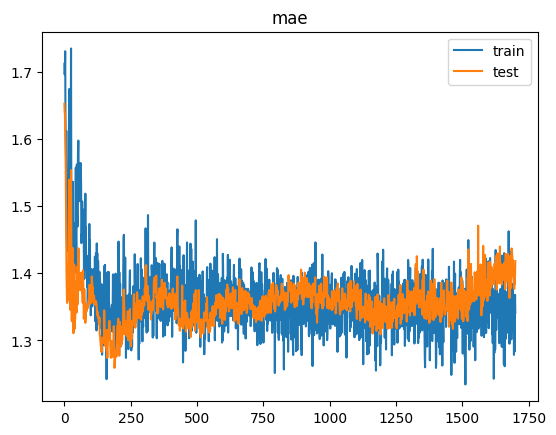

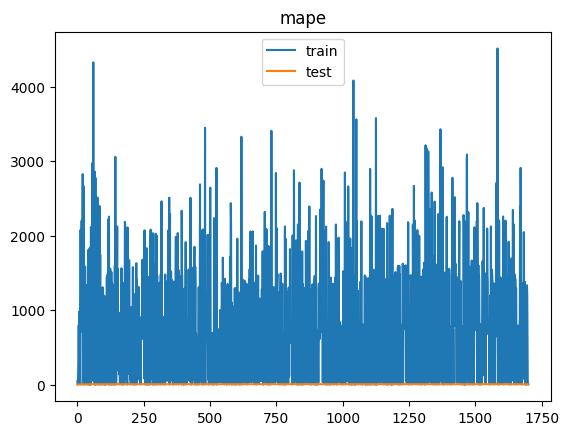

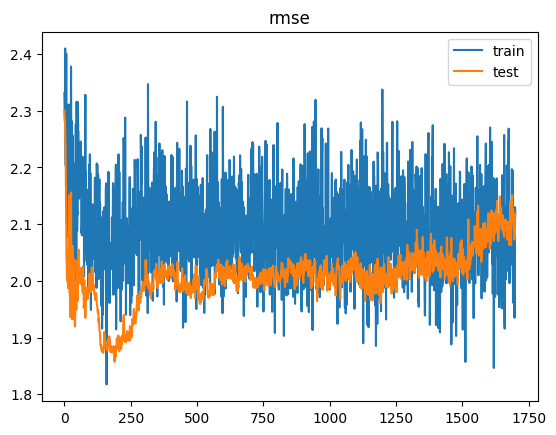

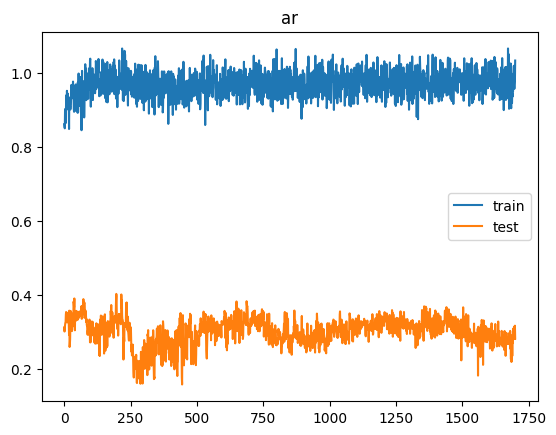

2/2 [==============================] - 0s 4ms/step


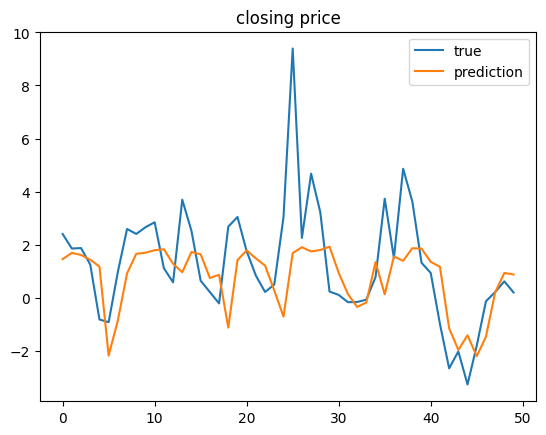

[MSE Baseline] train: 4.085730723757973  test: 3.7469059248471765
Delta time with epochs = 1700: 0:13:13.377114
Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 5, 7)]            0         
                                                                 
 simple_rnn_6 (SimpleRNN)    (None, 5, 10)             180       
                                                                 
 batch_normalization_6 (Batc  (None, 5, 10)            40        
 hNormalization)                                                 
                                                                 
 leaky_re_lu_18 (LeakyReLU)  (None, 5, 10)             0         
                                                                 
 dropout_15 (Dropout)        (None, 5, 10)             0         
                                                                 
 simple_rnn_7

Time for epoch 52 is 0.5438742637634277 sec Generator Loss: 1.3949401378631592,  Discriminator_loss: 0.9284481406211853
Time for epoch 53 is 0.491682767868042 sec Generator Loss: 1.3904180526733398,  Discriminator_loss: 0.9340466260910034
Time for epoch 54 is 0.45460033416748047 sec Generator Loss: 1.3823156356811523,  Discriminator_loss: 0.954917848110199
Time for epoch 55 is 0.5027995109558105 sec Generator Loss: 1.4061354398727417,  Discriminator_loss: 0.9332785606384277
Time for epoch 56 is 0.5304818153381348 sec Generator Loss: 1.3844795227050781,  Discriminator_loss: 0.9566617012023926
Time for epoch 57 is 0.5618336200714111 sec Generator Loss: 1.3702092170715332,  Discriminator_loss: 0.9425990581512451
Time for epoch 58 is 0.5191051959991455 sec Generator Loss: 1.386401891708374,  Discriminator_loss: 0.9197008013725281
Time for epoch 59 is 0.4680817127227783 sec Generator Loss: 1.3605754375457764,  Discriminator_loss: 0.9345269203186035
Time for epoch 60 is 0.4797506332397461 se

Time for epoch 121 is 0.5333125591278076 sec Generator Loss: 1.0712685585021973,  Discriminator_loss: 1.1751247644424438
Time for epoch 122 is 0.5420162677764893 sec Generator Loss: 1.0535386800765991,  Discriminator_loss: 1.1869934797286987
Time for epoch 123 is 0.5202486515045166 sec Generator Loss: 1.0554325580596924,  Discriminator_loss: 1.1975568532943726
Time for epoch 124 is 0.5262806415557861 sec Generator Loss: 1.0575788021087646,  Discriminator_loss: 1.1851500272750854
Time for epoch 125 is 0.532573938369751 sec Generator Loss: 1.0398705005645752,  Discriminator_loss: 1.1949210166931152
Time for epoch 126 is 0.5295305252075195 sec Generator Loss: 1.0316879749298096,  Discriminator_loss: 1.2046996355056763
Time for epoch 127 is 0.5491328239440918 sec Generator Loss: 1.0398385524749756,  Discriminator_loss: 1.2115797996520996
Time for epoch 128 is 0.5260422229766846 sec Generator Loss: 1.0489068031311035,  Discriminator_loss: 1.2043966054916382
Time for epoch 129 is 0.541153430

Time for epoch 189 is 0.5365796089172363 sec Generator Loss: 0.932761013507843,  Discriminator_loss: 1.2692034244537354
Time for epoch 190 is 0.5343601703643799 sec Generator Loss: 0.9374272227287292,  Discriminator_loss: 1.2745494842529297
Time for epoch 191 is 0.5413544178009033 sec Generator Loss: 0.931915819644928,  Discriminator_loss: 1.2535771131515503
Time for epoch 192 is 0.5473294258117676 sec Generator Loss: 0.9360651969909668,  Discriminator_loss: 1.281696081161499
Time for epoch 193 is 0.5237798690795898 sec Generator Loss: 0.9292420148849487,  Discriminator_loss: 1.275056004524231
Time for epoch 194 is 0.5285689830780029 sec Generator Loss: 0.9328757524490356,  Discriminator_loss: 1.2663151025772095
Time for epoch 195 is 0.5586996078491211 sec Generator Loss: 0.9384057521820068,  Discriminator_loss: 1.27153480052948
Time for epoch 196 is 0.5794696807861328 sec Generator Loss: 0.9352923035621643,  Discriminator_loss: 1.2726964950561523
Time for epoch 197 is 0.54278039932250

Time for epoch 257 is 0.4863884449005127 sec Generator Loss: 0.9259008765220642,  Discriminator_loss: 1.2752506732940674
Time for epoch 258 is 0.4877049922943115 sec Generator Loss: 0.9262976050376892,  Discriminator_loss: 1.2694566249847412
Time for epoch 259 is 0.49346375465393066 sec Generator Loss: 0.911963701248169,  Discriminator_loss: 1.2769676446914673
Time for epoch 260 is 0.544802188873291 sec Generator Loss: 0.9208979606628418,  Discriminator_loss: 1.2782546281814575
Time for epoch 261 is 0.5189778804779053 sec Generator Loss: 0.91713947057724,  Discriminator_loss: 1.2868067026138306
Time for epoch 262 is 0.5491738319396973 sec Generator Loss: 0.9065142273902893,  Discriminator_loss: 1.2872802019119263
Time for epoch 263 is 0.5345144271850586 sec Generator Loss: 0.9138298630714417,  Discriminator_loss: 1.2914983034133911
Time for epoch 264 is 0.5353600978851318 sec Generator Loss: 0.9041492342948914,  Discriminator_loss: 1.2873568534851074
Time for epoch 265 is 0.55599069595

Time for epoch 325 is 0.5315933227539062 sec Generator Loss: 0.913572371006012,  Discriminator_loss: 1.2802642583847046
Time for epoch 326 is 0.5162796974182129 sec Generator Loss: 0.919829785823822,  Discriminator_loss: 1.2655572891235352
Time for epoch 327 is 0.5384442806243896 sec Generator Loss: 0.9081271290779114,  Discriminator_loss: 1.2705057859420776
Time for epoch 328 is 0.4857468605041504 sec Generator Loss: 0.9200985431671143,  Discriminator_loss: 1.2712222337722778
Time for epoch 329 is 0.5130593776702881 sec Generator Loss: 0.9010007977485657,  Discriminator_loss: 1.2767655849456787
Time for epoch 330 is 0.5335264205932617 sec Generator Loss: 0.898335874080658,  Discriminator_loss: 1.284099817276001
Time for epoch 331 is 0.5885012149810791 sec Generator Loss: 0.9088878035545349,  Discriminator_loss: 1.265092372894287
Time for epoch 332 is 0.6610088348388672 sec Generator Loss: 0.912484347820282,  Discriminator_loss: 1.2716180086135864
Time for epoch 333 is 0.61244893074035

Time for epoch 393 is 0.4571645259857178 sec Generator Loss: 0.9083324074745178,  Discriminator_loss: 1.2828339338302612
Time for epoch 394 is 0.45664191246032715 sec Generator Loss: 0.9022925496101379,  Discriminator_loss: 1.277782917022705
Time for epoch 395 is 0.4670133590698242 sec Generator Loss: 0.8955302238464355,  Discriminator_loss: 1.2967373132705688
Time for epoch 396 is 0.49118995666503906 sec Generator Loss: 0.8922550678253174,  Discriminator_loss: 1.2700777053833008
Time for epoch 397 is 0.46823954582214355 sec Generator Loss: 0.890365719795227,  Discriminator_loss: 1.2821658849716187
Time for epoch 398 is 0.489804744720459 sec Generator Loss: 0.8983309268951416,  Discriminator_loss: 1.285157322883606
Time for epoch 399 is 0.4632301330566406 sec Generator Loss: 0.9139583110809326,  Discriminator_loss: 1.2829209566116333
Time for epoch 400 is 0.46351122856140137 sec Generator Loss: 0.9002320766448975,  Discriminator_loss: 1.2791712284088135
Time for epoch 401 is 0.46276426

Time for epoch 461 is 0.5341594219207764 sec Generator Loss: 0.9122208952903748,  Discriminator_loss: 1.271713376045227
Time for epoch 462 is 0.5690112113952637 sec Generator Loss: 0.9066120982170105,  Discriminator_loss: 1.2662091255187988
Time for epoch 463 is 0.5215878486633301 sec Generator Loss: 0.9152393937110901,  Discriminator_loss: 1.2724202871322632
Time for epoch 464 is 0.5354204177856445 sec Generator Loss: 0.9141438603401184,  Discriminator_loss: 1.2809605598449707
Time for epoch 465 is 0.5283560752868652 sec Generator Loss: 0.9056176543235779,  Discriminator_loss: 1.2772477865219116
Time for epoch 466 is 0.5242006778717041 sec Generator Loss: 0.9288252592086792,  Discriminator_loss: 1.255362868309021
Time for epoch 467 is 0.5698769092559814 sec Generator Loss: 0.9107414484024048,  Discriminator_loss: 1.2651760578155518
Time for epoch 468 is 0.5460612773895264 sec Generator Loss: 0.9134198427200317,  Discriminator_loss: 1.2729662656784058
Time for epoch 469 is 0.5333065986

Time for epoch 529 is 0.4738309383392334 sec Generator Loss: 0.893153965473175,  Discriminator_loss: 1.3117315769195557
Time for epoch 530 is 0.475726842880249 sec Generator Loss: 0.9004027843475342,  Discriminator_loss: 1.2692532539367676
Time for epoch 531 is 0.5086803436279297 sec Generator Loss: 0.8935431838035583,  Discriminator_loss: 1.2791725397109985
Time for epoch 532 is 0.4956538677215576 sec Generator Loss: 0.9087677597999573,  Discriminator_loss: 1.278137445449829
Time for epoch 533 is 0.5242140293121338 sec Generator Loss: 0.9019727110862732,  Discriminator_loss: 1.2821916341781616
Time for epoch 534 is 0.4824373722076416 sec Generator Loss: 0.9057887196540833,  Discriminator_loss: 1.2657290697097778
Time for epoch 535 is 0.47388172149658203 sec Generator Loss: 0.888759195804596,  Discriminator_loss: 1.28114652633667
Time for epoch 536 is 0.48985886573791504 sec Generator Loss: 0.8917155861854553,  Discriminator_loss: 1.2761919498443604
Time for epoch 537 is 0.512774705886

Time for epoch 597 is 0.5325608253479004 sec Generator Loss: 0.9079294204711914,  Discriminator_loss: 1.2764453887939453
Time for epoch 598 is 0.5873997211456299 sec Generator Loss: 0.8942021131515503,  Discriminator_loss: 1.2866942882537842
Time for epoch 599 is 0.6015510559082031 sec Generator Loss: 0.9087067246437073,  Discriminator_loss: 1.2843776941299438
Time for epoch 600 is 0.634573221206665 sec Generator Loss: 0.8928558826446533,  Discriminator_loss: 1.2789785861968994
Time for epoch 601 is 0.621586799621582 sec Generator Loss: 0.9002240300178528,  Discriminator_loss: 1.288455605506897
Time for epoch 602 is 0.6180825233459473 sec Generator Loss: 0.9113076329231262,  Discriminator_loss: 1.2756783962249756
Time for epoch 603 is 0.5292901992797852 sec Generator Loss: 0.9010424017906189,  Discriminator_loss: 1.2774332761764526
Time for epoch 604 is 0.5253784656524658 sec Generator Loss: 0.9092705249786377,  Discriminator_loss: 1.2706778049468994
Time for epoch 605 is 0.49971961975

Time for epoch 665 is 0.4932103157043457 sec Generator Loss: 0.9093921780586243,  Discriminator_loss: 1.2626510858535767
Time for epoch 666 is 0.4931354522705078 sec Generator Loss: 0.9058952927589417,  Discriminator_loss: 1.2640620470046997
Time for epoch 667 is 0.48500919342041016 sec Generator Loss: 0.8995848298072815,  Discriminator_loss: 1.2858127355575562
Time for epoch 668 is 0.5417454242706299 sec Generator Loss: 0.8982337713241577,  Discriminator_loss: 1.274287223815918
Time for epoch 669 is 0.48226189613342285 sec Generator Loss: 0.913753867149353,  Discriminator_loss: 1.2659412622451782
Time for epoch 670 is 0.4999818801879883 sec Generator Loss: 0.9076366424560547,  Discriminator_loss: 1.2732679843902588
Time for epoch 671 is 0.48477625846862793 sec Generator Loss: 0.9135376811027527,  Discriminator_loss: 1.2704052925109863
Time for epoch 672 is 0.49744129180908203 sec Generator Loss: 0.9063690304756165,  Discriminator_loss: 1.2833259105682373
Time for epoch 673 is 0.496821

Time for epoch 733 is 0.519848108291626 sec Generator Loss: 0.9204012751579285,  Discriminator_loss: 1.2588075399398804
Time for epoch 734 is 0.484708309173584 sec Generator Loss: 0.9349908232688904,  Discriminator_loss: 1.244895339012146
Time for epoch 735 is 0.47793030738830566 sec Generator Loss: 0.9247016906738281,  Discriminator_loss: 1.2583081722259521
Time for epoch 736 is 0.48966073989868164 sec Generator Loss: 0.9231921434402466,  Discriminator_loss: 1.2548741102218628
Time for epoch 737 is 0.4913513660430908 sec Generator Loss: 0.9239435195922852,  Discriminator_loss: 1.2655502557754517
Time for epoch 738 is 0.48854732513427734 sec Generator Loss: 0.9282171726226807,  Discriminator_loss: 1.2619414329528809
Time for epoch 739 is 0.4840824604034424 sec Generator Loss: 0.9350820779800415,  Discriminator_loss: 1.2536526918411255
Time for epoch 740 is 0.4923696517944336 sec Generator Loss: 0.9398007988929749,  Discriminator_loss: 1.256582498550415
Time for epoch 741 is 0.493667125

Time for epoch 801 is 0.5632622241973877 sec Generator Loss: 0.9185128808021545,  Discriminator_loss: 1.2585344314575195
Time for epoch 802 is 0.5589079856872559 sec Generator Loss: 0.923384428024292,  Discriminator_loss: 1.2599271535873413
Time for epoch 803 is 0.5565183162689209 sec Generator Loss: 0.9205203652381897,  Discriminator_loss: 1.2697116136550903
Time for epoch 804 is 0.5890793800354004 sec Generator Loss: 0.9322472810745239,  Discriminator_loss: 1.2610204219818115
Time for epoch 805 is 0.560265302658081 sec Generator Loss: 0.93498694896698,  Discriminator_loss: 1.258702278137207
Time for epoch 806 is 0.5363948345184326 sec Generator Loss: 0.9242860078811646,  Discriminator_loss: 1.2521629333496094
Time for epoch 807 is 0.5553779602050781 sec Generator Loss: 0.9168679118156433,  Discriminator_loss: 1.2755376100540161
Time for epoch 808 is 0.5555381774902344 sec Generator Loss: 0.9189444780349731,  Discriminator_loss: 1.2671613693237305
Time for epoch 809 is 0.5521147251129

Time for epoch 870 is 0.5516166687011719 sec Generator Loss: 0.9328950643539429,  Discriminator_loss: 1.2538255453109741
Time for epoch 871 is 0.5931293964385986 sec Generator Loss: 0.9361975789070129,  Discriminator_loss: 1.2528096437454224
Time for epoch 872 is 0.614600658416748 sec Generator Loss: 0.9234983921051025,  Discriminator_loss: 1.2754629850387573
Time for epoch 873 is 0.5479044914245605 sec Generator Loss: 0.9156347513198853,  Discriminator_loss: 1.271855354309082
Time for epoch 874 is 0.5833849906921387 sec Generator Loss: 0.9333744049072266,  Discriminator_loss: 1.2462745904922485
Time for epoch 875 is 0.5484046936035156 sec Generator Loss: 0.926588237285614,  Discriminator_loss: 1.2589592933654785
Time for epoch 876 is 0.534496545791626 sec Generator Loss: 0.9307888746261597,  Discriminator_loss: 1.2529345750808716
Time for epoch 877 is 0.5560746192932129 sec Generator Loss: 0.9216682314872742,  Discriminator_loss: 1.2675639390945435
Time for epoch 878 is 0.560371160507

Time for epoch 938 is 0.5452840328216553 sec Generator Loss: 0.9389567375183105,  Discriminator_loss: 1.242827296257019
Time for epoch 939 is 0.5908501148223877 sec Generator Loss: 0.9261427521705627,  Discriminator_loss: 1.2530755996704102
Time for epoch 940 is 0.5648071765899658 sec Generator Loss: 0.9241729378700256,  Discriminator_loss: 1.2519316673278809
Time for epoch 941 is 0.5611686706542969 sec Generator Loss: 0.9410813450813293,  Discriminator_loss: 1.2455823421478271
Time for epoch 942 is 0.5563578605651855 sec Generator Loss: 0.9427703619003296,  Discriminator_loss: 1.2508125305175781
Time for epoch 943 is 0.5658178329467773 sec Generator Loss: 0.9335966110229492,  Discriminator_loss: 1.2504619359970093
Time for epoch 944 is 0.5446560382843018 sec Generator Loss: 0.9547138810157776,  Discriminator_loss: 1.2370773553848267
Time for epoch 945 is 0.5594131946563721 sec Generator Loss: 0.9380567073822021,  Discriminator_loss: 1.2528228759765625
Time for epoch 946 is 0.572577238

Time for epoch 1006 is 0.49298667907714844 sec Generator Loss: 0.9464092254638672,  Discriminator_loss: 1.2569218873977661
Time for epoch 1007 is 0.5037577152252197 sec Generator Loss: 0.9279279708862305,  Discriminator_loss: 1.2491257190704346
Time for epoch 1008 is 0.5066623687744141 sec Generator Loss: 0.9295961260795593,  Discriminator_loss: 1.250417947769165
Time for epoch 1009 is 0.48658037185668945 sec Generator Loss: 0.9493304491043091,  Discriminator_loss: 1.2387089729309082
Time for epoch 1010 is 0.5011823177337646 sec Generator Loss: 0.9413080811500549,  Discriminator_loss: 1.2528607845306396
Time for epoch 1011 is 0.5047135353088379 sec Generator Loss: 0.9468474388122559,  Discriminator_loss: 1.2460614442825317
Time for epoch 1012 is 0.4899256229400635 sec Generator Loss: 0.9560622572898865,  Discriminator_loss: 1.2501819133758545
Time for epoch 1013 is 0.5397679805755615 sec Generator Loss: 0.9383794069290161,  Discriminator_loss: 1.2522374391555786
Time for epoch 1014 is 

Time for epoch 1074 is 0.5028705596923828 sec Generator Loss: 0.9433194994926453,  Discriminator_loss: 1.243895411491394
Time for epoch 1075 is 0.5328752994537354 sec Generator Loss: 0.9575241804122925,  Discriminator_loss: 1.2417412996292114
Time for epoch 1076 is 0.49347591400146484 sec Generator Loss: 0.9655528664588928,  Discriminator_loss: 1.2209373712539673
Time for epoch 1077 is 0.5292520523071289 sec Generator Loss: 0.9537039399147034,  Discriminator_loss: 1.240517258644104
Time for epoch 1078 is 0.5010745525360107 sec Generator Loss: 0.9418647289276123,  Discriminator_loss: 1.2378634214401245
Time for epoch 1079 is 0.5465297698974609 sec Generator Loss: 0.9700257182121277,  Discriminator_loss: 1.2376136779785156
Time for epoch 1080 is 0.5100958347320557 sec Generator Loss: 0.9497284293174744,  Discriminator_loss: 1.243882179260254
Time for epoch 1081 is 0.5514192581176758 sec Generator Loss: 0.9443405270576477,  Discriminator_loss: 1.2495602369308472
Time for epoch 1082 is 0.5

Time for epoch 1142 is 0.5713598728179932 sec Generator Loss: 0.9727493524551392,  Discriminator_loss: 1.2286137342453003
Time for epoch 1143 is 0.5633807182312012 sec Generator Loss: 0.9645222425460815,  Discriminator_loss: 1.2258003950119019
Time for epoch 1144 is 0.5411887168884277 sec Generator Loss: 0.9655232429504395,  Discriminator_loss: 1.2395243644714355
Time for epoch 1145 is 0.5429079532623291 sec Generator Loss: 0.957465410232544,  Discriminator_loss: 1.236391544342041
Time for epoch 1146 is 0.5632145404815674 sec Generator Loss: 0.940693199634552,  Discriminator_loss: 1.2582229375839233
Time for epoch 1147 is 0.5329618453979492 sec Generator Loss: 0.9531412124633789,  Discriminator_loss: 1.238908052444458
Time for epoch 1148 is 0.5585546493530273 sec Generator Loss: 0.9667362570762634,  Discriminator_loss: 1.2266085147857666
Time for epoch 1149 is 0.5019633769989014 sec Generator Loss: 0.9573071002960205,  Discriminator_loss: 1.2522716522216797
Time for epoch 1150 is 0.500

Time for epoch 1210 is 0.5679471492767334 sec Generator Loss: 0.9529470801353455,  Discriminator_loss: 1.2423537969589233
Time for epoch 1211 is 0.5997748374938965 sec Generator Loss: 0.9508497714996338,  Discriminator_loss: 1.2577513456344604
Time for epoch 1212 is 0.5488770008087158 sec Generator Loss: 0.9583859443664551,  Discriminator_loss: 1.2473797798156738
Time for epoch 1213 is 0.5477607250213623 sec Generator Loss: 0.930079460144043,  Discriminator_loss: 1.2475991249084473
Time for epoch 1214 is 0.566537618637085 sec Generator Loss: 0.9630383253097534,  Discriminator_loss: 1.2375952005386353
Time for epoch 1215 is 0.6486079692840576 sec Generator Loss: 0.9624321460723877,  Discriminator_loss: 1.2317253351211548
Time for epoch 1216 is 0.5489709377288818 sec Generator Loss: 0.9663291573524475,  Discriminator_loss: 1.2348326444625854
Time for epoch 1217 is 0.6026031970977783 sec Generator Loss: 0.9614461660385132,  Discriminator_loss: 1.2291862964630127
Time for epoch 1218 is 0.5

Time for epoch 1278 is 0.524799108505249 sec Generator Loss: 0.9592002630233765,  Discriminator_loss: 1.2492091655731201
Time for epoch 1279 is 0.5002748966217041 sec Generator Loss: 0.9485152959823608,  Discriminator_loss: 1.239334225654602
Time for epoch 1280 is 0.5222373008728027 sec Generator Loss: 0.9705533385276794,  Discriminator_loss: 1.2206674814224243
Time for epoch 1281 is 0.514559268951416 sec Generator Loss: 0.9658492207527161,  Discriminator_loss: 1.2582623958587646
Time for epoch 1282 is 0.5190470218658447 sec Generator Loss: 0.9519605040550232,  Discriminator_loss: 1.2550666332244873
Time for epoch 1283 is 0.525036096572876 sec Generator Loss: 0.9578476548194885,  Discriminator_loss: 1.239561676979065
Time for epoch 1284 is 0.5214328765869141 sec Generator Loss: 0.9320167899131775,  Discriminator_loss: 1.257277488708496
Time for epoch 1285 is 0.49863338470458984 sec Generator Loss: 0.9585781693458557,  Discriminator_loss: 1.2364847660064697
Time for epoch 1286 is 0.5218

Time for epoch 1346 is 0.5729479789733887 sec Generator Loss: 0.9744668006896973,  Discriminator_loss: 1.2271523475646973
Time for epoch 1347 is 0.5072166919708252 sec Generator Loss: 0.9824875593185425,  Discriminator_loss: 1.220682978630066
Time for epoch 1348 is 0.5127663612365723 sec Generator Loss: 0.9647080302238464,  Discriminator_loss: 1.2373316287994385
Time for epoch 1349 is 0.6117959022521973 sec Generator Loss: 0.9676608443260193,  Discriminator_loss: 1.2292479276657104
Time for epoch 1350 is 0.6004867553710938 sec Generator Loss: 0.9774417281150818,  Discriminator_loss: 1.2361096143722534
Time for epoch 1351 is 0.5949728488922119 sec Generator Loss: 0.9767533540725708,  Discriminator_loss: 1.2514477968215942
Time for epoch 1352 is 0.5872588157653809 sec Generator Loss: 0.9661456942558289,  Discriminator_loss: 1.2324203252792358
Time for epoch 1353 is 0.5773055553436279 sec Generator Loss: 0.9560030102729797,  Discriminator_loss: 1.2465755939483643
Time for epoch 1354 is 0.

Time for epoch 1414 is 0.528425931930542 sec Generator Loss: 0.9621577858924866,  Discriminator_loss: 1.2350752353668213
Time for epoch 1415 is 0.5043425559997559 sec Generator Loss: 0.9459527134895325,  Discriminator_loss: 1.2497334480285645
Time for epoch 1416 is 0.5428197383880615 sec Generator Loss: 0.9583866596221924,  Discriminator_loss: 1.2347043752670288
Time for epoch 1417 is 0.5017139911651611 sec Generator Loss: 0.9743185043334961,  Discriminator_loss: 1.2357769012451172
Time for epoch 1418 is 0.5156135559082031 sec Generator Loss: 0.9584360718727112,  Discriminator_loss: 1.255050539970398
Time for epoch 1419 is 0.5220060348510742 sec Generator Loss: 0.9750686287879944,  Discriminator_loss: 1.2402005195617676
Time for epoch 1420 is 0.5325279235839844 sec Generator Loss: 0.9634377956390381,  Discriminator_loss: 1.2405860424041748
Time for epoch 1421 is 0.5229434967041016 sec Generator Loss: 0.9733788371086121,  Discriminator_loss: 1.230145812034607
Time for epoch 1422 is 0.52

In [ ]:
for epochs in [1700]:
    start_time = datetime.datetime.now()
    df = add_Ma(df)
    data_gen_train, data_gen_test = get_gen_train_test(df, n_sequence, n_batch)

    generator = make_generator_model(n_sequence, n_features)
    discriminator=make_discriminator_model(n_features)

    learning_rate=1e-4
    generator_optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.5)
    discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.5)

    @tf.function
    def train_step(sequences, sequences_end):
      return train_step_def(sequences, sequences_end)

    @tf.function
    def test_step(sequences, sequences_end):
      return test_step_def(sequences, sequences_end)

    checkpoint_dir = './training_checkpoints'+stock_code
    checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
    checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                     discriminator_optimizer=discriminator_optimizer,
                                     generator=generator,
                                     discriminator=discriminator)

    history, history_val = train(data_gen_train, data_gen_test, epochs)

    plot_history(history, history_val)
    plot_frame(*data_gen_test[0], generator)

    print("[MSE Baseline] train:",mean_squared_error(data_gen_train)," test:", mean_squared_error(data_gen_test))
    now = datetime.datetime.now()
    delta = now - start_time
    print("Delta time with epochs = {0}:".format(epochs), delta)
    generator.save("rnn_ffnn_epochs_{0}.h5".format(epochs))

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 5, 7)]            0         
                                                                 
 simple_rnn_8 (SimpleRNN)    (None, 5, 10)             180       
                                                                 
 batch_normalization_8 (Batc  (None, 5, 10)            40        
 hNormalization)                                                 
                                                                 
 leaky_re_lu_24 (LeakyReLU)  (None, 5, 10)             0         
                                                                 
 dropout_20 (Dropout)        (None, 5, 10)             0         
                                                                 
 simple_rnn_9 (SimpleRNN)    (None, 10)                210       
                                                           

Time for epoch 54 is 0.599717378616333 sec Generator Loss: 1.3128623962402344,  Discriminator_loss: 0.9521477818489075
Time for epoch 55 is 0.6173131465911865 sec Generator Loss: 1.3051328659057617,  Discriminator_loss: 0.9335059523582458
Time for epoch 56 is 0.6241369247436523 sec Generator Loss: 1.3158882856369019,  Discriminator_loss: 0.9156376719474792
Time for epoch 57 is 0.5955836772918701 sec Generator Loss: 1.312877893447876,  Discriminator_loss: 0.9361353516578674
Time for epoch 58 is 0.624962329864502 sec Generator Loss: 1.3203223943710327,  Discriminator_loss: 0.9324172139167786
Time for epoch 59 is 0.6011862754821777 sec Generator Loss: 1.3208941221237183,  Discriminator_loss: 0.9160372614860535
Time for epoch 60 is 0.582876443862915 sec Generator Loss: 1.3124860525131226,  Discriminator_loss: 0.9530249834060669
Time for epoch 61 is 0.6326544284820557 sec Generator Loss: 1.30645751953125,  Discriminator_loss: 0.9297899007797241
Time for epoch 62 is 0.635033130645752 sec Gen

Time for epoch 123 is 0.6644425392150879 sec Generator Loss: 1.0254507064819336,  Discriminator_loss: 1.206820011138916
Time for epoch 124 is 0.6085834503173828 sec Generator Loss: 1.0382413864135742,  Discriminator_loss: 1.191736102104187
Time for epoch 125 is 0.6248073577880859 sec Generator Loss: 1.034850001335144,  Discriminator_loss: 1.2091484069824219
Time for epoch 126 is 0.6451635360717773 sec Generator Loss: 1.0192548036575317,  Discriminator_loss: 1.2059651613235474
Time for epoch 127 is 0.6034741401672363 sec Generator Loss: 1.0099629163742065,  Discriminator_loss: 1.226555347442627
Time for epoch 128 is 0.5742781162261963 sec Generator Loss: 1.0088063478469849,  Discriminator_loss: 1.222211480140686
Time for epoch 129 is 0.6311235427856445 sec Generator Loss: 1.0151402950286865,  Discriminator_loss: 1.2218748331069946
Time for epoch 130 is 0.6238741874694824 sec Generator Loss: 1.0350184440612793,  Discriminator_loss: 1.2238396406173706
Time for epoch 131 is 0.6875910758972

Time for epoch 192 is 0.57145094871521 sec Generator Loss: 0.980015218257904,  Discriminator_loss: 1.2155482769012451
Time for epoch 193 is 0.5206522941589355 sec Generator Loss: 0.9596714377403259,  Discriminator_loss: 1.2242028713226318
Time for epoch 194 is 0.5289287567138672 sec Generator Loss: 0.966812014579773,  Discriminator_loss: 1.239682912826538
Time for epoch 195 is 0.5210921764373779 sec Generator Loss: 0.9773473143577576,  Discriminator_loss: 1.2442775964736938
Time for epoch 196 is 0.5375468730926514 sec Generator Loss: 0.9836047887802124,  Discriminator_loss: 1.2212356328964233
Time for epoch 197 is 0.5520520210266113 sec Generator Loss: 0.9580636620521545,  Discriminator_loss: 1.2403150796890259
Time for epoch 198 is 0.5830750465393066 sec Generator Loss: 0.968980073928833,  Discriminator_loss: 1.234229564666748
Time for epoch 199 is 0.5461478233337402 sec Generator Loss: 0.9509402513504028,  Discriminator_loss: 1.2610143423080444
Time for epoch 200 is 0.522029876708984

Time for epoch 261 is 0.5738711357116699 sec Generator Loss: 0.9367209076881409,  Discriminator_loss: 1.2456527948379517
Time for epoch 262 is 0.6122078895568848 sec Generator Loss: 0.9345091581344604,  Discriminator_loss: 1.2563689947128296
Time for epoch 263 is 0.6001672744750977 sec Generator Loss: 0.9428684711456299,  Discriminator_loss: 1.252244234085083
Time for epoch 264 is 0.5798909664154053 sec Generator Loss: 0.9310824871063232,  Discriminator_loss: 1.2523102760314941
Time for epoch 265 is 0.6398160457611084 sec Generator Loss: 0.9290245771408081,  Discriminator_loss: 1.2604491710662842
Time for epoch 266 is 0.5771708488464355 sec Generator Loss: 0.9307319521903992,  Discriminator_loss: 1.2586617469787598
Time for epoch 267 is 0.6214642524719238 sec Generator Loss: 0.9309230446815491,  Discriminator_loss: 1.2707866430282593
Time for epoch 268 is 0.6094708442687988 sec Generator Loss: 0.9377390146255493,  Discriminator_loss: 1.2497687339782715
Time for epoch 269 is 0.579555988

Time for epoch 330 is 0.7027180194854736 sec Generator Loss: 0.9278663992881775,  Discriminator_loss: 1.2619215250015259
Time for epoch 331 is 0.6924984455108643 sec Generator Loss: 0.9195942878723145,  Discriminator_loss: 1.2707356214523315
Time for epoch 332 is 0.7690725326538086 sec Generator Loss: 0.9153912663459778,  Discriminator_loss: 1.2687418460845947
Time for epoch 333 is 0.7253904342651367 sec Generator Loss: 0.9328183531761169,  Discriminator_loss: 1.2654166221618652
Time for epoch 334 is 0.8259091377258301 sec Generator Loss: 0.9361899495124817,  Discriminator_loss: 1.2553093433380127
Time for epoch 335 is 0.648123025894165 sec Generator Loss: 0.9271425604820251,  Discriminator_loss: 1.2575433254241943
Time for epoch 336 is 0.6523630619049072 sec Generator Loss: 0.9106550216674805,  Discriminator_loss: 1.2661709785461426
Time for epoch 337 is 0.6931424140930176 sec Generator Loss: 0.9135136604309082,  Discriminator_loss: 1.2807083129882812
Time for epoch 338 is 0.689630508

Time for epoch 398 is 0.6037724018096924 sec Generator Loss: 0.9238780736923218,  Discriminator_loss: 1.271167516708374
Time for epoch 399 is 0.616361141204834 sec Generator Loss: 0.9151113629341125,  Discriminator_loss: 1.2698270082473755
Time for epoch 400 is 0.5843784809112549 sec Generator Loss: 0.9188569188117981,  Discriminator_loss: 1.2617740631103516
Time for epoch 401 is 0.5997786521911621 sec Generator Loss: 0.8966090083122253,  Discriminator_loss: 1.2660276889801025
Time for epoch 402 is 0.5916357040405273 sec Generator Loss: 0.9418476819992065,  Discriminator_loss: 1.2568943500518799
Time for epoch 403 is 0.609736442565918 sec Generator Loss: 0.9146723747253418,  Discriminator_loss: 1.2762243747711182
Time for epoch 404 is 0.6013529300689697 sec Generator Loss: 0.9350754022598267,  Discriminator_loss: 1.2567534446716309
Time for epoch 405 is 0.5845763683319092 sec Generator Loss: 0.9299057722091675,  Discriminator_loss: 1.261576771736145
Time for epoch 406 is 0.596966505050

Time for epoch 467 is 0.7291133403778076 sec Generator Loss: 0.9105668067932129,  Discriminator_loss: 1.2793515920639038
Time for epoch 468 is 0.7963604927062988 sec Generator Loss: 0.9148546457290649,  Discriminator_loss: 1.280474305152893
Time for epoch 469 is 0.8849129676818848 sec Generator Loss: 0.8887659907341003,  Discriminator_loss: 1.282280445098877
Time for epoch 470 is 0.9183454513549805 sec Generator Loss: 0.9073567986488342,  Discriminator_loss: 1.2653981447219849
Time for epoch 471 is 0.6807360649108887 sec Generator Loss: 0.8999371528625488,  Discriminator_loss: 1.279021143913269
Time for epoch 472 is 0.6297600269317627 sec Generator Loss: 0.8856498003005981,  Discriminator_loss: 1.289731502532959
Time for epoch 473 is 0.6918351650238037 sec Generator Loss: 0.9238030910491943,  Discriminator_loss: 1.2527657747268677
Time for epoch 474 is 0.8225038051605225 sec Generator Loss: 0.9186351895332336,  Discriminator_loss: 1.2642223834991455
Time for epoch 475 is 0.763306617736

Time for epoch 535 is 0.8643391132354736 sec Generator Loss: 0.8989630937576294,  Discriminator_loss: 1.272087574005127
Time for epoch 536 is 0.7403402328491211 sec Generator Loss: 0.8948910236358643,  Discriminator_loss: 1.2818992137908936
Time for epoch 537 is 0.7318487167358398 sec Generator Loss: 0.8854835629463196,  Discriminator_loss: 1.2888362407684326
Time for epoch 538 is 0.7676918506622314 sec Generator Loss: 0.9140159487724304,  Discriminator_loss: 1.2746593952178955
Time for epoch 539 is 0.7975609302520752 sec Generator Loss: 0.9059933423995972,  Discriminator_loss: 1.2690168619155884
Time for epoch 540 is 0.8214497566223145 sec Generator Loss: 0.9055450558662415,  Discriminator_loss: 1.2662261724472046
Time for epoch 541 is 0.7638993263244629 sec Generator Loss: 0.912492573261261,  Discriminator_loss: 1.2767672538757324
Time for epoch 542 is 0.7641940116882324 sec Generator Loss: 0.9214922785758972,  Discriminator_loss: 1.2688827514648438
Time for epoch 543 is 0.6974411010

Time for epoch 603 is 0.5914020538330078 sec Generator Loss: 0.9146406650543213,  Discriminator_loss: 1.2679954767227173
Time for epoch 604 is 0.5865614414215088 sec Generator Loss: 0.8913609385490417,  Discriminator_loss: 1.2844517230987549
Time for epoch 605 is 0.6028921604156494 sec Generator Loss: 0.9071569442749023,  Discriminator_loss: 1.268972396850586
Time for epoch 606 is 0.7176468372344971 sec Generator Loss: 0.9104043245315552,  Discriminator_loss: 1.2828662395477295
Time for epoch 607 is 0.7125651836395264 sec Generator Loss: 0.9174731373786926,  Discriminator_loss: 1.2579655647277832
Time for epoch 608 is 0.6021380424499512 sec Generator Loss: 0.9165728092193604,  Discriminator_loss: 1.260689377784729
Time for epoch 609 is 0.6224057674407959 sec Generator Loss: 0.8927745819091797,  Discriminator_loss: 1.2815637588500977
Time for epoch 610 is 0.6168196201324463 sec Generator Loss: 0.8991632461547852,  Discriminator_loss: 1.2719920873641968
Time for epoch 611 is 0.6217479705

Time for epoch 671 is 0.5892834663391113 sec Generator Loss: 0.9016526341438293,  Discriminator_loss: 1.2599328756332397
Time for epoch 672 is 0.6840815544128418 sec Generator Loss: 0.9225838780403137,  Discriminator_loss: 1.2558962106704712
Time for epoch 673 is 0.6289846897125244 sec Generator Loss: 0.9255011081695557,  Discriminator_loss: 1.2820693254470825
Time for epoch 674 is 0.6430811882019043 sec Generator Loss: 0.9130614399909973,  Discriminator_loss: 1.273566484451294
Time for epoch 675 is 0.6393709182739258 sec Generator Loss: 0.8982710242271423,  Discriminator_loss: 1.2842164039611816
Time for epoch 676 is 0.6525313854217529 sec Generator Loss: 0.9201253056526184,  Discriminator_loss: 1.252258062362671
Time for epoch 677 is 0.6702029705047607 sec Generator Loss: 0.8930245041847229,  Discriminator_loss: 1.2837384939193726
Time for epoch 678 is 0.6471176147460938 sec Generator Loss: 0.9164366126060486,  Discriminator_loss: 1.2591936588287354
Time for epoch 679 is 0.7006030082

Time for epoch 740 is 0.6375291347503662 sec Generator Loss: 0.8954827785491943,  Discriminator_loss: 1.2762086391448975
Time for epoch 741 is 0.6395514011383057 sec Generator Loss: 0.9150217175483704,  Discriminator_loss: 1.2583212852478027
Time for epoch 742 is 0.5687048435211182 sec Generator Loss: 0.8988733291625977,  Discriminator_loss: 1.2691611051559448
Time for epoch 743 is 0.5764236450195312 sec Generator Loss: 0.9064656496047974,  Discriminator_loss: 1.2757813930511475
Time for epoch 744 is 0.5722081661224365 sec Generator Loss: 0.9026960730552673,  Discriminator_loss: 1.2933720350265503
Time for epoch 745 is 0.5657117366790771 sec Generator Loss: 0.8959616422653198,  Discriminator_loss: 1.2767517566680908
Time for epoch 746 is 0.579193115234375 sec Generator Loss: 0.8895227313041687,  Discriminator_loss: 1.2821284532546997
Time for epoch 747 is 0.5399203300476074 sec Generator Loss: 0.9063214659690857,  Discriminator_loss: 1.2630728483200073
Time for epoch 748 is 0.613596200

Time for epoch 808 is 0.711536169052124 sec Generator Loss: 0.8995370268821716,  Discriminator_loss: 1.2720224857330322
Time for epoch 809 is 0.7071006298065186 sec Generator Loss: 0.9116772413253784,  Discriminator_loss: 1.277284860610962
Time for epoch 810 is 0.6533429622650146 sec Generator Loss: 0.9118638634681702,  Discriminator_loss: 1.2544097900390625
Time for epoch 811 is 0.6712431907653809 sec Generator Loss: 0.8917308449745178,  Discriminator_loss: 1.285964846611023
Time for epoch 812 is 0.6935005187988281 sec Generator Loss: 0.9120577573776245,  Discriminator_loss: 1.2633498907089233
Time for epoch 813 is 0.6499686241149902 sec Generator Loss: 0.8875138163566589,  Discriminator_loss: 1.2882252931594849
Time for epoch 814 is 0.6162517070770264 sec Generator Loss: 0.8931410312652588,  Discriminator_loss: 1.2756545543670654
Time for epoch 815 is 0.6910676956176758 sec Generator Loss: 0.9123198390007019,  Discriminator_loss: 1.2666031122207642
Time for epoch 816 is 0.60111188888

Time for epoch 877 is 0.6098043918609619 sec Generator Loss: 0.8992998003959656,  Discriminator_loss: 1.2758033275604248
Time for epoch 878 is 0.6113009452819824 sec Generator Loss: 0.9166231751441956,  Discriminator_loss: 1.2702816724777222
Time for epoch 879 is 0.6646356582641602 sec Generator Loss: 0.896632969379425,  Discriminator_loss: 1.2732138633728027
Time for epoch 880 is 0.5866358280181885 sec Generator Loss: 0.9022965431213379,  Discriminator_loss: 1.2771507501602173
Time for epoch 881 is 0.6515135765075684 sec Generator Loss: 0.8955344557762146,  Discriminator_loss: 1.2808634042739868
Time for epoch 882 is 0.6217658519744873 sec Generator Loss: 0.8944206237792969,  Discriminator_loss: 1.2897425889968872
Time for epoch 883 is 0.6292030811309814 sec Generator Loss: 0.8905656933784485,  Discriminator_loss: 1.2852835655212402
Time for epoch 884 is 0.662498950958252 sec Generator Loss: 0.8919289112091064,  Discriminator_loss: 1.2816405296325684
Time for epoch 885 is 0.6255390644

Time for epoch 945 is 0.6325280666351318 sec Generator Loss: 0.9179587364196777,  Discriminator_loss: 1.2646104097366333
Time for epoch 946 is 0.6122252941131592 sec Generator Loss: 0.9112098217010498,  Discriminator_loss: 1.2732669115066528
Time for epoch 947 is 0.5937485694885254 sec Generator Loss: 0.9149680733680725,  Discriminator_loss: 1.2910561561584473
Time for epoch 948 is 0.6510882377624512 sec Generator Loss: 0.9021925330162048,  Discriminator_loss: 1.2866322994232178
Time for epoch 949 is 0.639744758605957 sec Generator Loss: 0.9148403406143188,  Discriminator_loss: 1.2668278217315674
Time for epoch 950 is 0.6156864166259766 sec Generator Loss: 0.894652783870697,  Discriminator_loss: 1.2792186737060547
Time for epoch 951 is 0.6426732540130615 sec Generator Loss: 0.9109858870506287,  Discriminator_loss: 1.2685716152191162
Time for epoch 952 is 0.615293025970459 sec Generator Loss: 0.9130122661590576,  Discriminator_loss: 1.267560601234436
Time for epoch 953 is 0.660655498504

Time for epoch 1013 is 0.6481876373291016 sec Generator Loss: 0.8919731974601746,  Discriminator_loss: 1.2741661071777344
Time for epoch 1014 is 0.617790937423706 sec Generator Loss: 0.8989475965499878,  Discriminator_loss: 1.2762948274612427
Time for epoch 1015 is 0.6505718231201172 sec Generator Loss: 0.8977952003479004,  Discriminator_loss: 1.2691205739974976
Time for epoch 1016 is 0.6333293914794922 sec Generator Loss: 0.905941367149353,  Discriminator_loss: 1.2656900882720947
Time for epoch 1017 is 0.626934289932251 sec Generator Loss: 0.910130500793457,  Discriminator_loss: 1.2770354747772217
Time for epoch 1018 is 0.6693670749664307 sec Generator Loss: 0.9062916040420532,  Discriminator_loss: 1.2792469263076782
Time for epoch 1019 is 0.6220712661743164 sec Generator Loss: 0.897257924079895,  Discriminator_loss: 1.2784866094589233
Time for epoch 1020 is 0.6142923831939697 sec Generator Loss: 0.9207286834716797,  Discriminator_loss: 1.257586121559143
Time for epoch 1021 is 0.62916

Time for epoch 1081 is 0.7169575691223145 sec Generator Loss: 0.879112184047699,  Discriminator_loss: 1.2876776456832886
Time for epoch 1082 is 0.7782390117645264 sec Generator Loss: 0.9021478891372681,  Discriminator_loss: 1.2698522806167603
Time for epoch 1083 is 0.7983951568603516 sec Generator Loss: 0.9068395495414734,  Discriminator_loss: 1.2628475427627563
Time for epoch 1084 is 0.7842597961425781 sec Generator Loss: 0.9072703123092651,  Discriminator_loss: 1.2788026332855225
Time for epoch 1085 is 0.7295739650726318 sec Generator Loss: 0.9195188283920288,  Discriminator_loss: 1.2665679454803467
Time for epoch 1086 is 0.7269706726074219 sec Generator Loss: 0.9137841463088989,  Discriminator_loss: 1.2721366882324219
Time for epoch 1087 is 0.7126703262329102 sec Generator Loss: 0.9133714437484741,  Discriminator_loss: 1.2737494707107544
Time for epoch 1088 is 0.6900737285614014 sec Generator Loss: 0.9152325391769409,  Discriminator_loss: 1.270018458366394
Time for epoch 1089 is 0.7

Time for epoch 1149 is 0.9688243865966797 sec Generator Loss: 0.8890143036842346,  Discriminator_loss: 1.2851779460906982
Time for epoch 1150 is 0.7906985282897949 sec Generator Loss: 0.8965376615524292,  Discriminator_loss: 1.2902312278747559
Time for epoch 1151 is 0.73687744140625 sec Generator Loss: 0.9075883626937866,  Discriminator_loss: 1.2854546308517456
Time for epoch 1152 is 0.9783384799957275 sec Generator Loss: 0.8979970812797546,  Discriminator_loss: 1.2814550399780273
Time for epoch 1153 is 0.8612372875213623 sec Generator Loss: 0.9252747893333435,  Discriminator_loss: 1.2670304775238037
Time for epoch 1154 is 0.808391809463501 sec Generator Loss: 0.9016076922416687,  Discriminator_loss: 1.277608036994934
Time for epoch 1155 is 0.7920999526977539 sec Generator Loss: 0.9129018783569336,  Discriminator_loss: 1.2741223573684692
Time for epoch 1156 is 0.7571568489074707 sec Generator Loss: 0.9192737340927124,  Discriminator_loss: 1.2634440660476685
Time for epoch 1157 is 0.715

Time for epoch 1217 is 0.7204751968383789 sec Generator Loss: 0.9004879593849182,  Discriminator_loss: 1.2687665224075317
Time for epoch 1218 is 0.6814174652099609 sec Generator Loss: 0.9071198105812073,  Discriminator_loss: 1.278563380241394
Time for epoch 1219 is 0.7312600612640381 sec Generator Loss: 0.8878817558288574,  Discriminator_loss: 1.2828853130340576
Time for epoch 1220 is 0.6309981346130371 sec Generator Loss: 0.9168434143066406,  Discriminator_loss: 1.275079607963562
Time for epoch 1221 is 0.6627252101898193 sec Generator Loss: 0.8905714750289917,  Discriminator_loss: 1.3011717796325684
Time for epoch 1222 is 0.6427798271179199 sec Generator Loss: 0.9010902643203735,  Discriminator_loss: 1.270106315612793
Time for epoch 1223 is 0.6623251438140869 sec Generator Loss: 0.9091168642044067,  Discriminator_loss: 1.2743068933486938
Time for epoch 1224 is 0.6440863609313965 sec Generator Loss: 0.8940592408180237,  Discriminator_loss: 1.281720519065857
Time for epoch 1225 is 0.707

Time for epoch 1285 is 0.6375956535339355 sec Generator Loss: 0.9158951044082642,  Discriminator_loss: 1.272435188293457
Time for epoch 1286 is 0.6647636890411377 sec Generator Loss: 0.9072832465171814,  Discriminator_loss: 1.2808691263198853
Time for epoch 1287 is 0.6885573863983154 sec Generator Loss: 0.9185985326766968,  Discriminator_loss: 1.2745401859283447
Time for epoch 1288 is 0.6949269771575928 sec Generator Loss: 0.9120727777481079,  Discriminator_loss: 1.2752904891967773
Time for epoch 1289 is 0.6952590942382812 sec Generator Loss: 0.8996309638023376,  Discriminator_loss: 1.2843023538589478
Time for epoch 1290 is 0.6997857093811035 sec Generator Loss: 0.9227108359336853,  Discriminator_loss: 1.2745898962020874
Time for epoch 1291 is 0.922649621963501 sec Generator Loss: 0.9035165309906006,  Discriminator_loss: 1.2779426574707031
Time for epoch 1292 is 0.8081696033477783 sec Generator Loss: 0.9251609444618225,  Discriminator_loss: 1.2625740766525269
Time for epoch 1293 is 0.9

Time for epoch 1353 is 0.6412463188171387 sec Generator Loss: 0.9072847962379456,  Discriminator_loss: 1.2776412963867188
Time for epoch 1354 is 0.6507465839385986 sec Generator Loss: 0.9140423536300659,  Discriminator_loss: 1.2754682302474976
Time for epoch 1355 is 0.6812386512756348 sec Generator Loss: 0.913735568523407,  Discriminator_loss: 1.2779862880706787
Time for epoch 1356 is 0.6693341732025146 sec Generator Loss: 0.9091475009918213,  Discriminator_loss: 1.276250958442688
Time for epoch 1357 is 0.650115966796875 sec Generator Loss: 0.9206682443618774,  Discriminator_loss: 1.2574728727340698
Time for epoch 1358 is 0.753084659576416 sec Generator Loss: 0.9109565019607544,  Discriminator_loss: 1.2799072265625
Time for epoch 1359 is 0.6690995693206787 sec Generator Loss: 0.9145215153694153,  Discriminator_loss: 1.268986701965332
Time for epoch 1360 is 0.7001602649688721 sec Generator Loss: 0.9125549793243408,  Discriminator_loss: 1.2822940349578857
Time for epoch 1361 is 0.6790049

Time for epoch 1421 is 0.6914219856262207 sec Generator Loss: 0.92983478307724,  Discriminator_loss: 1.2656549215316772
Time for epoch 1422 is 0.6757216453552246 sec Generator Loss: 0.9161617159843445,  Discriminator_loss: 1.2661833763122559
Time for epoch 1423 is 0.6955089569091797 sec Generator Loss: 0.9232832789421082,  Discriminator_loss: 1.2731927633285522
Time for epoch 1424 is 0.6590173244476318 sec Generator Loss: 0.9082284569740295,  Discriminator_loss: 1.2926616668701172
Time for epoch 1425 is 0.6603455543518066 sec Generator Loss: 0.9135889410972595,  Discriminator_loss: 1.2750431299209595
Time for epoch 1426 is 0.6564135551452637 sec Generator Loss: 0.9314729571342468,  Discriminator_loss: 1.2644487619400024
Time for epoch 1427 is 0.6966726779937744 sec Generator Loss: 0.909598171710968,  Discriminator_loss: 1.274928331375122
Time for epoch 1428 is 0.6558761596679688 sec Generator Loss: 0.9156444668769836,  Discriminator_loss: 1.2694358825683594
Time for epoch 1429 is 0.650

Time for epoch 1489 is 0.7419087886810303 sec Generator Loss: 0.9194275140762329,  Discriminator_loss: 1.26725172996521
Time for epoch 1490 is 0.7103636264801025 sec Generator Loss: 0.9377222061157227,  Discriminator_loss: 1.2573578357696533
Time for epoch 1491 is 0.7647442817687988 sec Generator Loss: 0.9125877618789673,  Discriminator_loss: 1.2747329473495483
Time for epoch 1492 is 0.7274439334869385 sec Generator Loss: 0.9099071621894836,  Discriminator_loss: 1.2735360860824585
Time for epoch 1493 is 0.754126787185669 sec Generator Loss: 0.9153977632522583,  Discriminator_loss: 1.2647478580474854
Time for epoch 1494 is 0.7836337089538574 sec Generator Loss: 0.9160011410713196,  Discriminator_loss: 1.2709652185440063
Time for epoch 1495 is 0.7613496780395508 sec Generator Loss: 0.9322096109390259,  Discriminator_loss: 1.2538883686065674
Time for epoch 1496 is 0.6819334030151367 sec Generator Loss: 0.9227559566497803,  Discriminator_loss: 1.2746095657348633
Time for epoch 1497 is 0.68

Time for epoch 1557 is 0.6422111988067627 sec Generator Loss: 0.9179046750068665,  Discriminator_loss: 1.2680636644363403
Time for epoch 1558 is 0.6452198028564453 sec Generator Loss: 0.9393075108528137,  Discriminator_loss: 1.2480988502502441
Time for epoch 1559 is 0.655482292175293 sec Generator Loss: 0.9162209033966064,  Discriminator_loss: 1.268209457397461
Time for epoch 1560 is 0.6621792316436768 sec Generator Loss: 0.9193866848945618,  Discriminator_loss: 1.2720049619674683
Time for epoch 1561 is 0.6858346462249756 sec Generator Loss: 0.9430896043777466,  Discriminator_loss: 1.2504431009292603
Time for epoch 1562 is 0.6993446350097656 sec Generator Loss: 0.9226574897766113,  Discriminator_loss: 1.2603384256362915
Time for epoch 1563 is 0.6722652912139893 sec Generator Loss: 0.9222421050071716,  Discriminator_loss: 1.2568397521972656
Time for epoch 1564 is 0.6673364639282227 sec Generator Loss: 0.9190937876701355,  Discriminator_loss: 1.2742780447006226
Time for epoch 1565 is 0.6

Time for epoch 1625 is 0.6506497859954834 sec Generator Loss: 0.9120147228240967,  Discriminator_loss: 1.2552794218063354
Time for epoch 1626 is 0.6568193435668945 sec Generator Loss: 0.9384021162986755,  Discriminator_loss: 1.243807077407837
Time for epoch 1627 is 0.6859326362609863 sec Generator Loss: 0.936815619468689,  Discriminator_loss: 1.2756394147872925
Time for epoch 1628 is 0.6709928512573242 sec Generator Loss: 0.9359955787658691,  Discriminator_loss: 1.2658629417419434
Time for epoch 1629 is 0.6854321956634521 sec Generator Loss: 0.9366999268531799,  Discriminator_loss: 1.2468708753585815
Time for epoch 1630 is 0.6724216938018799 sec Generator Loss: 0.9280944466590881,  Discriminator_loss: 1.2635444402694702
Time for epoch 1631 is 0.683546781539917 sec Generator Loss: 0.9377461075782776,  Discriminator_loss: 1.2455145120620728
Time for epoch 1632 is 0.691082239151001 sec Generator Loss: 0.9136331081390381,  Discriminator_loss: 1.2677278518676758
Time for epoch 1633 is 0.703

Time for epoch 1693 is 0.6807599067687988 sec Generator Loss: 0.929412841796875,  Discriminator_loss: 1.2597393989562988
Time for epoch 1694 is 0.6465744972229004 sec Generator Loss: 0.9302549362182617,  Discriminator_loss: 1.249772310256958
Time for epoch 1695 is 0.6980667114257812 sec Generator Loss: 0.9238819479942322,  Discriminator_loss: 1.255919098854065
Time for epoch 1696 is 0.6780657768249512 sec Generator Loss: 0.9210705757141113,  Discriminator_loss: 1.2649492025375366
Time for epoch 1697 is 0.7016358375549316 sec Generator Loss: 0.926041305065155,  Discriminator_loss: 1.2582974433898926
Time for epoch 1698 is 0.6682288646697998 sec Generator Loss: 0.9498549103736877,  Discriminator_loss: 1.2616511583328247
Time for epoch 1699 is 0.7096908092498779 sec Generator Loss: 0.9455241560935974,  Discriminator_loss: 1.2498202323913574
Time for epoch 1700 is 0.6911334991455078 sec Generator Loss: 0.935032069683075,  Discriminator_loss: 1.2567859888076782
Time for epoch 1701 is 0.6585

Time for epoch 1761 is 0.7010111808776855 sec Generator Loss: 0.9472184777259827,  Discriminator_loss: 1.2280454635620117
Time for epoch 1762 is 0.7208302021026611 sec Generator Loss: 0.9398963451385498,  Discriminator_loss: 1.256491780281067
Time for epoch 1763 is 0.7023341655731201 sec Generator Loss: 0.937674880027771,  Discriminator_loss: 1.2469713687896729
Time for epoch 1764 is 0.708791971206665 sec Generator Loss: 0.9542257189750671,  Discriminator_loss: 1.2340924739837646
Time for epoch 1765 is 0.6646056175231934 sec Generator Loss: 0.9401292204856873,  Discriminator_loss: 1.2675845623016357
Time for epoch 1766 is 0.6954410076141357 sec Generator Loss: 0.9230731725692749,  Discriminator_loss: 1.2632921934127808
Time for epoch 1767 is 0.6871311664581299 sec Generator Loss: 0.927923858165741,  Discriminator_loss: 1.2600740194320679
Time for epoch 1768 is 0.7243363857269287 sec Generator Loss: 0.9246540665626526,  Discriminator_loss: 1.268302083015442
Time for epoch 1769 is 0.6912

Time for epoch 1829 is 0.7721643447875977 sec Generator Loss: 0.9322428703308105,  Discriminator_loss: 1.245642900466919
Time for epoch 1830 is 0.7454085350036621 sec Generator Loss: 0.9352132081985474,  Discriminator_loss: 1.2533575296401978
Time for epoch 1831 is 0.7415623664855957 sec Generator Loss: 0.9493661522865295,  Discriminator_loss: 1.249629020690918
Time for epoch 1832 is 0.775871992111206 sec Generator Loss: 0.9487490057945251,  Discriminator_loss: 1.2417681217193604
Time for epoch 1833 is 0.7819652557373047 sec Generator Loss: 0.934684157371521,  Discriminator_loss: 1.2540676593780518
Time for epoch 1834 is 0.7960944175720215 sec Generator Loss: 0.9374327063560486,  Discriminator_loss: 1.2559617757797241
Time for epoch 1835 is 0.748518705368042 sec Generator Loss: 0.9341464638710022,  Discriminator_loss: 1.2654750347137451
Time for epoch 1836 is 0.7419764995574951 sec Generator Loss: 0.9389361143112183,  Discriminator_loss: 1.2566540241241455
Time for epoch 1837 is 0.7348

Time for epoch 1897 is 0.7465784549713135 sec Generator Loss: 0.935725748538971,  Discriminator_loss: 1.2458420991897583
Time for epoch 1898 is 0.6814131736755371 sec Generator Loss: 0.9440295696258545,  Discriminator_loss: 1.2408533096313477
Time for epoch 1899 is 0.702681303024292 sec Generator Loss: 0.9350641965866089,  Discriminator_loss: 1.2549861669540405
Time for epoch 1900 is 0.6775400638580322 sec Generator Loss: 0.9509479999542236,  Discriminator_loss: 1.2422430515289307
Time for epoch 1901 is 0.6699347496032715 sec Generator Loss: 0.9388282299041748,  Discriminator_loss: 1.2517039775848389
Time for epoch 1902 is 0.6988828182220459 sec Generator Loss: 0.9437040686607361,  Discriminator_loss: 1.2420458793640137
Time for epoch 1903 is 0.6769919395446777 sec Generator Loss: 0.9281861186027527,  Discriminator_loss: 1.2670642137527466
Time for epoch 1904 is 0.8137273788452148 sec Generator Loss: 0.9329268932342529,  Discriminator_loss: 1.266837477684021
Time for epoch 1905 is 0.80

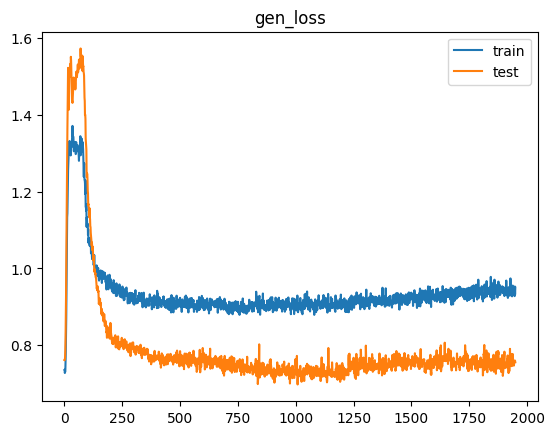

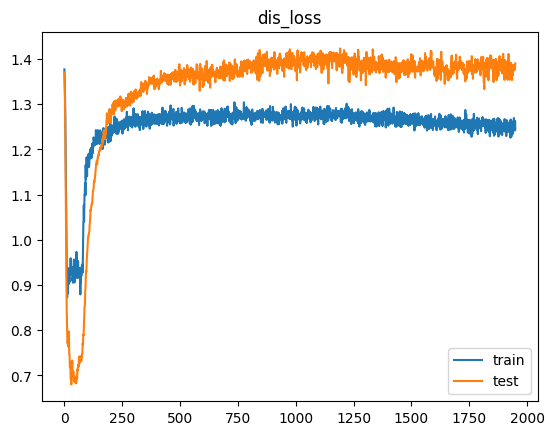

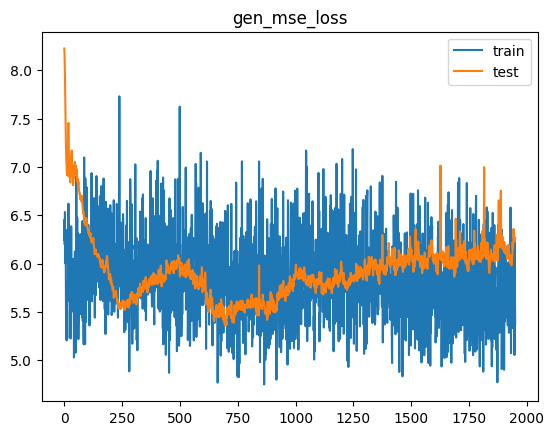

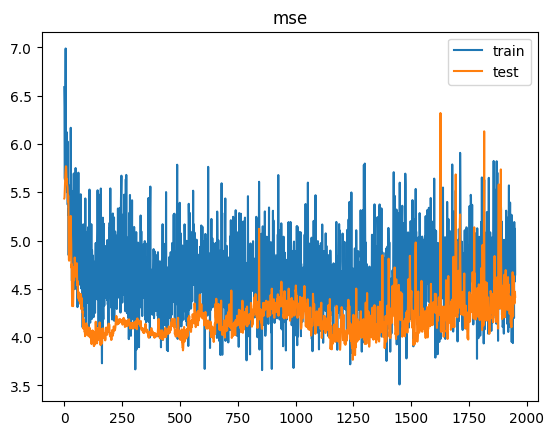

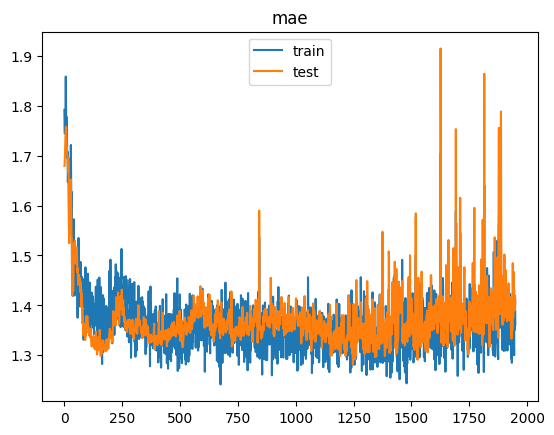

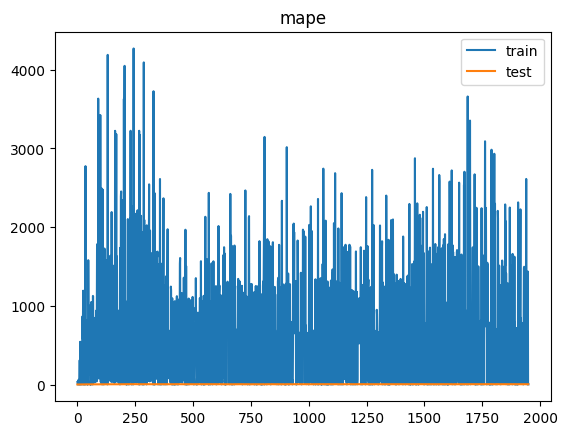

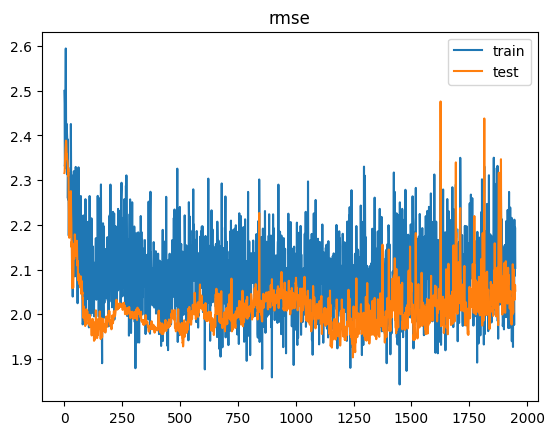

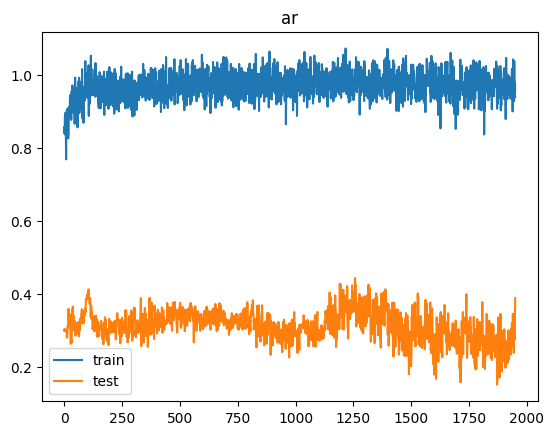

2/2 [==============================] - 0s 8ms/step


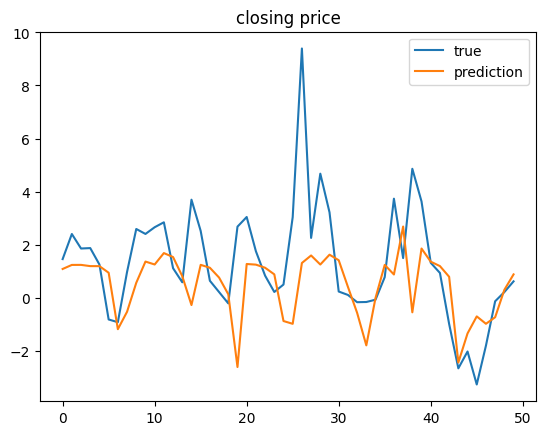

[MSE Baseline] train: 4.125078817954269  test: 3.868181586758766
Delta time with epochs = 1950: 0:22:25.896155


In [60]:
for epochs in [1950]:
    start_time = datetime.datetime.now()
    df = add_Ma(df)
    data_gen_train, data_gen_test = get_gen_train_test(df, n_sequence, n_batch)

    generator = make_generator_model(n_sequence, n_features)
    discriminator=make_discriminator_model(n_features)

    learning_rate=1e-4
    generator_optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.5)
    discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.5)

    @tf.function
    def train_step(sequences, sequences_end):
      return train_step_def(sequences, sequences_end)

    @tf.function
    def test_step(sequences, sequences_end):
      return test_step_def(sequences, sequences_end)

    checkpoint_dir = './training_checkpoints'+stock_code
    checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
    checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                     discriminator_optimizer=discriminator_optimizer,
                                     generator=generator,
                                     discriminator=discriminator)

    history, history_val = train(data_gen_train, data_gen_test, epochs)

    plot_history(history, history_val)
    plot_frame(*data_gen_test[0], generator)

    print("[MSE Baseline] train:",mean_squared_error(data_gen_train)," test:", mean_squared_error(data_gen_test))
    now = datetime.datetime.now()
    delta = now - start_time
    print("Delta time with epochs = {0}:".format(epochs), delta)
    generator.save("rnn_ffnn_epochs_{0}.h5".format(epochs))